In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from math import sqrt
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('../../data/new_data_backfill_forwfill.csv',index_col = 0)

# preparazione dati per due celle
agg_by_cell = data.groupby(by = ['cell_num'])
cell_1 = agg_by_cell.get_group('486-1252')
cell_2 = agg_by_cell.get_group('486-1256')
cell_3 = agg_by_cell.get_group('486-1258')
# define input sequence
series1 = cell_1['nr_people'].values
series2 = cell_2['nr_people'].values
series3 = cell_3['nr_people'].values
print(type(series2))

Using TensorFlow backend.


<class 'numpy.ndarray'>


### MLP per previsione multistep di serie multivariata

In [2]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [3]:
out_seq = np.array([series1[i]+series2[i]+series3[i] for i in range(len(series1))]) # convert to [rows, columns] structure
series1 = series1.reshape((len(series1), 1))
series2 = series2.reshape((len(series2), 1))
series3 = series3.reshape((len(series3), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((series1, series2, series3, out_seq))

# choose a number of time steps
n_steps_in, n_steps_out = 20, 10

# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
count = 0
for i in range(len(X)):
    print(X[i], y[i])
    count +=1
    if count > 3 : break

[[ 36.  43.  42. 121.]
 [ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]
 [ 30.  34.  33.  97.]
 [ 29.  33.  32.  94.]
 [ 29.  32.  31.  92.]
 [ 27.  30.  29.  86.]
 [ 27.  30.  29.  86.]
 [ 25.  27.  27.  79.]
 [ 24.  26.  25.  75.]
 [ 23.  25.  24.  72.]
 [ 22.  24.  23.  69.]
 [ 21.  23.  23.  67.]
 [ 20.  23.  22.  65.]
 [ 20.  22.  22.  64.]] [[19. 22. 22. 63.]
 [19. 22. 22. 63.]
 [18. 21. 23. 62.]
 [18. 22. 23. 63.]
 [18. 22. 23. 63.]
 [19. 22. 23. 64.]
 [21. 23. 22. 66.]
 [20. 23. 21. 64.]
 [20. 24. 22. 66.]
 [20. 24. 22. 66.]]
[[ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]
 [ 30.  34.  33.  97.]
 [ 29.  33.  32.  94.]
 [ 29.  32.  31.  92.]
 [ 27.  30.  29.  86.]
 [ 27.  30.  29.  86.]
 [ 25.  27.  27.  79.]
 [ 24.  26.  25.  75.]
 [ 23.  25.  24.  72.]
 [ 

In [4]:
# flatten input
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))
# flatten output
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))


In [5]:
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_input))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=2)

Epoch 1/200
 - 0s - loss: 441.8460
Epoch 2/200
 - 0s - loss: 95.9746
Epoch 3/200
 - 0s - loss: 77.6487
Epoch 4/200
 - 0s - loss: 69.1175
Epoch 5/200
 - 0s - loss: 65.9757
Epoch 6/200
 - 0s - loss: 62.0827
Epoch 7/200
 - 0s - loss: 59.9047
Epoch 8/200
 - 0s - loss: 57.7980
Epoch 9/200
 - 0s - loss: 55.9276
Epoch 10/200
 - 0s - loss: 53.8995
Epoch 11/200
 - 0s - loss: 51.8331
Epoch 12/200
 - 0s - loss: 51.5361
Epoch 13/200
 - 0s - loss: 50.1791
Epoch 14/200
 - 0s - loss: 48.5649
Epoch 15/200
 - 0s - loss: 49.6023
Epoch 16/200
 - 0s - loss: 47.2938
Epoch 17/200
 - 0s - loss: 45.4698
Epoch 18/200
 - 0s - loss: 45.2553
Epoch 19/200
 - 0s - loss: 43.7333
Epoch 20/200
 - 0s - loss: 43.7473
Epoch 21/200
 - 0s - loss: 43.1772
Epoch 22/200
 - 0s - loss: 42.5982
Epoch 23/200
 - 0s - loss: 41.4697
Epoch 24/200
 - 0s - loss: 41.9055
Epoch 25/200
 - 0s - loss: 41.4687
Epoch 26/200
 - 0s - loss: 40.2945
Epoch 27/200
 - 0s - loss: 40.7597
Epoch 28/200
 - 0s - loss: 39.3454
Epoch 29/200
 - 0s - loss: 3

In [7]:
# demonstrate prediction
x_input = np.array([[ 36. ,43. ,42.,121.],
                    [ 36. ,43. ,42.,121.],
                    [ 34. ,40. ,40.,114.]]) 
x_input = x_input.reshape((1, n_input))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[ 33.672253  39.715763  39.946476 113.103386  33.389034  39.626736
   39.408173 112.03047 ]]


In [425]:
print(n_input)

count = 0
for i in range(len(train_X)):
    print(train_X[i], train_y[i])
    count += 1
    if count > 3:
        break

12
[10 15 25 20 25 45 30 35 65] [[ 40  45  85]
 [ 50  55 105]]
[20 25 45 30 35 65 40 45 85] [[ 50  55 105]
 [ 60  65 125]]
[ 30  35  65  40  45  85  50  55 105] [[ 60  65 125]
 [ 70  75 145]]


### Calcola errore di previsione

In [426]:
predicted = np.array([])
for i in range(len(X)):
    x_input = X[i].reshape((1, n_input))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat[0])
    predicted = np.append(predicted, yhat[0])

#print('predicted', predicted) 
y = y.reshape((y.shape[0] * y.shape[1]))


[ 33.76448   39.934345  38.80935  112.38471   33.5606    39.441914
  38.18171  111.53085 ]
[ 32.62474   38.391132  37.669674 108.66696   32.165245  37.63579
  36.914352 107.225334]
[ 31.523542  36.76327   35.815174 103.99245   31.122675  36.117134
  35.126198 102.84611 ]
[ 32.620922  37.375385  36.18404  106.07915   32.508694  37.141117
  35.78534  105.99233 ]
[ 31.758926  36.01222   34.376724 101.99092   31.593752  35.81389
  33.974712 101.77174 ]
[29.618164 33.546944 32.80524  95.96926  29.121336 32.92072  32.225998
 94.46882 ]
[29.64756  33.70898  32.17801  95.47176  29.26492  33.26322  31.70329
 94.745224]
[28.847883 32.892982 31.232943 92.93653  28.670303 32.619698 30.919611
 92.53955 ]
[28.430283 32.08432  30.191307 90.569756 28.081375 31.684875 29.740946
 89.937805]
[26.476954 29.64118  28.181217 84.15578  25.954807 29.128317 27.655579
 82.9003  ]
[26.530552 29.66404  28.108238 84.308136 26.11421  29.176819 27.719313
 83.39986 ]
[24.426033 27.064476 26.254463 77.530426 23.984007

[ 39.548946  45.399204  40.631313 125.527115  38.926117  44.583366
  39.812374 123.68496 ]
[ 37.658127  43.44897   40.39445  121.55779   37.135494  42.639927
  39.63789  119.6604  ]
[ 35.715908  41.451775  38.772312 115.840744  35.17073   40.74276
  38.00422  114.257965]
[ 34.404083  39.70159   37.590054 111.631294  33.836594  38.896545
  36.80438  109.96154 ]
[ 32.85192   38.24812   36.793114 107.915924  32.48498   37.64895
  36.17204  106.62056 ]
[ 32.395576  37.23752   35.83614  105.329605  32.016277  36.679535
  35.20617  104.404755]
[ 32.7947    37.185097  36.309006 106.18029   32.746464  37.05263
  35.96868  106.17616 ]
[30.56825  34.597755 33.13714  98.16242  30.115194 34.063988 32.540825
 97.01681 ]
[29.487207 33.41437  31.834625 94.74893  28.84833  32.66166  31.204033
 93.107086]
[28.660286 32.675365 31.05545  92.35266  28.307375 32.212044 30.593542
 91.449936]
[29.017353 33.127632 31.415455 93.53427  28.981428 33.03808  31.258787
 93.6546  ]
[26.568077 30.098812 30.004337 86.

[ 32.27409   36.74224   36.716663 105.638336  31.656544  35.980354
  35.909492 104.11097 ]
[ 32.068867  36.682335  36.254303 105.00223   31.960564  36.459118
  35.90117  104.746475]
[ 32.354122  37.36385   36.445    106.19099   32.52331   37.472946
  36.387295 106.80242 ]
[ 30.830847  35.348846  35.181065 101.2183    30.770456  35.174488
  34.80592  101.06057 ]
[29.748665 33.900337 34.975327 98.57533  29.553564 33.564163 34.496956
 97.90473 ]
[ 30.277977  34.43662   35.570885 100.219505  30.458328  34.613457
  35.49617  100.93485 ]
[28.925205 32.96838  33.373947 95.15704  28.791193 32.793877 33.02168
 95.014114]
[28.38746  31.989294 32.017982 92.311806 28.01329  31.502375 31.49146
 91.49498 ]
[28.930408 32.244286 32.503124 93.606415 28.948257 32.23604  32.35807
 93.90289 ]
[26.038141 29.5201   31.039148 86.62161  25.853258 29.238035 30.689587
 85.784546]
[25.832335 29.66769  30.202484 85.68498  25.493874 29.259321 29.79661
 85.07856 ]
[25.785046 29.38225  29.455288 84.496346 25.7432   

[24.712536 27.962921 26.429953 79.02167  24.525534 27.749739 26.199528
 78.80733 ]
[23.88708  27.024746 25.531628 76.34515  23.770243 26.923702 25.378448
 76.292465]
[23.923645 27.068289 25.541695 76.495964 23.842405 26.982817 25.464397
 76.59842 ]
[23.088518 26.2568   25.625004 74.898346 23.164137 26.351873 25.633808
 75.2963  ]
[22.915438 26.076921 24.703566 73.57926  22.813631 26.04     24.59804
 73.8015  ]
[23.09695  26.34848  24.739742 74.15032  23.223518 26.516193 24.84244
 74.82036 ]
[24.010822 26.936533 25.007599 75.78576  24.252344 27.32344  25.206198
 77.04202 ]
[23.079685 25.90842  23.821863 72.736115 23.081871 25.985634 23.841608
 73.09826 ]
[23.23791  26.398947 24.719547 74.385925 23.403603 26.613161 24.929153
 75.13216 ]
[23.499174 27.013315 26.160843 76.564415 24.027721 27.745737 26.575943
 78.394646]
[23.226118 26.528625 25.038605 74.63582  23.428375 26.887268 25.179697
 75.73406 ]
[24.071209 26.9902   25.877064 76.8489   24.390442 27.394463 26.130152
 78.12802 ]
[25.47

[25.565529 28.657393 28.149248 82.291916 25.070456 28.173803 27.669281
 81.1891  ]
[24.795027 27.900759 28.187622 80.86545  24.602821 27.64333  27.91365
 80.36023 ]
[24.936018 28.089037 27.658276 80.56967  24.840193 28.043547 27.515636
 80.79202 ]
[24.778011 27.49432  27.51152  79.67876  24.777018 27.481792 27.427061
 79.96558 ]
[23.972393 26.759155 26.623222 77.2817   23.856285 26.69262  26.47278
 77.266815]
[23.016735 25.994747 26.345118 75.38024  22.93683  25.872673 26.24502
 75.24941 ]
[22.006174 25.132984 26.4795   73.54583  21.995867 25.128418 26.360485
 73.66136 ]
[21.882599 24.54246  26.598331 72.86945  21.930267 24.613712 26.516424
 73.327576]
[22.581806 25.655703 28.086205 76.298294 23.107344 26.34656  28.450544
 78.00884 ]
[22.885862 26.29684  29.290096 78.41739  23.681934 27.317276 29.879347
 80.938835]
[22.578005 25.98479  29.140377 77.578964 23.143562 26.732224 29.463634
 79.50696 ]
[23.579582 27.067293 29.22061  79.783134 24.18306  27.866508 29.61696
 81.92988 ]
[24.1775

[24.855782 27.569138 29.652706 81.899475 24.898558 27.655235 29.529837
 82.440636]
[23.929575 26.66413  28.449896 79.02374  23.788198 26.510115 28.223288
 78.82399 ]
[23.681318 26.238993 27.410881 77.23814  23.498085 26.059557 27.18828
 77.13079 ]
[22.51475  24.834791 26.28156  73.533035 22.22712  24.54059  25.919216
 72.916016]
[22.905098 25.110016 26.56791  74.5434   22.839844 25.072947 26.500883
 74.71855 ]
[21.113363 23.704575 25.46251  70.272125 21.035982 23.637693 25.332886
 70.101494]
[20.545416 23.033928 24.31358  67.79374  20.22415  22.70647  23.995323
 67.3099  ]
[20.133055 22.885832 24.613316 67.63604  20.193523 22.950161 24.607428
 67.929474]
[18.772427 21.213482 23.39781  63.2635   18.64131  21.075726 23.205564
 63.10249 ]
[18.620207 20.847689 22.55109  61.900173 18.37999  20.629717 22.301203
 61.69434 ]
[18.182083 20.382624 23.63996  62.204853 18.409061 20.618881 23.798082
 62.893436]
[17.187273 19.381643 23.795984 60.23861  17.359528 19.660938 23.859386
 60.982067]
[17.4

[ 52.66133   58.641075  53.148804 164.28728   51.68042   57.46855
  51.797718 161.49625 ]
[ 51.23404   57.12186   52.153454 160.54831   50.3886    56.10055
  51.015884 157.8933  ]
[ 49.384098  55.455906  51.147694 156.01033   48.642277  54.525875
  50.09568  153.61679 ]
[ 49.104874  54.899544  50.448643 154.33414   48.42723   54.07762
  49.4324   152.54791 ]
[ 49.7032    55.18004   50.94083  155.7687    49.48954   54.860676
  50.378876 155.24355 ]
[ 46.344696  51.603275  48.3819   146.23915   45.6737    50.834698
  47.387875 144.05914 ]
[ 45.244896  50.45621   48.211437 143.93694   44.47924   49.518803
  47.185642 141.601   ]
[ 45.047997  50.708015  47.987144 143.74281   44.803276  50.372917
  47.43091  143.08795 ]
[ 44.654346  50.228622  46.862766 141.67842   44.35426   49.794544
  46.25145  140.99144 ]
[ 44.856907  50.218227  47.083115 142.10371   44.75376   49.998398
  46.634163 141.8938  ]
[ 40.661297  45.696617  45.33391  131.65579   40.20473   45.06426
  44.50413  129.68486 ]
[ 3

[ 48.612144  55.73445   54.273228 158.59254   48.988636  55.96846
  54.04589  159.54527 ]
[ 52.373672  60.075928  59.92824  172.56834   53.896717  61.47811
  60.695755 176.47252 ]
[ 54.475933  62.029903  59.62237  175.94933   55.90428   63.538322
  60.25026  180.24771 ]
[ 53.70642   60.93899   58.315334 172.98988   54.227413  61.292328
  58.207794 174.28665 ]
[ 53.48949   60.61821   58.15756  172.23488   53.73625   60.69969
  57.817963 172.87424 ]
[ 57.15991   64.73977   61.825447 183.8252    58.28241   65.774994
  62.278748 186.91025 ]
[ 57.301983  64.75612   61.999912 183.93098   58.3655    65.83813
  62.299324 186.87779 ]
[ 57.341614  64.62308   60.32782  182.21336   57.48856   64.690285
  59.940437 182.94528 ]
[ 54.842278  61.993492  58.390114 175.24232   54.60568   61.48464
  57.564556 174.07507 ]
[ 52.30968   59.310562  56.039146 167.61935   51.48783   58.238205
  54.75991  164.9982  ]
[ 50.9815    57.554752  54.048904 162.49452   50.081295  56.411583
  52.733894 159.8607  ]
[ 52

[ 54.145348  61.34418   53.069836 168.70888   55.12894   62.343582
  53.686462 171.62375 ]
[ 55.11558   62.088276  54.19121  171.26857   56.213455  63.226658
  54.75994  174.48692 ]
[ 54.72846   61.75119   54.581337 171.03003   55.168026  62.170475
  54.5731   172.2874  ]
[ 56.215214  63.683903  57.772327 177.71136   57.136765  64.62556
  58.17684  180.23447 ]
[ 57.277554  64.887085  60.033527 182.10365   58.359753  66.03662
  60.45115  185.1553  ]
[ 57.18045   64.63227   61.674488 183.42755   58.08463   65.520096
  61.87647  185.77094 ]
[ 56.7187    63.96048   61.42799  181.98326   57.135536  64.31757
  61.198692 183.21588 ]
[ 60.512905  68.62693   65.86421  195.23924   61.85291   69.83529
  66.49534  198.73602 ]
[ 59.527447  67.760414  64.9612   192.08763   60.578598  68.84806
  65.178505 194.96936 ]
[ 56.660816  64.67433   61.286655 182.59314   56.176933  63.899925
  60.175873 181.00745 ]
[ 60.951336  69.97083   63.534393 194.6003    61.562397  70.526
  63.557625 196.49661 ]
[ 61.32

[ 42.28417   47.697647  44.80527  134.63947   43.315804  48.786762
  45.783997 137.86209 ]
[ 43.87437   49.490433  45.22088  138.536     44.737785  50.463608
  45.72277  141.31255 ]
[ 46.1758    52.287777  46.35559  144.88994   47.226727  53.398483
  47.05797  148.07306 ]
[ 46.083546  52.48094   46.987656 145.5389    46.938396  53.401108
  47.443905 147.98569 ]
[ 47.692604  53.821465  48.9506   150.33649   48.45426   54.680767
  49.269394 152.7553  ]
[ 44.69225   50.60033   49.264248 144.51578   45.144386  50.987213
  49.161404 145.21033 ]
[ 44.05558   50.032623  48.079357 142.07616   43.823246  49.74329
  47.506847 141.69112 ]
[ 44.315365  50.425945  48.207474 142.95328   44.475624  50.432236
  47.945335 143.39157 ]
[ 44.451855  50.619404  48.37719  143.40619   44.723667  50.79803
  48.202198 144.20819 ]
[ 46.661667  53.20153   48.918766 148.71275   47.222233  53.85816
  49.06079  150.72496 ]
[ 46.676594  53.02014   48.657303 148.31847   47.216164  53.52204
  48.74772  149.87291 ]
[ 4

[25.836798 29.277382 31.318523 86.36772  26.556976 30.245396 31.866728
 88.858795]
[25.690441 29.142084 31.216072 85.93351  26.359018 29.992    31.630884
 88.12828 ]
[26.031437 30.11278  33.175766 89.37178  26.904755 31.169893 33.773346
 91.8938  ]
[25.988459 30.378534 33.347145 89.59175  26.827347 31.465345 33.85026
 92.29388 ]
[25.981243 29.765678 30.889338 86.42361  26.145885 30.035303 30.815948
 87.52189 ]
[26.937849 30.44581  29.825165 87.14385  27.115808 30.627808 29.841516
 88.04826 ]
[27.283058 30.579765 29.8009   87.6418   27.575907 30.90689  29.984358
 88.72075 ]
[28.538565 32.057034 31.120632 91.65936  29.082796 32.765804 31.531471
 93.587296]
[28.541317 31.95184  31.117414 91.49511  29.039587 32.60068  31.453833
 93.25687 ]
[27.096205 30.278408 30.489815 87.80482  27.162468 30.340084 30.420334
 88.085464]
[24.814365 27.928795 30.042168 82.740265 24.64004  27.692707 29.689215
 82.051575]
[25.377247 29.061945 30.711483 85.14247  25.500536 29.253757 30.711462
 85.80675 ]
[25.8

[ 35.266426  39.53995   36.905117 111.5716    34.60392   38.842113
  36.10743  109.98549 ]
[ 34.54569   38.69909   36.74265  110.02471   34.13906   38.136433
  36.183586 108.766914]
[ 34.836132  39.04818   36.39414  110.17233   34.629406  38.84765
  36.05387  110.00665 ]
[ 33.6887    37.861916  35.088383 106.59887   33.398033  37.49104
  34.655712 105.88332 ]
[ 33.661007  37.836494  34.243736 105.679115  33.321217  37.455147
  33.83201  105.10463 ]
[ 33.642998  37.426395  34.26971  105.23854   33.507416  37.244335
  34.003403 105.09246 ]
[ 33.0572    36.905655  34.4222   104.35101   32.99097   36.8354
  34.23245  104.28218 ]
[ 31.87519   35.915913  33.229965 100.97386   31.626007  35.64425
  32.89933  100.47305 ]
[30.563559 34.642853 31.99556  97.15972  30.139904 34.120132 31.479698
 96.07423 ]
[30.338226 34.04574  31.133348 95.37909  29.920753 33.585243 30.63444
 94.567215]
[29.5897   32.94219  31.135036 93.60412  29.33933  32.63453  30.770742
 92.93367 ]
[28.586779 31.820724 30.20944

[ 54.22547   61.24317   56.85992  172.38101   54.176113  60.993786
  56.372112 172.19212 ]
[ 51.093655  57.725075  53.25799  161.90536   50.384136  56.779167
  52.055683 159.68674 ]
[ 48.876995  54.59414   51.935436 155.30804   47.85604   53.391926
  50.595963 152.17892 ]
[ 47.495808  53.279976  52.158    152.98288   46.889256  52.449615
  51.11953  150.77051 ]
[ 46.876896  52.885727  51.66289  151.40471   46.545273  52.410126
  50.917633 150.37906 ]
[ 45.75205   51.831337  50.60564  148.17406   45.42091   51.295013
  49.82278  147.06895 ]
[ 43.294464  48.85511   49.171806 141.25362   42.763557  48.062508
  48.145424 139.27824 ]
[ 42.21766   47.4576    47.4871   137.0436    41.488758  46.604748
  46.385338 135.04373 ]
[ 42.90681   48.04334   47.87631  138.8683    42.754013  47.71236
  47.371475 138.41373 ]
[ 42.244503  47.414055  48.102646 137.72993   42.36773   47.42291
  47.773033 137.90787 ]
[ 40.51421   45.24329   46.715347 132.3299    40.20792   44.830437
  45.95855  131.37914 ]
[

[ 54.52124   62.064075  58.428127 175.0434    56.00422   63.56095
  59.25949  179.33124 ]
[ 55.300087  62.8099    59.059086 177.146     56.51811   63.98433
  59.563206 180.45328 ]
[ 54.73835   62.012028  58.46732  175.1439    55.23054   62.42748
  58.34758  176.5232  ]
[ 58.230156  65.85851   62.811794 187.03783   59.45849   66.97793
  63.360687 190.30261 ]
[ 58.39332   65.87265   63.113976 187.21516   59.53474   67.06227
  63.46553  190.41446 ]
[ 56.04067   63.2186    60.697598 179.91023   55.928596  62.915485
  59.970047 179.38257 ]
[ 56.25268   63.810833  59.870876 179.98796   56.104668  63.456585
  59.228546 179.60982 ]
[ 58.22666   65.97219   59.345463 183.4726    58.40747   66.05822
  59.02738  184.41022 ]
[ 58.99843   66.97944   61.33518  187.43163   59.70313   67.51718
  61.402008 189.00319 ]
[ 58.90571   67.02829   61.455967 187.31506   59.38532   67.4417
  61.32653  188.70142 ]
[ 62.143948  70.7458    64.73392  197.71614   63.207253  71.71275
  65.10755  200.62704 ]
[ 62.1230

[ 41.95037   46.332333  42.13118  130.39763   41.856773  46.21136
  41.885704 130.18246 ]
[ 42.297207  46.73594   42.769894 131.63866   42.48875   47.043663
  42.74542  132.5971  ]
[ 42.007748  46.39051   42.416325 130.7449    41.986385  46.38171
  42.217148 130.97488 ]
[ 42.007748  46.39051   42.416325 130.7449    41.986385  46.38171
  42.217148 130.97488 ]
[ 42.007748  46.39051   42.416325 130.7449    41.986385  46.38171
  42.217148 130.97488 ]
[ 42.007748  46.39051   42.416325 130.7449    41.986385  46.38171
  42.217148 130.97488 ]
[ 45.65074   50.40108   45.18821  141.23486   46.35677   51.244713
  45.693764 143.76538 ]
[ 45.7533    50.371803  45.208157 141.18352   46.417084  51.206078
  45.59338  143.451   ]
[ 44.89515   49.352062  44.330257 138.50612   44.791225  49.269386
  44.06105  138.5111  ]
[ 48.86626   54.12876   47.240868 150.31609   49.60258   55.00017
  47.811226 152.9137  ]
[ 49.11408   54.565212  48.170116 151.80768   50.018627  55.558353
  48.75022  154.49895 ]
[ 48.

[ 35.770653  41.24021   38.911945 115.76175   35.619453  40.924747
  38.381577 115.08992 ]
[ 33.5111    38.421455  36.808044 108.601135  32.816795  37.640533
  35.974464 106.73686 ]
[ 34.69829   39.783836  36.19215  110.65213   34.357155  39.34852
  35.725826 110.13973 ]
[ 32.92217   37.85239   34.989662 105.764656  32.78271   37.509686
  34.61884  105.12599 ]
[31.335611 35.75481  32.949543 99.8622   30.67167  35.035824 32.223587
 98.3194  ]
[29.761269 34.201965 31.911263 95.90231  29.260138 33.55334  31.355349
 94.417496]
[29.574965 33.95803  31.091703 94.5414   29.19755  33.47325  30.628983
 93.78484 ]
[29.935474 34.23647  31.465336 95.56885  29.945688 34.202843 31.3097
 95.79179 ]
[27.820257 31.811195 30.110725 89.68169  27.60472  31.487673 29.75191
 88.96854 ]
[27.852829 31.886486 30.27621  89.98253  27.641323 31.598936 29.981161
 89.63868 ]
[28.30765  32.610157 30.795464 91.6393   28.58809  32.95488  30.904922
 92.70424 ]
[27.792858 31.462208 29.577614 88.65363  27.74453  31.42078

[26.406965 29.82758  28.195576 84.1988   26.731459 30.400425 28.42246
 85.6895  ]
[26.207666 29.489103 27.829166 83.447876 26.395523 29.752031 27.955948
 84.33511 ]
[29.41688  33.148094 28.528767 91.0063   29.982695 33.98402  29.083899
 93.47934 ]
[29.533947 33.09113  28.25866  90.81521  30.138657 33.828815 28.785082
 92.836205]
[29.014662 32.31887  27.758087 89.00445  29.02546  32.400417 27.80417
 89.48865 ]
[29.221899 32.56126  28.790749 90.52167  29.423567 32.827847 28.979017
 91.385376]
[29.200893 32.554188 28.928501 90.5527   29.364594 32.845524 29.067293
 91.49023 ]
[27.702976 30.947584 27.415724 85.963806 27.449007 30.724436 27.165445
 85.55132 ]
[29.216223 33.104374 27.880438 90.2215   29.269701 33.275017 28.015871
 90.94116 ]
[27.059223 31.004    26.411716 84.449646 26.99638  30.885603 26.338543
 84.301895]
[26.371742 29.989168 26.129011 82.373505 25.945412 29.502378 25.708738
 81.47337 ]
[28.67031  33.005867 29.271072 90.93292  29.32546  33.900475 29.822365
 93.12116 ]
[ 31.0

[ 53.67506   59.797432  48.196804 161.59694   54.48011   60.67642
  48.755676 164.30945 ]
[ 54.102215  59.884274  47.855907 161.66725   54.262417  60.159603
  47.84444  162.73795 ]
[ 51.83967   57.76503   46.84013  156.47946   51.504673  57.34899
  46.359295 155.3617  ]
[ 54.90878   60.926342  48.630764 164.3468    54.84991   60.961506
  48.514698 165.05853 ]
[ 56.88154   63.274616  51.109707 171.26646   57.641083  64.12914
  51.608196 173.6171  ]
[ 55.473755  61.847813  51.399014 168.65973   55.705498  62.08793
  51.36048  169.3086  ]
[ 54.56783   61.00761   50.02763  165.45366   54.089245  60.529842
  49.356873 164.51682 ]
[ 54.6448    61.042435  49.89474  165.56367   54.277145  60.56507
  49.34633  164.69948 ]
[ 54.78952   61.215134  50.07153  166.01056   54.52833   60.89604
  49.610466 165.51057 ]
[ 56.366627  62.853157  52.45184  171.65912   56.598576  63.049072
  52.435135 172.52414 ]
[ 56.306927  62.804222  52.58035  171.53937   56.46524   63.010704
  52.438194 172.32426 ]
[ 58.

[ 44.985992  50.312325  40.466053 135.72342   45.009384  50.180714
  40.334236 135.81471 ]
[ 42.21763   47.420193  37.802433 127.32239   41.367077  46.48522
  36.976433 125.069824]
[ 40.7386    45.52555   34.988888 121.00635   39.664856  44.32233
  34.02703  118.42406 ]
[ 39.913136  44.386745  33.844517 118.06054   38.994648  43.34105
  33.048088 115.68866 ]
[ 38.33993   42.65396   33.77403  114.71606   37.639744  41.950577
  33.16278  112.77883 ]
[ 37.043964  40.946693  32.976395 110.73092   36.216396  40.244164
  32.24686  108.890434]
[ 37.14284   40.723587  33.05685  110.82718   36.528484  40.125866
  32.5137   109.48853 ]
[ 36.29266   39.79521   32.17436  108.15082   35.78073   39.29483
  31.711447 106.98378 ]
[ 35.18697   38.6382    31.081272 104.80443   34.486313  37.96544
  30.508091 103.18191 ]
[ 35.382156  38.809547  31.203274 105.343994  34.882812  38.339275
  30.834919 104.3677  ]
[ 34.33781   37.794613  30.22709  102.24747   33.848167  37.323685
  29.806568 101.16873 ]
[ 34

[31.32398  34.984734 30.301056 96.50169  31.7062   35.619183 30.675272
 98.3753  ]
[31.338902 34.80335  30.039595 96.1074   31.700129 35.283066 30.362202
 97.52325 ]
[30.98005  34.30281  29.707432 94.9035   30.958853 34.34762  29.710709
 95.29787 ]
[ 33.7045    37.908993  31.398071 103.02374   34.27986   38.728924
  31.991194 105.27861 ]
[ 35.97362   40.590797  33.56227  110.17663   37.054184  41.80183
  34.541092 113.556656]
[ 36.809105  41.512333  34.47929  112.68632   37.65165   42.571926
  35.16025  115.48523 ]
[ 38.86316   43.64027   37.37803  119.88508   39.852142  44.774384
  38.18766  122.94115 ]
[ 43.230034  48.601837  40.946774 132.82887   44.491646  50.00935
  42.13993  136.90007 ]
[ 45.13745   50.710022  42.639748 138.45718   46.20156   51.858097
  43.61713  141.79977 ]
[ 43.700638  49.093655  42.822365 135.50943   44.243813  49.678143
  43.063095 137.06529 ]
[ 42.650837  47.53805   42.20157  132.19781   42.454193  47.35187
  41.77359  131.92514 ]
[ 40.60401   45.482758  40

[ 47.32893   52.928364  45.90637  146.07335   47.613724  53.33966
  45.982933 147.53194 ]
[ 47.34385   52.746964  45.64491  145.67906   47.60765   53.003548
  45.66986  146.67987 ]
[ 43.036285  47.81275   41.702072 132.29901   42.21237   46.917812
  40.727867 129.94733 ]
[ 42.93132   47.38649   41.50101  131.7826    41.95791   46.361607
  40.526085 129.33775 ]
[ 38.79435   43.303707  39.644527 121.69566   38.099735  42.613182
  38.89931  119.37642 ]
[ 38.411873  43.373734  39.577816 121.38609   37.59732   42.470577
  38.742363 119.34927 ]
[ 36.126827  40.751427  36.08572  112.687386  35.465935  39.932793
  35.259666 110.98457 ]
[ 35.11675   39.294044  34.688892 109.07047   34.19959   38.27237
  33.839527 106.70742 ]
[ 34.58851   38.794117  34.915974 108.28267   34.207138  38.31893
  34.43307  107.20973 ]
[ 34.954044  39.18492   35.43147  109.49295   34.85059   39.07942
  35.22256  109.526855]
[ 34.296043  38.173054  33.36391  105.6151    33.92828   37.775276
  32.882866 105.04506 ]
[ 3

[28.556772 32.191944 29.176203 89.886    29.161726 32.99127  29.710451
 91.95178 ]
[29.4743   33.110992 28.524902 90.8932   29.954699 33.911987 28.953579
 93.0662  ]
[30.146475 33.674732 28.034374 91.80746  30.401703 34.032555 28.3133
 93.04986 ]
[30.12703  33.51924  27.898148 91.460594 30.271706 33.76243  28.076925
 92.32099 ]
[31.055235 34.553192 28.005184 93.50994  31.151384 34.813282 28.182867
 94.46486 ]
[29.685863 33.03775  26.55376  89.170845 29.491232 32.849865 26.406788
 88.920685]
[30.901325 34.302326 27.702557 92.87517  30.842823 34.314762 27.770205
 93.24448 ]
[ 32.513123  36.188576  29.346483  97.936386  33.04585   36.966873
  29.886301 100.00955 ]
[31.050566 34.423264 28.725405 94.081215 31.103756 34.566032 28.783895
 94.519394]
[30.731543 34.05929  28.524073 93.22032  30.48977  33.882214 28.361658
 93.013176]
[ 34.654636  38.944992  30.555931 104.182144  35.278133  39.823135
  31.255053 106.724075]
[ 35.8393    40.385452  31.476141 107.69107   36.670048  41.368855
  32.2

[25.749361 28.971474 24.637959 79.28556  25.570518 28.790487 24.526072
 79.25781 ]
[25.921932 29.17004  24.657356 79.70896  25.874205 29.148294 24.680296
 79.96365 ]
[25.69837  28.511793 24.65327  78.699684 25.62746  28.503126 24.612314
 78.94691 ]
[25.732735 28.207361 24.743137 78.54177  25.62195  28.197807 24.699322
 78.7371  ]
[25.357721 28.131832 25.777683 79.29219  25.516867 28.356968 25.998827
 79.922745]
[26.088198 28.891747 26.055626 80.856285 26.259773 29.250109 26.265327
 82.058655]
[26.314705 29.369429 26.0775   81.706535 26.575706 29.78641  26.349789
 82.872986]
[24.962845 28.033411 24.590258 77.52872  24.83787  27.950546 24.536257
 77.52371 ]
[24.809559 27.969677 24.5173   77.25282  24.627958 27.786291 24.407541
 77.1313  ]
[25.118551 28.422152 24.853401 78.30919  25.24076  28.635088 24.99018
 79.064835]
[26.98706  30.11411  25.230999 82.14344  27.254917 30.619093 25.534304
 83.73609 ]
[26.272419 29.236862 24.946072 80.414055 26.481583 29.539028 25.186993
 81.262   ]
[24.9

[ 58.695553  65.65198   54.11773  178.31885   58.50271   65.39207
  53.62841  178.16077 ]
[ 58.706654  65.33414   54.050518 177.98625   58.48247   65.048416
  53.531784 177.54553 ]
[ 59.311558  66.22047   55.19459  180.77202   59.298534  66.13348
  54.94178  180.84325 ]
[ 59.25306   66.522026  55.24245  180.96175   59.24249   66.46376
  54.94289  181.15979 ]
[ 58.91011   66.26309   54.975464 180.09427   58.706055  65.94477
  54.45672  179.65594 ]
[ 63.496822  71.38321   57.035995 191.8651    63.989075  72.01234
  57.256134 194.04094 ]
[ 66.94656   74.78159   59.21739  200.99835   68.022354  75.81637
  59.915142 204.27464 ]
[ 66.44456   74.068085  58.670223 199.03957   66.73308   74.39443
  58.63375  200.19075 ]
[ 74.12949   82.69722   64.37089  221.4784    75.379974  83.88563
  65.36326  225.45773 ]
[ 75.43105   84.47682   65.416336 225.25067   76.24551   85.29873
  66.10401  227.86945 ]
[ 73.874     83.30228   63.020588 220.11122   73.61594   82.84974
  62.434753 219.55426 ]
[ 71.6001

[28.198053 31.964884 26.778671 86.92578  28.177378 32.03142  26.83719
 87.31448 ]
[28.313334 32.52945  26.876293 87.68072  28.517756 32.825417 27.09572
 88.6537  ]
[28.11834  32.438263 26.78659  87.25905  28.234911 32.628838 26.8743
 87.95895 ]
[30.215187 34.362976 28.183575 92.61293  30.671528 35.021175 28.581114
 94.51495 ]
[30.243694 33.879314 28.14286  92.095604 30.60473  34.412228 28.436598
 93.55826 ]
[29.94965  33.26384  27.733814 90.85715  29.901842 33.286087 27.752977
 91.20695 ]
[28.397236 31.715347 25.455097 85.41674  27.949894 31.251678 25.081926
 84.54178 ]
[27.716215 31.334627 25.162746 84.2943   27.269012 30.821981 24.88063
 83.20706 ]
[27.94743  31.591995 26.578957 86.02853  27.967136 31.634111 26.624743
 86.408844]
[27.17604  31.049286 26.773827 84.90364  27.222157 31.18171  26.78702
 85.312546]
[26.66147  30.226461 25.509323 82.25007  26.412233 30.00655  25.30433
 82.075645]
[27.056335 30.952923 25.706947 83.707466 27.046587 30.987541 25.72746
 84.015686]
[29.412432 3

[ 47.494865  53.55371   28.10788  128.86278   46.25594   52.182236
  27.328398 125.912735]
[ 46.699963  52.383026  27.28874  126.11081   45.535892  51.180836
  26.616457 123.47633 ]
[ 44.643143  49.72996   26.284584 120.25413   43.437675  48.458866
  25.6392   117.511215]
[ 43.6169    48.442467  25.467575 117.128716  42.318474  47.18738
  24.800903 114.49016 ]
[ 42.4647    46.991364  25.186054 114.45594   41.438736  45.969437
  24.671265 112.090866]
[ 41.45743   45.760082  24.48074  111.46057   40.398975  44.78403
  23.95828  109.235146]
[ 40.821056  45.458405  24.36528  110.65506   39.959293  44.527855
  24.060072 108.688576]
[ 40.598877  45.794796  23.560854 109.90019   39.862602  44.863686
  23.313784 108.41181 ]
[ 39.824345  44.728405  23.315418 107.80745   39.0728    43.849167
  23.009293 106.01786 ]
[ 39.329082  44.106007  22.530903 105.75133   38.449657  43.15867
  22.13792  104.03059 ]
[ 38.4916    42.879677  22.387012 103.660385  37.663826  41.977345
  22.058798 101.78334 ]
[ 

[ 53.64339   74.6802    47.084908 175.46272   54.25892   74.991486
  46.897694 176.55971 ]
[ 51.589233  71.874596  46.91885  170.3621    52.28538   72.13948
  46.72032  171.31361 ]
[ 50.20783   69.57614   46.778904 166.47429   50.601734  69.55334
  46.300156 166.79279 ]
[ 51.028366  70.979866  47.54926  169.57793   51.97279   71.810265
  47.59986  171.69753 ]
[ 51.326626  71.64478   47.739586 170.75154   52.58078   72.81497
  48.077366 173.73108 ]
[ 52.850616  72.91438   46.87676  172.52155   53.9607    73.99757
  47.070343 175.51959 ]
[ 53.7241    72.895775  46.679028 173.21854   54.829536  73.884834
  46.880993 175.89882 ]
[ 53.626755  72.00126   45.507343 171.0638    54.330765  72.54223
  45.466812 172.68198 ]
[ 51.01158   68.013855  43.57433  162.5956    51.066544  67.525116
  43.038284 161.97064 ]
[ 51.120594  68.194     43.91637  163.2224    51.27605   68.03594
  43.48053  163.24051 ]
[ 47.333103  63.922394  40.641224 151.95923   47.16143   63.187126
  40.0322   150.69157 ]
[ 46.

[31.265924 38.570763 24.869354 94.662994 31.482033 38.881622 25.09384
 95.62515 ]
[31.084108 38.462433 24.785126 94.247734 31.218534 38.66323  24.893164
 94.944885]
[30.436123 38.34073  25.774715 94.57569  30.74788  38.715183 26.018614
 95.49059 ]
[ 32.79721   41.65847   28.457863 102.86499   33.70185   42.870926
  29.171598 105.87251 ]
[ 33.931423  42.908676  30.569565 107.329124  35.135666  44.35039
  31.42862  110.87718 ]
[ 34.81799   43.73298   31.479527 109.88831   35.79142   44.993008
  32.11184  112.966675]
[ 36.21689   46.129868  32.5373   114.962685  37.2919    47.45411
  33.317726 118.19866 ]
[ 36.04988   46.500645  32.272278 114.79268   36.964626  47.61473
  32.87472  117.55735 ]
[ 35.42252   45.814648  31.769268 112.94408   35.885048  46.30672
  31.916239 114.31332 ]
[ 40.14267   52.208885  33.71303  126.22989   41.37205   53.64022
  34.626255 130.12381 ]
[ 43.02763   55.74738   34.635387 133.47012   44.17416   56.97261
  35.624226 137.02188 ]
[ 42.854805  55.597275  34.240

[ 46.84047   62.013233  37.773952 146.62115   47.46211   62.647846
  38.024826 148.36711 ]
[ 46.519753  61.861526  37.59473  145.94089   47.05883   62.324303
  37.682    147.29794 ]
[ 48.63891   64.06265   39.96397  152.57344   49.634132  65.16206
  40.376686 155.38165 ]
[ 48.789566  63.600838  40.093376 152.30154   49.70325   64.6296
  40.41968  154.8359  ]
[ 48.4294    62.74099   39.49298  150.62535   48.839485  63.05624
  39.484093 151.66238 ]
[ 49.377182  63.77916   38.68434  151.76172   49.743908  64.124504
  38.678253 152.97119 ]
[ 50.912373  66.221886  39.93103  157.14363   51.748947  67.136925
  40.345016 159.45319 ]
[ 52.175137  68.38675   40.237843 160.82245   53.166275  69.52749
  40.791115 163.72638 ]
[ 54.032997  70.91296   42.098866 167.11348   55.234978  72.1793
  42.75762  170.40784 ]
[ 55.13834   72.156525  44.22875  171.46893   56.492622  73.618385
  44.90409  175.07793 ]
[ 56.6828    73.07371   44.15685  173.68587   57.60223   74.149895
  44.475834 176.54478 ]
[ 57.8

[33.93938  40.309895 24.413864 98.683876 33.512123 39.819237 24.2349
 97.851364]
[32.75281  39.57495  24.181023 96.53796  32.37273  39.03138  23.97613
 95.61102 ]
[32.96987  40.348404 25.608305 98.860535 32.979195 40.39769  25.635317
 99.15842 ]
[ 33.14139   40.59422   25.896172  99.495995  33.306973  40.882908
  26.030233 100.3629  ]
[ 33.170715  40.67037   26.774872 100.5519    33.406136  40.98943
  26.950895 101.45011 ]
[ 33.18529   40.64166   26.896961 100.589386  33.390232  40.970104
  27.032486 101.545456]
[ 33.07125   40.432087  26.720428 100.14165   33.170277  40.57878
  26.777689 100.7277  ]
[ 35.58538   43.951675  27.407299 106.8986    36.098087  44.773666
  27.886976 109.04063 ]
[ 35.37509   43.770866  26.073547 105.16325   35.76864   44.211582
  26.417433 106.566795]
[ 34.746788  42.854332  24.45863  102.01344   34.504284  42.52718
  24.307623 101.65851 ]
[33.75511  41.768734 24.266478 99.7837   33.5166   41.371727 24.111223
 99.16714 ]
[32.762527 40.766388 24.310385 97.779

[ 50.758293  61.197254  37.57491  149.47379   50.02237   60.122597
  36.896324 147.04135 ]
[ 50.282566  60.47559   38.50617  149.18512   49.453686  59.3096
  37.68576  146.97195 ]
[ 49.809566  59.969738  39.091045 148.74075   49.565914  59.540394
  38.658924 148.03908 ]
[ 50.809643  61.01862   38.304066 150.03307   50.501118  60.626686
  37.915222 149.6062  ]
[ 50.9675    61.209892  38.233772 150.40514   50.87346   60.959595
  38.0307   150.22423 ]
[ 49.976803  60.106777  39.05318  149.1185    49.845314  59.778107
  38.778015 148.62402 ]
[ 49.68918   59.618607  37.178772 146.33717   49.17842   58.95405
  36.624958 145.30524 ]
[ 46.678905  56.100395  35.559048 138.3658    45.938362  54.97402
  34.90352  136.00761 ]
[ 44.446106  53.25581   33.74728  131.25633   43.37494   51.978176
  32.883194 128.5526  ]
[ 42.284103  50.26679   31.77018  124.11803   41.183426  48.974102
  30.903267 121.341324]
[ 40.5044    48.111027  30.815872 119.34275   39.565655  46.975506
  30.103735 116.881615]
[ 3

[ 60.531086  76.59064   50.08579  187.28183   60.85243   76.656624
  49.89971  187.87598 ]
[ 60.463303  76.69187   50.1781   187.31435   60.808876  76.82955
  49.953835 188.01346 ]
[ 65.760475  82.89955   52.12712  200.78517   66.784515  84.00478
  52.521233 204.05818 ]
[ 68.93949   86.00211   53.18812  208.13      70.109825  87.13715
  53.791237 211.46112 ]
[ 68.57695   84.68825   53.46269  206.61067   69.25267   85.25119
  53.529076 208.24503 ]
[ 67.90377   83.05863   51.915356 202.74245   67.665855  82.54726
  51.27691  202.04608 ]
[ 68.69994   85.104706  53.118084 207.10475   68.91196   85.131935
  52.95585  207.42725 ]
[ 68.44774   84.93324   53.116444 206.44641   68.683876  84.94725
  52.89965  206.9741  ]
[ 66.61962   81.98463   52.403564 200.90347   66.27879   81.15104
  51.590782 199.48334 ]
[ 68.21742   84.16319   53.088978 205.45116   68.18602   83.96498
  52.633442 205.3836  ]
[ 68.53116   84.71613   53.165348 206.43628   68.80678   84.77871
  52.994682 207.02136 ]
[ 69.583

[27.64954  38.12578  28.031235 93.74197  28.411076 38.993305 28.387154
 95.91227 ]
[ 36.532726  48.48697   37.151077 122.6015    38.908604  50.834984
  39.10415  129.19026 ]
[ 36.295807  47.99384   37.129612 121.00575   37.242996  49.248848
  38.014175 124.24686 ]
[ 40.94089   53.01232   38.583374 132.61574   42.413437  54.583755
  39.488792 137.04141 ]
[ 42.48744   55.39993   39.65526  137.64166   43.873905  56.874702
  40.62756  141.4521  ]
[ 41.838657  54.195187  39.89123  135.79877   42.879005  55.281437
  40.32508  138.5828  ]
[ 41.791164  52.39258   39.5066   133.35065   42.12682   52.691566
  39.240593 134.40718 ]
[ 42.13724   51.72356   39.503872 133.2242    42.444996  51.982513
  39.343872 134.06595 ]
[ 46.08541   58.595425  43.59522  148.75691   47.631626  60.269344
  44.741974 152.92477 ]
[ 46.776432  60.566986  45.456245 152.88899   48.469925  62.32494
  46.56126  157.49176 ]
[ 47.921143  61.929855  45.2876   154.97      49.089615  63.26398
  45.671368 158.40565 ]
[ 49.6768

[35.100033 38.65228  24.341324 98.003975 34.407936 37.982372 23.997377
 96.60649 ]
[33.002975 36.053013 23.337255 92.13466  32.250057 35.416615 22.903059
 90.4171  ]
[32.958702 35.670643 23.384336 91.82856  32.05015  34.996315 22.917202
 90.13781 ]
[31.439594 34.477856 22.51065  88.3356   30.827545 33.957672 22.242569
 86.97512 ]
[31.070526 33.970936 22.31654  87.21718  30.331026 33.350666 21.966608
 85.81616 ]
[30.349457 33.467617 21.619362 85.30424  29.76217  32.97737  21.34598
 84.20449 ]
[30.39419  33.7038   21.454796 85.52942  29.896872 33.19046  21.302576
 84.618484]
[30.564774 33.992718 21.700172 86.147064 30.229567 33.747223 21.659796
 85.82756 ]
[30.564774 33.992718 21.700172 86.147064 30.229567 33.747223 21.659796
 85.82756 ]
[30.653358 35.23148  24.945599 90.96452  30.99195  35.715378 25.466509
 92.013306]
[29.750584 35.490288 25.216484 90.381966 30.057232 36.063107 25.612211
 91.759674]
[30.079924 36.369427 23.924175 90.284775 30.086449 36.52056  24.01221
 90.98875 ]
[30.96

[ 56.97076   69.16047   46.97227  173.11003   56.947613  68.81376
  46.546967 172.8482  ]
[ 54.648724  66.007     44.409527 165.07297   53.97176   64.8056
  43.546124 162.88312 ]
[ 53.5488    64.969025  43.35366  161.91414   52.764618  63.694134
  42.45309  159.5551  ]
[ 53.92096   65.938034  43.88167  163.7491    53.705658  65.452614
  43.402428 163.06458 ]
[ 50.823997  62.220837  42.481266 155.52098   50.34776   61.249657
  41.76516  153.68129 ]
[ 49.467995  60.30094   41.47264  151.14072   48.673744  59.07835
  40.54754  148.9071  ]
[ 48.540665  59.285492  40.589535 148.3797    47.991436  58.329964
  39.809708 146.64664 ]
[ 47.61563   58.153374  38.682835 144.43202   47.000706  57.145153
  37.94036  142.66931 ]
[ 47.811916  58.776745  38.862972 145.50356   47.542637  58.218235
  38.413887 144.66257 ]
[ 48.19694   59.470398  39.381817 146.99701   48.326218  59.50543
  39.23681  147.40721 ]
[ 48.19694   59.470398  39.381817 146.99701   48.326218  59.50543
  39.23681  147.40721 ]
[ 46.

[ 53.7891   66.96821  44.62586 165.40805  54.48291  67.60853  44.83306
 167.0018 ]
[ 54.693165  68.2279    45.691006 168.55934   55.230175  68.83062
  45.800186 170.20865 ]
[ 55.170837  69.53174   47.895557 172.61499   56.159267  70.63107
  48.293884 175.18378 ]
[ 56.114628  70.8649    49.030655 175.91641   57.094532  72.01384
  49.384827 178.7604  ]
[ 55.74316   70.21376   48.610424 174.48657   56.40074   70.83093
  48.652554 176.19423 ]
[ 58.970947  74.034035  51.9335   184.98445   60.151447  75.26688
  52.41121  188.23985 ]
[ 60.481945  75.9906    53.33566  189.79042   61.947052  77.56064
  53.99843  193.75484 ]
[ 60.41439   76.54254   53.832596 190.84604   61.4833    77.663345
  54.191395 193.585   ]
[ 58.55022   73.97436   53.04684  185.4996    58.99218   74.14394
  52.786842 186.28197 ]
[ 59.370533  74.81026   53.206318 187.30475   59.718674  75.009544
  52.853745 188.14941 ]
[ 61.115726  77.321465  53.769886 192.23383   61.99592   78.22784
  53.940697 194.61137 ]
[ 63.76922   79

[30.981268 37.174286 26.337059 94.551384 31.022657 37.091053 26.362574
 94.58271 ]
[31.500557 38.596676 27.99905  98.045654 31.851759 39.149094 28.261034
 99.36618 ]
[ 31.815699  39.47154   30.165947 101.40661   32.615414  40.501526
  30.733593 103.819534]
[ 31.531656  39.118763  30.142166 100.61017   32.074715  39.881844
  30.414015 102.49316 ]
[ 31.303576  38.699627  29.78909   99.714676  31.634792  39.099186
  29.904413 100.85765 ]
[ 31.303576  38.699627  29.78909   99.714676  31.634792  39.099186
  29.904413 100.85765 ]
[ 33.286304  42.20083   33.370144 109.03729   34.46908   43.578045
  34.23435  112.32898 ]
[ 34.495438  44.617256  33.7905   112.909904  35.83147   46.22825
  34.73296  116.97493 ]
[ 36.740444  47.0119    34.373985 118.10313   37.9141    48.302067
  35.09138  121.686325]
[ 38.90527   48.99516   36.485043 124.36262   40.29737   50.490868
  37.33577  128.26704 ]
[ 41.507442  52.5056    38.743687 132.88857   42.997513  54.16263
  39.81172  137.141   ]
[ 46.049263  57.3

[ 47.716652  54.980785  36.260647 138.87646   47.349033  54.540718
  35.93318  138.21616 ]
[ 42.57696   49.248703  32.89329  124.52759   41.61251   48.174515
  32.156033 121.70056 ]
[ 41.006634  47.19153   30.832193 118.797455  39.368603  45.640568
  29.826294 115.5237  ]
[ 40.198376  46.29944   29.981522 116.37834   39.324444  45.282833
  29.325922 114.24808 ]
[ 39.37141   45.39662   29.07038  113.756836  38.622444  44.530678
  28.54062  111.98602 ]
[ 37.902523  43.04849   27.996635 108.68533   37.03408   42.143414
  27.34654  106.67052 ]
[ 37.316128  42.278786  28.143038 107.64368   36.54547   41.52911
  27.605862 105.86816 ]
[ 36.310596  40.989197  28.03703  105.21922   35.723938  40.39057
  27.621536 103.83333 ]
[34.49483  39.20095  26.381365 99.91327  33.676144 38.468018 25.86089
 98.143   ]
[34.200943 38.77714  26.031775 98.94928  33.473938 37.995605 25.576773
 97.365425]
[33.30657  37.67659  25.335945 96.14429  32.70143  37.10995  24.917791
 94.905   ]
[33.371284 37.66249  25.26

[ 59.184917  75.03483   47.875473 182.0773    59.18299   74.67838
  47.406513 181.71213 ]
[ 58.855057  74.259056  47.68641  180.76396   58.752342  73.76848
  47.121597 180.1581  ]
[ 59.466354  75.37755   48.269325 183.11362   59.748947  75.5028
  48.045822 183.69537 ]
[ 59.607666  75.76793   48.293884 183.68925   60.013256  76.00297
  48.210003 184.61978 ]
[ 58.334698  74.335724  47.963062 180.63396   58.526215  74.21847
  47.63971  180.72568 ]
[ 58.019417  73.53123   47.896084 179.35814   58.07969   73.28923
  47.436386 179.26697 ]
[ 60.09937   75.255     48.433773 183.61143   60.43585   75.524
  48.20584  184.70508 ]
[ 60.35264   74.857315  48.349712 183.48938   60.72404   75.07868
  48.210457 184.34961 ]
[ 59.920742  73.50014   47.92145  181.24434   59.866425  73.16774
  47.46487  180.95703 ]
[ 61.05239   74.54196   48.22772  183.72401   61.089134  74.452065
  47.870983 183.92673 ]
[ 61.897675  74.66002   47.208393 183.62285   61.836056  74.427536
  46.829945 183.6655  ]
[ 61.930744

[ 37.156574  50.773457  37.336308 125.15637   38.30349   52.145725
  37.847416 128.53113 ]
[ 37.96023   51.63088   37.143955 126.70487   39.103878  52.85457
  37.628006 129.8434  ]
[ 39.98663   53.85755   38.244038 132.10179   41.29888   55.25344
  38.873947 135.72755 ]
[ 41.582787  56.515987  39.500923 137.75522   43.182323  58.222378
  40.402138 141.99327 ]
[ 42.36142   57.84247   39.306034 139.5543    43.750393  59.306152
  40.03479  143.35371 ]
[ 41.972214  57.496548  38.927013 138.36443   43.02266   58.56314
  39.29753  141.0454  ]
[ 43.741383  59.036583  40.022152 142.70636   44.859516  60.22986
  40.42813  145.81792 ]
[ 47.15496   62.88587   41.53621  151.6144    48.69938   64.5424
  42.327927 155.95207 ]
[ 47.482937  63.58471   41.285034 152.44829   48.899006  65.03169
  42.04767  156.12048 ]
[ 50.12979   67.05297   43.20415  160.47536   51.53257   68.52386
  43.914627 164.35593 ]
[ 50.215534  66.94106   43.227367 160.30008   51.56791   68.34566
  43.819298 163.82692 ]
[ 49.939

[27.742243 31.020056 24.606678 83.270195 27.501827 30.846075 24.50311
 83.10869 ]
[25.693867 29.282125 21.693903 76.54941  25.218933 28.75101  21.414183
 75.570816]
[25.346893 28.789028 21.153322 75.27273  24.749136 28.122341 20.836279
 74.02132 ]
[26.040388 30.043734 21.90872  77.924774 26.033129 30.169325 22.020102
 78.38475 ]
[24.570717 29.656067 21.790222 76.13526  24.676392 29.824549 22.039728
 76.55955 ]
[24.276941 30.335806 21.814602 76.41768  24.388992 30.551645 21.9986
 77.15912 ]
[24.817947 32.150616 24.270863 81.25682  25.627525 33.23292  24.901062
 83.685974]
[25.593723 32.788155 24.519285 82.665794 26.380114 33.928886 25.071127
 85.47541 ]
[25.696054 33.413868 23.33434  82.43123  26.23709  34.197712 23.744814
 84.3238  ]
[26.809008 35.346893 24.258875 86.481995 27.639673 36.38578  24.945602
 89.10261 ]
[27.812128 37.103127 23.620743 88.45406  28.629705 38.23385  24.240322
 91.27361 ]
[28.225294 37.093372 22.074097 87.303116 28.681597 37.653385 22.427237
 89.007095]
[28.485

[ 62.15764   73.33089   46.397427 181.75203   61.294525  71.97509
  45.39068  179.2467  ]
[ 59.367764  69.90492   45.138447 174.37485   58.23512   68.37524
  44.0588   170.89207 ]
[ 57.974007  68.07335   42.584724 168.39276   56.623493  66.44084
  41.391193 165.0658  ]
[ 55.19427   64.79558   40.39935  160.31613   53.953453  63.13983
  39.339767 156.67175 ]
[ 54.3187    63.901356  39.49638  157.67671   53.137978  62.451298
  38.54486  154.64119 ]
[ 54.23303   63.599186  39.589767 157.34795   53.483585  62.50491
  38.84816  155.35638 ]
[ 52.6496    62.10908   39.663136 154.42992   52.031345  61.172256
  39.016617 152.47482 ]
[ 51.396458  60.597374  39.522305 151.44823   50.67408   59.563225
  38.785034 149.37962 ]
[ 52.480507  61.39731   41.046818 154.75189   52.139465  60.928524
  40.545708 154.06323 ]
[ 52.241837  61.23569   42.354187 155.78171   52.27204   61.21135
  42.18698  155.85376 ]
[ 52.48344   61.110672  40.317795 153.69124   51.98884   60.50538
  39.768894 152.96112 ]
[ 50.9

[ 68.79016  87.37281  44.9277  200.95586  69.40322  88.03971  45.21702
 202.7776 ]
[ 67.952324  86.08673   43.982315 198.00143   67.792496  85.638245
  43.625282 197.42575 ]
[ 64.71938   82.1556    43.285538 190.19942   64.176765  81.01048
  42.58064  187.97112 ]
[ 64.64554   82.79603   41.654903 189.10382   63.879154  81.63736
  40.833942 187.01634 ]
[ 62.72109   81.0256    40.299934 184.1995    62.17664   79.8414
  39.659576 182.06467 ]
[ 65.25229   83.442055  39.997288 188.50691   64.82736   82.76695
  39.41362  187.7435  ]
[ 65.7931    83.32934   40.1607   189.227     65.78723   83.05026
  39.937675 189.0086  ]
[ 70.63063   89.470985  43.15753  203.28494   71.285965  90.33633
  43.620323 205.65918 ]
[ 68.615906  86.66497   42.67049  198.0189    68.99468   87.04327
  42.84997  198.85184 ]
[ 70.33254  89.92348  42.50427 202.82732  70.25324  89.82739  42.37254
 202.979  ]
[ 71.67946  91.70836  43.09035 206.78491  72.07765  92.46777  43.36107
 208.22394]
[ 71.7367    91.32049   42.8473

[25.718166 32.445793 21.639736 79.71612  25.727043 32.430756 21.613554
 80.14545 ]
[25.196312 32.09218  21.750763 79.04959  25.405048 32.3141   21.911772
 79.68644 ]
[24.487894 32.122166 21.834406 78.48774  24.74312  32.44611  22.08368
 79.35597 ]
[24.250607 32.05165  22.844545 79.05863  24.696684 32.58265  23.131973
 80.475204]
[24.580618 32.82354  23.288792 80.582794 25.193914 33.687935 23.68231
 82.60982 ]
[24.607893 33.00436  23.136824 80.710686 25.238285 33.796776 23.591696
 82.71646 ]
[24.3777   34.607235 24.404072 83.55203  25.371675 35.870785 25.155664
 86.29096 ]
[23.65568  33.70377  24.099243 81.33045  24.477907 34.6473   24.604837
 83.8054  ]
[23.23415  32.879627 23.955128 79.9142   23.809498 33.541824 24.134329
 81.56773 ]
[23.597782 33.09628  24.12358  80.744705 24.336498 33.978603 24.535685
 82.92827 ]
[27.015778 37.140156 28.586807 92.84838  28.627155 38.90906  29.69983
 97.331894]
[ 28.296568  38.774017  29.969028  96.92396   29.668907  40.44001
  30.971548 101.01194 ]


[ 55.680645  70.25108   43.772232 169.61758   56.328148  70.89951
  43.95463  171.39062 ]
[ 53.86175   67.25213   42.836605 163.86957   53.763527  66.81277
  42.38396  163.28625 ]
[ 53.89986   67.42706   41.080708 162.35466   53.54549   66.84648
  40.505405 161.48248 ]
[ 52.29063   64.55025   38.466187 155.2439    51.638794  63.28489
  37.688484 153.18713 ]
[ 50.272816  61.343166  38.40762  149.8999    49.445     60.054604
  37.51626  147.33417 ]
[ 48.589622  59.01671   36.80895  144.24701   47.684948  57.820877
  35.965813 141.89612 ]
[ 48.0919    57.57989   35.585247 141.10405   47.179115  56.28622
  34.732735 138.80359 ]
[ 46.61406   55.907417  34.833828 137.31303   45.89872   54.871502
  34.163986 135.27542 ]
[ 45.47131   54.427322  33.747093 133.5711    44.683918  53.342728
  33.08683  131.5483  ]
[ 44.463852  53.204163  32.88388  130.4641    43.72166   52.180233
  32.22831  128.56584 ]
[ 43.37539   51.637238  32.750504 127.68399   42.748497  50.711796
  32.164036 125.9415  ]
[ 43

[ 46.827896  60.959877  39.885265 147.6938    47.628654  61.74501
  40.152554 149.78783 ]
[ 46.597828  60.76497   39.466957 146.88573   47.097794  61.14215
  39.549953 148.1072  ]
[ 49.767162  64.75877   41.162277 155.65826   50.77033   65.901215
  41.616028 158.71654 ]
[ 49.96687   64.675735  41.09068  155.65805   51.00393   65.77985
  41.55902  158.45387 ]
[ 50.957287  66.25186   41.94341  159.18028   51.791775  67.19819
  42.29103  161.52707 ]
[ 54.356937  70.92523   44.43957  169.8556    55.846798  72.53497
  45.317665 174.0657  ]
[ 56.41394   73.85927   45.477253 175.81557   57.837627  75.375305
  46.32106  179.79478 ]
[ 58.17655   76.026405  46.209187 180.44284   59.515923  77.408516
  46.883163 184.11954 ]
[ 56.952454  74.453156  46.62733  178.00348   57.888725  75.29762
  46.89229  180.11975 ]
[ 56.080452  72.57563   45.119133 173.61777   56.199867  72.45075
  44.713627 173.81532 ]
[ 54.77141   70.491905  42.688877 167.92284   54.47692   69.739746
  42.006535 166.74353 ]
[ 53.3

In [427]:
expected = y
print(len(expected))
print(expected)


94432
[ 33.  39.  39. ...  51.  33. 124.]


Mean Absolute Error =  1.9408213018926674


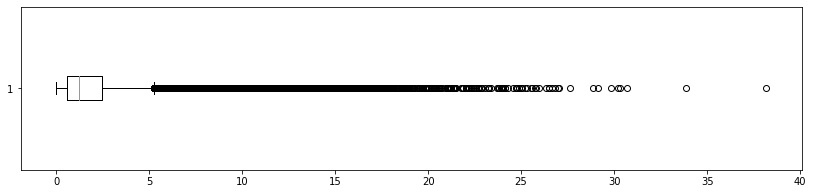

In [428]:
difference = abs(predicted - expected)
print('Mean Absolute Error = ', np.mean(difference))
plt.figure(figsize = (14,2))
plt.boxplot(difference, vert = False)
plt.show()

### CNN per previsione multistep di serie multivariata

In [275]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


out_seq = np.array([series1[i]+series2[i]+series3[i] for i in range(len(series1))])

# convert to [rows, columns] structure
series1 = series1.reshape((len(series1), 1))
series2 = series2.reshape((len(series2), 1))
series3 = series3.reshape((len(series3), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = hstack((series1, series2,series3, out_seq))

# choose a number of time steps
n_steps_in, n_steps_out = 3, 2

# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

for i in range(len(X)):
    print(X[i], y[i])

# flatten output
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))

# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

[[ 36.  43.  42. 121.]
 [ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]] [[ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]]
[[ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]] [[ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]]
[[ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]] [[ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]]
[[ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]] [[ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]]
[[ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]] [[30. 34. 34. 98.]
 [30. 34. 33. 97.]]
[[ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]] [[30. 34. 33. 97.]
 [29. 33. 32. 94.]]
[[ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]
 [ 30.  34.  33.  97.]] [[29. 33. 32. 94.]
 [29. 32. 31. 92.]]
[[30. 34. 34. 98.]
 [30. 34. 33. 97.]
 [29. 33. 32. 94.]] [[29. 32. 31. 92.]
 [27. 30. 29. 86.]]
[[30. 34. 33. 97.]
 [29. 33. 32. 94.]
 [29. 32. 31. 92.]] [[27. 30. 29. 86.]
 [27. 30. 29. 86.]]
[[29. 33. 3

 [ 36.  42.  40. 118.]] [[ 35.  40.  39. 114.]
 [ 33.  39.  38. 110.]]
[[ 38.  44.  42. 124.]
 [ 36.  42.  40. 118.]
 [ 35.  40.  39. 114.]] [[ 33.  39.  38. 110.]
 [ 33.  37.  37. 107.]]
[[ 36.  42.  40. 118.]
 [ 35.  40.  39. 114.]
 [ 33.  39.  38. 110.]] [[ 33.  37.  37. 107.]
 [ 33.  37.  37. 107.]]
[[ 35.  40.  39. 114.]
 [ 33.  39.  38. 110.]
 [ 33.  37.  37. 107.]] [[ 33.  37.  37. 107.]
 [ 31.  35.  34. 100.]]
[[ 33.  39.  38. 110.]
 [ 33.  37.  37. 107.]
 [ 33.  37.  37. 107.]] [[ 31.  35.  34. 100.]
 [ 30.  34.  33.  97.]]
[[ 33.  37.  37. 107.]
 [ 33.  37.  37. 107.]
 [ 31.  35.  34. 100.]] [[30. 34. 33. 97.]
 [29. 33. 32. 94.]]
[[ 33.  37.  37. 107.]
 [ 31.  35.  34. 100.]
 [ 30.  34.  33.  97.]] [[29. 33. 32. 94.]
 [29. 33. 32. 94.]]
[[ 31.  35.  34. 100.]
 [ 30.  34.  33.  97.]
 [ 29.  33.  32.  94.]] [[29. 33. 32. 94.]
 [27. 30. 31. 88.]]
[[30. 34. 33. 97.]
 [29. 33. 32. 94.]
 [29. 33. 32. 94.]] [[27. 30. 31. 88.]
 [26. 30. 30. 86.]]
[[29. 33. 32. 94.]
 [29. 33. 32. 94.]

 [ 45.  51.  50. 146.]] [[ 45.  51.  50. 146.]
 [ 44.  49.  50. 143.]]
[[ 45.  51.  50. 146.]
 [ 45.  51.  50. 146.]
 [ 45.  51.  50. 146.]] [[ 44.  49.  50. 143.]
 [ 44.  49.  50. 143.]]
[[ 45.  51.  50. 146.]
 [ 45.  51.  50. 146.]
 [ 44.  49.  50. 143.]] [[ 44.  49.  50. 143.]
 [ 45.  51.  50. 146.]]
[[ 45.  51.  50. 146.]
 [ 44.  49.  50. 143.]
 [ 44.  49.  50. 143.]] [[ 45.  51.  50. 146.]
 [ 45.  51.  50. 146.]]
[[ 44.  49.  50. 143.]
 [ 44.  49.  50. 143.]
 [ 45.  51.  50. 146.]] [[ 45.  51.  50. 146.]
 [ 41.  46.  45. 132.]]
[[ 44.  49.  50. 143.]
 [ 45.  51.  50. 146.]
 [ 45.  51.  50. 146.]] [[ 41.  46.  45. 132.]
 [ 39.  44.  42. 125.]]
[[ 45.  51.  50. 146.]
 [ 45.  51.  50. 146.]
 [ 41.  46.  45. 132.]] [[ 39.  44.  42. 125.]
 [ 39.  44.  42. 125.]]
[[ 45.  51.  50. 146.]
 [ 41.  46.  45. 132.]
 [ 39.  44.  42. 125.]] [[ 39.  44.  42. 125.]
 [ 36.  41.  41. 118.]]
[[ 41.  46.  45. 132.]
 [ 39.  44.  42. 125.]
 [ 39.  44.  42. 125.]] [[ 36.  41.  41. 118.]
 [ 36.  41.  41. 

 [ 35.  39.  40. 114.]] [[ 33.  37.  36. 106.]
 [ 33.  37.  36. 106.]]
[[ 37.  42.  43. 122.]
 [ 35.  39.  40. 114.]
 [ 33.  37.  36. 106.]] [[ 33.  37.  36. 106.]
 [ 31.  35.  34. 100.]]
[[ 35.  39.  40. 114.]
 [ 33.  37.  36. 106.]
 [ 33.  37.  36. 106.]] [[ 31.  35.  34. 100.]
 [ 30.  34.  33.  97.]]
[[ 33.  37.  36. 106.]
 [ 33.  37.  36. 106.]
 [ 31.  35.  34. 100.]] [[30. 34. 33. 97.]
 [29. 32. 32. 93.]]
[[ 33.  37.  36. 106.]
 [ 31.  35.  34. 100.]
 [ 30.  34.  33.  97.]] [[29. 32. 32. 93.]
 [28. 32. 31. 91.]]
[[ 31.  35.  34. 100.]
 [ 30.  34.  33.  97.]
 [ 29.  32.  32.  93.]] [[28. 32. 31. 91.]
 [28. 31. 30. 89.]]
[[30. 34. 33. 97.]
 [29. 32. 32. 93.]
 [28. 32. 31. 91.]] [[28. 31. 30. 89.]
 [27. 31. 30. 88.]]
[[29. 32. 32. 93.]
 [28. 32. 31. 91.]
 [28. 31. 30. 89.]] [[27. 31. 30. 88.]
 [26. 30. 28. 84.]]
[[28. 32. 31. 91.]
 [28. 31. 30. 89.]
 [27. 31. 30. 88.]] [[26. 30. 28. 84.]
 [26. 30. 28. 84.]]
[[28. 31. 30. 89.]
 [27. 31. 30. 88.]
 [26. 30. 28. 84.]] [[26. 30. 28. 84.]


 [ 39.  44.  48. 131.]] [[ 38.  43.  46. 127.]
 [ 36.  41.  42. 119.]]
[[ 40.  46.  50. 136.]
 [ 39.  44.  48. 131.]
 [ 38.  43.  46. 127.]] [[ 36.  41.  42. 119.]
 [ 35.  39.  41. 115.]]
[[ 39.  44.  48. 131.]
 [ 38.  43.  46. 127.]
 [ 36.  41.  42. 119.]] [[ 35.  39.  41. 115.]
 [ 34.  38.  39. 111.]]
[[ 38.  43.  46. 127.]
 [ 36.  41.  42. 119.]
 [ 35.  39.  41. 115.]] [[ 34.  38.  39. 111.]
 [ 33.  37.  38. 108.]]
[[ 36.  41.  42. 119.]
 [ 35.  39.  41. 115.]
 [ 34.  38.  39. 111.]] [[ 33.  37.  38. 108.]
 [ 32.  36.  37. 105.]]
[[ 35.  39.  41. 115.]
 [ 34.  38.  39. 111.]
 [ 33.  37.  38. 108.]] [[ 32.  36.  37. 105.]
 [ 32.  36.  37. 105.]]
[[ 34.  38.  39. 111.]
 [ 33.  37.  38. 108.]
 [ 32.  36.  37. 105.]] [[ 32.  36.  37. 105.]
 [ 31.  35.  35. 101.]]
[[ 33.  37.  38. 108.]
 [ 32.  36.  37. 105.]
 [ 32.  36.  37. 105.]] [[ 31.  35.  35. 101.]
 [ 30.  34.  34.  98.]]
[[ 32.  36.  37. 105.]
 [ 32.  36.  37. 105.]
 [ 31.  35.  35. 101.]] [[30. 34. 34. 98.]
 [29. 33. 33. 95.]]
[

 [25. 28. 31. 84.]]
[[27. 30. 33. 90.]
 [26. 29. 32. 87.]
 [26. 29. 31. 86.]] [[25. 28. 31. 84.]
 [25. 28. 31. 84.]]
[[26. 29. 32. 87.]
 [26. 29. 31. 86.]
 [25. 28. 31. 84.]] [[25. 28. 31. 84.]
 [25. 27. 30. 82.]]
[[26. 29. 31. 86.]
 [25. 28. 31. 84.]
 [25. 28. 31. 84.]] [[25. 27. 30. 82.]
 [24. 27. 29. 80.]]
[[25. 28. 31. 84.]
 [25. 28. 31. 84.]
 [25. 27. 30. 82.]] [[24. 27. 29. 80.]
 [24. 26. 28. 78.]]
[[25. 28. 31. 84.]
 [25. 27. 30. 82.]
 [24. 27. 29. 80.]] [[24. 26. 28. 78.]
 [23. 25. 27. 75.]]
[[25. 27. 30. 82.]
 [24. 27. 29. 80.]
 [24. 26. 28. 78.]] [[23. 25. 27. 75.]
 [23. 25. 27. 75.]]
[[24. 27. 29. 80.]
 [24. 26. 28. 78.]
 [23. 25. 27. 75.]] [[23. 25. 27. 75.]
 [21. 24. 26. 71.]]
[[24. 26. 28. 78.]
 [23. 25. 27. 75.]
 [23. 25. 27. 75.]] [[21. 24. 26. 71.]
 [21. 23. 25. 69.]]
[[23. 25. 27. 75.]
 [23. 25. 27. 75.]
 [21. 24. 26. 71.]] [[21. 23. 25. 69.]
 [20. 23. 25. 68.]]
[[23. 25. 27. 75.]
 [21. 24. 26. 71.]
 [21. 23. 25. 69.]] [[20. 23. 25. 68.]
 [19. 21. 24. 64.]]
[[21. 24. 

 [ 45.  50.  48. 143.]] [[ 41.  46.  47. 134.]
 [ 40.  45.  46. 131.]]
[[ 45.  50.  48. 143.]
 [ 45.  50.  48. 143.]
 [ 41.  46.  47. 134.]] [[ 40.  45.  46. 131.]
 [ 40.  45.  46. 131.]]
[[ 45.  50.  48. 143.]
 [ 41.  46.  47. 134.]
 [ 40.  45.  46. 131.]] [[ 40.  45.  46. 131.]
 [ 41.  46.  46. 133.]]
[[ 41.  46.  47. 134.]
 [ 40.  45.  46. 131.]
 [ 40.  45.  46. 131.]] [[ 41.  46.  46. 133.]
 [ 40.  44.  45. 129.]]
[[ 40.  45.  46. 131.]
 [ 40.  45.  46. 131.]
 [ 41.  46.  46. 133.]] [[ 40.  44.  45. 129.]
 [ 39.  43.  44. 126.]]
[[ 40.  45.  46. 131.]
 [ 41.  46.  46. 133.]
 [ 40.  44.  45. 129.]] [[ 39.  43.  44. 126.]
 [ 38.  42.  42. 122.]]
[[ 41.  46.  46. 133.]
 [ 40.  44.  45. 129.]
 [ 39.  43.  44. 126.]] [[ 38.  42.  42. 122.]
 [ 36.  40.  40. 116.]]
[[ 40.  44.  45. 129.]
 [ 39.  43.  44. 126.]
 [ 38.  42.  42. 122.]] [[ 36.  40.  40. 116.]
 [ 35.  39.  39. 113.]]
[[ 39.  43.  44. 126.]
 [ 38.  42.  42. 122.]
 [ 36.  40.  40. 116.]] [[ 35.  39.  39. 113.]
 [ 34.  38.  38. 

 [ 42.  46.  45. 133.]]
[[ 44.  50.  48. 142.]
 [ 42.  47.  46. 135.]
 [ 42.  47.  46. 135.]] [[ 42.  46.  45. 133.]
 [ 43.  48.  47. 138.]]
[[ 42.  47.  46. 135.]
 [ 42.  47.  46. 135.]
 [ 42.  46.  45. 133.]] [[ 43.  48.  47. 138.]
 [ 42.  47.  48. 137.]]
[[ 42.  47.  46. 135.]
 [ 42.  46.  45. 133.]
 [ 43.  48.  47. 138.]] [[ 42.  47.  48. 137.]
 [ 42.  46.  47. 135.]]
[[ 42.  46.  45. 133.]
 [ 43.  48.  47. 138.]
 [ 42.  47.  48. 137.]] [[ 42.  46.  47. 135.]
 [ 40.  44.  44. 128.]]
[[ 43.  48.  47. 138.]
 [ 42.  47.  48. 137.]
 [ 42.  46.  47. 135.]] [[ 40.  44.  44. 128.]
 [ 38.  42.  42. 122.]]
[[ 42.  47.  48. 137.]
 [ 42.  46.  47. 135.]
 [ 40.  44.  44. 128.]] [[ 38.  42.  42. 122.]
 [ 37.  41.  42. 120.]]
[[ 42.  46.  47. 135.]
 [ 40.  44.  44. 128.]
 [ 38.  42.  42. 122.]] [[ 37.  41.  42. 120.]
 [ 37.  41.  41. 119.]]
[[ 40.  44.  44. 128.]
 [ 38.  42.  42. 122.]
 [ 37.  41.  42. 120.]] [[ 37.  41.  41. 119.]
 [ 36.  40.  41. 117.]]
[[ 38.  42.  42. 122.]
 [ 37.  41.  42. 

 [ 55.  61.  56. 172.]]
[[ 63.  70.  63. 196.]
 [ 58.  65.  60. 183.]
 [ 57.  63.  59. 179.]] [[ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]]
[[ 58.  65.  60. 183.]
 [ 57.  63.  59. 179.]
 [ 55.  61.  56. 172.]] [[ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]]
[[ 57.  63.  59. 179.]
 [ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]] [[ 55.  61.  56. 172.]
 [ 50.  57.  52. 159.]]
[[ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]] [[ 50.  57.  52. 159.]
 [ 50.  56.  52. 158.]]
[[ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]
 [ 50.  57.  52. 159.]] [[ 50.  56.  52. 158.]
 [ 51.  57.  52. 160.]]
[[ 55.  61.  56. 172.]
 [ 50.  57.  52. 159.]
 [ 50.  56.  52. 158.]] [[ 51.  57.  52. 160.]
 [ 51.  57.  52. 160.]]
[[ 50.  57.  52. 159.]
 [ 50.  56.  52. 158.]
 [ 51.  57.  52. 160.]] [[ 51.  57.  52. 160.]
 [ 50.  56.  53. 159.]]
[[ 50.  56.  52. 158.]
 [ 51.  57.  52. 160.]
 [ 51.  57.  52. 160.]] [[ 50.  56.  53. 159.]
 [ 48.  55.  54. 157.]]
[[ 51.  57.  52. 160.]
 [ 51.  57.  52. 

 [ 65.  73.  66. 204.]] [[ 65.  72.  66. 203.]
 [ 69.  76.  68. 213.]]
[[ 65.  73.  64. 202.]
 [ 65.  73.  66. 204.]
 [ 65.  72.  66. 203.]] [[ 69.  76.  68. 213.]
 [ 70.  77.  69. 216.]]
[[ 65.  73.  66. 204.]
 [ 65.  72.  66. 203.]
 [ 69.  76.  68. 213.]] [[ 70.  77.  69. 216.]
 [ 70.  77.  69. 216.]]
[[ 65.  72.  66. 203.]
 [ 69.  76.  68. 213.]
 [ 70.  77.  69. 216.]] [[ 70.  77.  69. 216.]
 [ 73.  80.  67. 220.]]
[[ 69.  76.  68. 213.]
 [ 70.  77.  69. 216.]
 [ 70.  77.  69. 216.]] [[ 73.  80.  67. 220.]
 [ 71.  78.  66. 215.]]
[[ 70.  77.  69. 216.]
 [ 70.  77.  69. 216.]
 [ 73.  80.  67. 220.]] [[ 71.  78.  66. 215.]
 [ 69.  76.  64. 209.]]
[[ 70.  77.  69. 216.]
 [ 73.  80.  67. 220.]
 [ 71.  78.  66. 215.]] [[ 69.  76.  64. 209.]
 [ 65.  72.  61. 198.]]
[[ 73.  80.  67. 220.]
 [ 71.  78.  66. 215.]
 [ 69.  76.  64. 209.]] [[ 65.  72.  61. 198.]
 [ 65.  71.  59. 195.]]
[[ 71.  78.  66. 215.]
 [ 69.  76.  64. 209.]
 [ 65.  72.  61. 198.]] [[ 65.  71.  59. 195.]
 [ 63.  70.  58. 

 [ 66.  74.  67. 207.]]
[[ 69.  78.  69. 216.]
 [ 67.  75.  68. 210.]
 [ 68.  76.  68. 212.]] [[ 66.  74.  67. 207.]
 [ 64.  72.  65. 201.]]
[[ 67.  75.  68. 210.]
 [ 68.  76.  68. 212.]
 [ 66.  74.  67. 207.]] [[ 64.  72.  65. 201.]
 [ 65.  73.  64. 202.]]
[[ 68.  76.  68. 212.]
 [ 66.  74.  67. 207.]
 [ 64.  72.  65. 201.]] [[ 65.  73.  64. 202.]
 [ 66.  73.  64. 203.]]
[[ 66.  74.  67. 207.]
 [ 64.  72.  65. 201.]
 [ 65.  73.  64. 202.]] [[ 66.  73.  64. 203.]
 [ 65.  73.  63. 201.]]
[[ 64.  72.  65. 201.]
 [ 65.  73.  64. 202.]
 [ 66.  73.  64. 203.]] [[ 65.  73.  63. 201.]
 [ 63.  71.  61. 195.]]
[[ 65.  73.  64. 202.]
 [ 66.  73.  64. 203.]
 [ 65.  73.  63. 201.]] [[ 63.  71.  61. 195.]
 [ 63.  70.  60. 193.]]
[[ 66.  73.  64. 203.]
 [ 65.  73.  63. 201.]
 [ 63.  71.  61. 195.]] [[ 63.  70.  60. 193.]
 [ 62.  69.  59. 190.]]
[[ 65.  73.  63. 201.]
 [ 63.  71.  61. 195.]
 [ 63.  70.  60. 193.]] [[ 62.  69.  59. 190.]
 [ 60.  67.  57. 184.]]
[[ 63.  71.  61. 195.]
 [ 63.  70.  60. 

 [ 49.  55.  57. 161.]] [[ 51.  58.  60. 169.]
 [ 51.  58.  60. 169.]]
[[ 47.  53.  56. 156.]
 [ 49.  55.  57. 161.]
 [ 51.  58.  60. 169.]] [[ 51.  58.  60. 169.]
 [ 52.  59.  61. 172.]]
[[ 49.  55.  57. 161.]
 [ 51.  58.  60. 169.]
 [ 51.  58.  60. 169.]] [[ 52.  59.  61. 172.]
 [ 52.  59.  61. 172.]]
[[ 51.  58.  60. 169.]
 [ 51.  58.  60. 169.]
 [ 52.  59.  61. 172.]] [[ 52.  59.  61. 172.]
 [ 52.  59.  61. 172.]]
[[ 51.  58.  60. 169.]
 [ 52.  59.  61. 172.]
 [ 52.  59.  61. 172.]] [[ 52.  59.  61. 172.]
 [ 52.  59.  61. 172.]]
[[ 52.  59.  61. 172.]
 [ 52.  59.  61. 172.]
 [ 52.  59.  61. 172.]] [[ 52.  59.  61. 172.]
 [ 55.  62.  60. 177.]]
[[ 52.  59.  61. 172.]
 [ 52.  59.  61. 172.]
 [ 52.  59.  61. 172.]] [[ 55.  62.  60. 177.]
 [ 55.  62.  60. 177.]]
[[ 52.  59.  61. 172.]
 [ 52.  59.  61. 172.]
 [ 55.  62.  60. 177.]] [[ 55.  62.  60. 177.]
 [ 55.  62.  60. 177.]]
[[ 52.  59.  61. 172.]
 [ 55.  62.  60. 177.]
 [ 55.  62.  60. 177.]] [[ 55.  62.  60. 177.]
 [ 56.  63.  61. 

 [ 36.  41.  39. 116.]] [[ 38.  43.  42. 123.]
 [ 39.  44.  44. 127.]]
[[ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 38.  43.  42. 123.]] [[ 39.  44.  44. 127.]
 [ 38.  43.  45. 126.]]
[[ 36.  41.  39. 116.]
 [ 38.  43.  42. 123.]
 [ 39.  44.  44. 127.]] [[ 38.  43.  45. 126.]
 [ 38.  43.  46. 127.]]
[[ 38.  43.  42. 123.]
 [ 39.  44.  44. 127.]
 [ 38.  43.  45. 126.]] [[ 38.  43.  46. 127.]
 [ 39.  44.  46. 129.]]
[[ 39.  44.  44. 127.]
 [ 38.  43.  45. 126.]
 [ 38.  43.  46. 127.]] [[ 39.  44.  46. 129.]
 [ 39.  45.  47. 131.]]
[[ 38.  43.  45. 126.]
 [ 38.  43.  46. 127.]
 [ 39.  44.  46. 129.]] [[ 39.  45.  47. 131.]
 [ 41.  47.  49. 137.]]
[[ 38.  43.  46. 127.]
 [ 39.  44.  46. 129.]
 [ 39.  45.  47. 131.]] [[ 41.  47.  49. 137.]
 [ 43.  49.  49. 141.]]
[[ 39.  44.  46. 129.]
 [ 39.  45.  47. 131.]
 [ 41.  47.  49. 137.]] [[ 43.  49.  49. 141.]
 [ 44.  50.  50. 144.]]
[[ 39.  45.  47. 131.]
 [ 41.  47.  49. 137.]
 [ 43.  49.  49. 141.]] [[ 44.  50.  50. 144.]
 [ 44.  51.  51. 

 [ 53.  60.  57. 170.]] [[ 54.  61.  58. 173.]
 [ 55.  62.  58. 175.]]
[[ 52.  59.  55. 166.]
 [ 53.  60.  57. 170.]
 [ 54.  61.  58. 173.]] [[ 55.  62.  58. 175.]
 [ 58.  64.  61. 183.]]
[[ 53.  60.  57. 170.]
 [ 54.  61.  58. 173.]
 [ 55.  62.  58. 175.]] [[ 58.  64.  61. 183.]
 [ 59.  67.  59. 185.]]
[[ 54.  61.  58. 173.]
 [ 55.  62.  58. 175.]
 [ 58.  64.  61. 183.]] [[ 59.  67.  59. 185.]
 [ 59.  67.  59. 185.]]
[[ 55.  62.  58. 175.]
 [ 58.  64.  61. 183.]
 [ 59.  67.  59. 185.]] [[ 59.  67.  59. 185.]
 [ 58.  69.  59. 186.]]
[[ 58.  64.  61. 183.]
 [ 59.  67.  59. 185.]
 [ 59.  67.  59. 185.]] [[ 58.  69.  59. 186.]
 [ 57.  67.  59. 183.]]
[[ 59.  67.  59. 185.]
 [ 59.  67.  59. 185.]
 [ 58.  69.  59. 186.]] [[ 57.  67.  59. 183.]
 [ 56.  66.  60. 182.]]
[[ 59.  67.  59. 185.]
 [ 58.  69.  59. 186.]
 [ 57.  67.  59. 183.]] [[ 56.  66.  60. 182.]
 [ 56.  66.  59. 181.]]
[[ 58.  69.  59. 186.]
 [ 57.  67.  59. 183.]
 [ 56.  66.  60. 182.]] [[ 56.  66.  59. 181.]
 [ 56.  67.  58. 

 [ 48.  52.  47. 147.]] [[ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]]
[[ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]] [[ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]]
[[ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]] [[ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]]
[[ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]] [[ 48.  52.  47. 147.]
 [ 52.  58.  52. 162.]]
[[ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]] [[ 52.  58.  52. 162.]
 [ 53.  59.  52. 164.]]
[[ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 52.  58.  52. 162.]] [[ 53.  59.  52. 164.]
 [ 54.  59.  52. 165.]]
[[ 48.  52.  47. 147.]
 [ 52.  58.  52. 162.]
 [ 53.  59.  52. 164.]] [[ 54.  59.  52. 165.]
 [ 54.  59.  52. 165.]]
[[ 52.  58.  52. 162.]
 [ 53.  59.  52. 164.]
 [ 54.  59.  52. 165.]] [[ 54.  59.  52. 165.]
 [ 52.  59.  52. 163.]]
[[ 53.  59.  52. 164.]
 [ 54.  59.  52. 165.]
 [ 54.  59.  52. 165.]] [[ 52.  59.  52. 163.]
 [ 52.  59.  52. 

 [ 51.  56.  48. 155.]]
[[ 46.  51.  45. 142.]
 [ 47.  52.  46. 145.]
 [ 49.  54.  47. 150.]] [[ 51.  56.  48. 155.]
 [ 52.  57.  50. 159.]]
[[ 47.  52.  46. 145.]
 [ 49.  54.  47. 150.]
 [ 51.  56.  48. 155.]] [[ 52.  57.  50. 159.]
 [ 52.  58.  51. 161.]]
[[ 49.  54.  47. 150.]
 [ 51.  56.  48. 155.]
 [ 52.  57.  50. 159.]] [[ 52.  58.  51. 161.]
 [ 54.  60.  52. 166.]]
[[ 51.  56.  48. 155.]
 [ 52.  57.  50. 159.]
 [ 52.  58.  51. 161.]] [[ 54.  60.  52. 166.]
 [ 55.  61.  56. 172.]]
[[ 52.  57.  50. 159.]
 [ 52.  58.  51. 161.]
 [ 54.  60.  52. 166.]] [[ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]]
[[ 52.  58.  51. 161.]
 [ 54.  60.  52. 166.]
 [ 55.  61.  56. 172.]] [[ 55.  61.  56. 172.]
 [ 58.  65.  59. 182.]]
[[ 54.  60.  52. 166.]
 [ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]] [[ 58.  65.  59. 182.]
 [ 61.  68.  60. 189.]]
[[ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]
 [ 58.  65.  59. 182.]] [[ 61.  68.  60. 189.]
 [ 61.  69.  61. 191.]]
[[ 55.  61.  56. 172.]
 [ 58.  65.  59. 

 [29. 33. 29. 91.]] [[29. 33. 29. 91.]
 [30. 33. 29. 92.]]
[[29. 33. 29. 91.]
 [29. 33. 29. 91.]
 [29. 33. 29. 91.]] [[30. 33. 29. 92.]
 [31. 34. 30. 95.]]
[[29. 33. 29. 91.]
 [29. 33. 29. 91.]
 [30. 33. 29. 92.]] [[31. 34. 30. 95.]
 [31. 34. 31. 96.]]
[[29. 33. 29. 91.]
 [30. 33. 29. 92.]
 [31. 34. 30. 95.]] [[ 31.  34.  31.  96.]
 [ 33.  36.  32. 101.]]
[[30. 33. 29. 92.]
 [31. 34. 30. 95.]
 [31. 34. 31. 96.]] [[ 33.  36.  32. 101.]
 [ 35.  39.  34. 108.]]
[[ 31.  34.  30.  95.]
 [ 31.  34.  31.  96.]
 [ 33.  36.  32. 101.]] [[ 35.  39.  34. 108.]
 [ 38.  42.  36. 116.]]
[[ 31.  34.  31.  96.]
 [ 33.  36.  32. 101.]
 [ 35.  39.  34. 108.]] [[ 38.  42.  36. 116.]
 [ 41.  46.  39. 126.]]
[[ 33.  36.  32. 101.]
 [ 35.  39.  34. 108.]
 [ 38.  42.  36. 116.]] [[ 41.  46.  39. 126.]
 [ 41.  46.  39. 126.]]
[[ 35.  39.  34. 108.]
 [ 38.  42.  36. 116.]
 [ 41.  46.  39. 126.]] [[ 41.  46.  39. 126.]
 [ 47.  51.  43. 141.]]
[[ 38.  42.  36. 116.]
 [ 41.  46.  39. 126.]
 [ 41.  46.  39. 126.]]

 [28. 31. 26. 85.]]
[[29. 32. 26. 87.]
 [29. 31. 26. 86.]
 [28. 30. 26. 84.]] [[28. 31. 26. 85.]
 [28. 31. 27. 86.]]
[[29. 31. 26. 86.]
 [28. 30. 26. 84.]
 [28. 31. 26. 85.]] [[28. 31. 27. 86.]
 [29. 32. 27. 88.]]
[[28. 30. 26. 84.]
 [28. 31. 26. 85.]
 [28. 31. 27. 86.]] [[29. 32. 27. 88.]
 [29. 32. 28. 89.]]
[[28. 31. 26. 85.]
 [28. 31. 27. 86.]
 [29. 32. 27. 88.]] [[29. 32. 28. 89.]
 [30. 32. 28. 90.]]
[[28. 31. 27. 86.]
 [29. 32. 27. 88.]
 [29. 32. 28. 89.]] [[30. 32. 28. 90.]
 [30. 32. 28. 90.]]
[[29. 32. 27. 88.]
 [29. 32. 28. 89.]
 [30. 32. 28. 90.]] [[30. 32. 28. 90.]
 [32. 34. 27. 93.]]
[[29. 32. 28. 89.]
 [30. 32. 28. 90.]
 [30. 32. 28. 90.]] [[32. 34. 27. 93.]
 [31. 34. 27. 92.]]
[[30. 32. 28. 90.]
 [30. 32. 28. 90.]
 [32. 34. 27. 93.]] [[31. 34. 27. 92.]
 [31. 34. 28. 93.]]
[[30. 32. 28. 90.]
 [32. 34. 27. 93.]
 [31. 34. 27. 92.]] [[31. 34. 28. 93.]
 [31. 34. 28. 93.]]
[[32. 34. 27. 93.]
 [31. 34. 27. 92.]
 [31. 34. 28. 93.]] [[31. 34. 28. 93.]
 [31. 34. 29. 94.]]
[[31. 34. 

 [30. 33. 27. 90.]] [[30. 33. 27. 90.]
 [30. 33. 27. 90.]]
[[30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]] [[30. 33. 27. 90.]
 [28. 31. 27. 86.]]
[[30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]] [[28. 31. 27. 86.]
 [28. 31. 27. 86.]]
[[30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [28. 31. 27. 86.]] [[28. 31. 27. 86.]
 [28. 31. 27. 86.]]
[[30. 33. 27. 90.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]] [[28. 31. 27. 86.]
 [30. 33. 27. 90.]]
[[28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]] [[30. 33. 27. 90.]
 [30. 33. 27. 90.]]
[[28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [30. 33. 27. 90.]] [[30. 33. 27. 90.]
 [30. 33. 27. 90.]]
[[28. 31. 27. 86.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]] [[30. 33. 27. 90.]
 [31. 33. 27. 91.]]
[[30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]] [[31. 33. 27. 91.]
 [32. 34. 28. 94.]]
[[30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [31. 33. 27. 91.]] [[32. 34. 28. 94.]
 [30. 33. 27. 90.]]
[[30. 33. 27. 90.]
 [31. 33. 27. 91.]
 [32. 34. 28. 94.]] [[30. 33. 

 [ 30.  34.  29.  93.]] [[30. 33. 28. 91.]
 [30. 33. 28. 91.]]
[[30. 34. 29. 93.]
 [30. 34. 29. 93.]
 [30. 33. 28. 91.]] [[30. 33. 28. 91.]
 [30. 33. 28. 91.]]
[[30. 34. 29. 93.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]] [[30. 33. 28. 91.]
 [32. 35. 27. 94.]]
[[30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]] [[32. 35. 27. 94.]
 [32. 35. 27. 94.]]
[[30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [32. 35. 27. 94.]] [[32. 35. 27. 94.]
 [31. 34. 28. 93.]]
[[30. 33. 28. 91.]
 [32. 35. 27. 94.]
 [32. 35. 27. 94.]] [[31. 34. 28. 93.]
 [31. 34. 28. 93.]]
[[32. 35. 27. 94.]
 [32. 35. 27. 94.]
 [31. 34. 28. 93.]] [[31. 34. 28. 93.]
 [31. 34. 29. 94.]]
[[32. 35. 27. 94.]
 [31. 34. 28. 93.]
 [31. 34. 28. 93.]] [[31. 34. 29. 94.]
 [30. 34. 30. 94.]]
[[31. 34. 28. 93.]
 [31. 34. 28. 93.]
 [31. 34. 29. 94.]] [[30. 34. 30. 94.]
 [30. 34. 30. 94.]]
[[31. 34. 28. 93.]
 [31. 34. 29. 94.]
 [30. 34. 30. 94.]] [[30. 34. 30. 94.]
 [31. 35. 29. 95.]]
[[31. 34. 29. 94.]
 [30. 34. 30. 94.]
 [30. 34. 30. 94.]] [[31. 

 [ 29.  32.  30.  91.]] [[28. 31. 29. 88.]
 [27. 30. 28. 85.]]
[[30. 34. 32. 96.]
 [29. 32. 30. 91.]
 [28. 31. 29. 88.]] [[27. 30. 28. 85.]
 [26. 29. 27. 82.]]
[[29. 32. 30. 91.]
 [28. 31. 29. 88.]
 [27. 30. 28. 85.]] [[26. 29. 27. 82.]
 [26. 29. 26. 81.]]
[[28. 31. 29. 88.]
 [27. 30. 28. 85.]
 [26. 29. 27. 82.]] [[26. 29. 26. 81.]
 [26. 29. 25. 80.]]
[[27. 30. 28. 85.]
 [26. 29. 27. 82.]
 [26. 29. 26. 81.]] [[26. 29. 25. 80.]
 [26. 29. 25. 80.]]
[[26. 29. 27. 82.]
 [26. 29. 26. 81.]
 [26. 29. 25. 80.]] [[26. 29. 25. 80.]
 [26. 28. 25. 79.]]
[[26. 29. 26. 81.]
 [26. 29. 25. 80.]
 [26. 29. 25. 80.]] [[26. 28. 25. 79.]
 [26. 28. 25. 79.]]
[[26. 29. 25. 80.]
 [26. 29. 25. 80.]
 [26. 28. 25. 79.]] [[26. 28. 25. 79.]
 [25. 28. 26. 79.]]
[[26. 29. 25. 80.]
 [26. 28. 25. 79.]
 [26. 28. 25. 79.]] [[25. 28. 26. 79.]
 [26. 28. 26. 80.]]
[[26. 28. 25. 79.]
 [26. 28. 25. 79.]
 [25. 28. 26. 79.]] [[26. 28. 26. 80.]
 [26. 29. 26. 81.]]
[[26. 28. 25. 79.]
 [25. 28. 26. 79.]
 [26. 28. 26. 80.]] [[26. 

 [29. 32. 28. 89.]] [[29. 32. 28. 89.]
 [28. 31. 27. 86.]]
[[29. 32. 29. 90.]
 [29. 32. 28. 89.]
 [29. 32. 28. 89.]] [[28. 31. 27. 86.]
 [28. 31. 27. 86.]]
[[29. 32. 28. 89.]
 [29. 32. 28. 89.]
 [28. 31. 27. 86.]] [[28. 31. 27. 86.]
 [28. 31. 27. 86.]]
[[29. 32. 28. 89.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]] [[28. 31. 27. 86.]
 [28. 31. 26. 85.]]
[[28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]] [[28. 31. 26. 85.]
 [29. 32. 26. 87.]]
[[28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [28. 31. 26. 85.]] [[29. 32. 26. 87.]
 [29. 32. 27. 88.]]
[[28. 31. 27. 86.]
 [28. 31. 26. 85.]
 [29. 32. 26. 87.]] [[29. 32. 27. 88.]
 [28. 31. 27. 86.]]
[[28. 31. 26. 85.]
 [29. 32. 26. 87.]
 [29. 32. 27. 88.]] [[28. 31. 27. 86.]
 [28. 32. 26. 86.]]
[[29. 32. 26. 87.]
 [29. 32. 27. 88.]
 [28. 31. 27. 86.]] [[28. 32. 26. 86.]
 [29. 32. 27. 88.]]
[[29. 32. 27. 88.]
 [28. 31. 27. 86.]
 [28. 32. 26. 86.]] [[29. 32. 27. 88.]
 [30. 33. 26. 89.]]
[[28. 31. 27. 86.]
 [28. 32. 26. 86.]
 [29. 32. 27. 88.]] [[30. 33. 

 [ 35.  40.  24.  99.]] [[33. 39. 23. 95.]
 [33. 39. 23. 95.]]
[[ 35.  40.  25. 100.]
 [ 35.  40.  24.  99.]
 [ 33.  39.  23.  95.]] [[33. 39. 23. 95.]
 [32. 37. 23. 92.]]
[[35. 40. 24. 99.]
 [33. 39. 23. 95.]
 [33. 39. 23. 95.]] [[32. 37. 23. 92.]
 [31. 36. 22. 89.]]
[[33. 39. 23. 95.]
 [33. 39. 23. 95.]
 [32. 37. 23. 92.]] [[31. 36. 22. 89.]
 [31. 36. 22. 89.]]
[[33. 39. 23. 95.]
 [32. 37. 23. 92.]
 [31. 36. 22. 89.]] [[31. 36. 22. 89.]
 [30. 34. 21. 85.]]
[[32. 37. 23. 92.]
 [31. 36. 22. 89.]
 [31. 36. 22. 89.]] [[30. 34. 21. 85.]
 [30. 34. 21. 85.]]
[[31. 36. 22. 89.]
 [31. 36. 22. 89.]
 [30. 34. 21. 85.]] [[30. 34. 21. 85.]
 [29. 34. 21. 84.]]
[[31. 36. 22. 89.]
 [30. 34. 21. 85.]
 [30. 34. 21. 85.]] [[29. 34. 21. 84.]
 [29. 34. 21. 84.]]
[[30. 34. 21. 85.]
 [30. 34. 21. 85.]
 [29. 34. 21. 84.]] [[29. 34. 21. 84.]
 [29. 34. 22. 85.]]
[[30. 34. 21. 85.]
 [29. 34. 21. 84.]
 [29. 34. 21. 84.]] [[29. 34. 22. 85.]
 [29. 35. 22. 86.]]
[[29. 34. 21. 84.]
 [29. 34. 21. 84.]
 [29. 34. 22. 

 [ 37.  42.  26. 105.]] [[ 37.  42.  26. 105.]
 [ 36.  40.  24. 100.]]
[[ 39.  43.  27. 109.]
 [ 37.  42.  26. 105.]
 [ 37.  42.  26. 105.]] [[ 36.  40.  24. 100.]
 [ 36.  40.  24. 100.]]
[[ 37.  42.  26. 105.]
 [ 37.  42.  26. 105.]
 [ 36.  40.  24. 100.]] [[ 36.  40.  24. 100.]
 [ 34.  37.  23.  94.]]
[[ 37.  42.  26. 105.]
 [ 36.  40.  24. 100.]
 [ 36.  40.  24. 100.]] [[34. 37. 23. 94.]
 [34. 37. 23. 94.]]
[[ 36.  40.  24. 100.]
 [ 36.  40.  24. 100.]
 [ 34.  37.  23.  94.]] [[34. 37. 23. 94.]
 [33. 37. 23. 93.]]
[[ 36.  40.  24. 100.]
 [ 34.  37.  23.  94.]
 [ 34.  37.  23.  94.]] [[33. 37. 23. 93.]
 [33. 37. 23. 93.]]
[[34. 37. 23. 94.]
 [34. 37. 23. 94.]
 [33. 37. 23. 93.]] [[33. 37. 23. 93.]
 [32. 38. 24. 94.]]
[[34. 37. 23. 94.]
 [33. 37. 23. 93.]
 [33. 37. 23. 93.]] [[32. 38. 24. 94.]
 [32. 38. 24. 94.]]
[[33. 37. 23. 93.]
 [33. 37. 23. 93.]
 [32. 38. 24. 94.]] [[32. 38. 24. 94.]
 [31. 38. 26. 95.]]
[[33. 37. 23. 93.]
 [32. 38. 24. 94.]
 [32. 38. 24. 94.]] [[31. 38. 26. 95.]


 [ 44.  49.  31. 124.]] [[ 40.  44.  29. 113.]
 [ 40.  44.  29. 113.]]
[[ 44.  49.  31. 124.]
 [ 44.  49.  31. 124.]
 [ 40.  44.  29. 113.]] [[ 40.  44.  29. 113.]
 [ 40.  44.  29. 113.]]
[[ 44.  49.  31. 124.]
 [ 40.  44.  29. 113.]
 [ 40.  44.  29. 113.]] [[ 40.  44.  29. 113.]
 [ 37.  40.  27. 104.]]
[[ 40.  44.  29. 113.]
 [ 40.  44.  29. 113.]
 [ 40.  44.  29. 113.]] [[ 37.  40.  27. 104.]
 [ 36.  39.  26. 101.]]
[[ 40.  44.  29. 113.]
 [ 40.  44.  29. 113.]
 [ 37.  40.  27. 104.]] [[ 36.  39.  26. 101.]
 [ 35.  39.  25.  99.]]
[[ 40.  44.  29. 113.]
 [ 37.  40.  27. 104.]
 [ 36.  39.  26. 101.]] [[35. 39. 25. 99.]
 [35. 39. 25. 99.]]
[[ 37.  40.  27. 104.]
 [ 36.  39.  26. 101.]
 [ 35.  39.  25.  99.]] [[35. 39. 25. 99.]
 [33. 36. 24. 93.]]
[[ 36.  39.  26. 101.]
 [ 35.  39.  25.  99.]
 [ 35.  39.  25.  99.]] [[33. 36. 24. 93.]
 [33. 36. 24. 93.]]
[[35. 39. 25. 99.]
 [35. 39. 25. 99.]
 [33. 36. 24. 93.]] [[33. 36. 24. 93.]
 [33. 36. 24. 93.]]
[[35. 39. 25. 99.]
 [33. 36. 24. 93.]

 [ 47.  52.  31. 130.]]
[[ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]] [[ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]]
[[ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]] [[ 47.  52.  31. 130.]
 [ 41.  44.  24. 109.]]
[[ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]] [[ 41.  44.  24. 109.]
 [ 40.  43.  24. 107.]]
[[ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]
 [ 41.  44.  24. 109.]] [[ 40.  43.  24. 107.]
 [ 39.  42.  23. 104.]]
[[ 47.  52.  31. 130.]
 [ 41.  44.  24. 109.]
 [ 40.  43.  24. 107.]] [[ 39.  42.  23. 104.]
 [ 39.  41.  23. 103.]]
[[ 41.  44.  24. 109.]
 [ 40.  43.  24. 107.]
 [ 39.  42.  23. 104.]] [[ 39.  41.  23. 103.]
 [ 38.  41.  23. 102.]]
[[ 40.  43.  24. 107.]
 [ 39.  42.  23. 104.]
 [ 39.  41.  23. 103.]] [[ 38.  41.  23. 102.]
 [ 37.  42.  23. 102.]]
[[ 39.  42.  23. 104.]
 [ 39.  41.  23. 103.]
 [ 38.  41.  23. 102.]] [[ 37.  42.  23. 102.]
 [ 37.  42.  23. 102.]]
[[ 39.  41.  23. 103.]
 [ 38.  41.  23. 

 [ 50.  57.  38. 145.]] [[ 50.  57.  38. 145.]
 [ 45.  51.  33. 129.]]
[[ 53.  60.  40. 153.]
 [ 50.  57.  38. 145.]
 [ 50.  57.  38. 145.]] [[ 45.  51.  33. 129.]
 [ 43.  49.  31. 123.]]
[[ 50.  57.  38. 145.]
 [ 50.  57.  38. 145.]
 [ 45.  51.  33. 129.]] [[ 43.  49.  31. 123.]
 [ 43.  49.  31. 123.]]
[[ 50.  57.  38. 145.]
 [ 45.  51.  33. 129.]
 [ 43.  49.  31. 123.]] [[ 43.  49.  31. 123.]
 [ 42.  47.  30. 119.]]
[[ 45.  51.  33. 129.]
 [ 43.  49.  31. 123.]
 [ 43.  49.  31. 123.]] [[ 42.  47.  30. 119.]
 [ 41.  46.  30. 117.]]
[[ 43.  49.  31. 123.]
 [ 43.  49.  31. 123.]
 [ 42.  47.  30. 119.]] [[ 41.  46.  30. 117.]
 [ 41.  46.  29. 116.]]
[[ 43.  49.  31. 123.]
 [ 42.  47.  30. 119.]
 [ 41.  46.  30. 117.]] [[ 41.  46.  29. 116.]
 [ 41.  46.  29. 116.]]
[[ 42.  47.  30. 119.]
 [ 41.  46.  30. 117.]
 [ 41.  46.  29. 116.]] [[ 41.  46.  29. 116.]
 [ 40.  46.  29. 115.]]
[[ 41.  46.  30. 117.]
 [ 41.  46.  29. 116.]
 [ 41.  46.  29. 116.]] [[ 40.  46.  29. 115.]
 [ 40.  46.  29. 

 [ 37.  43.  30. 110.]] [[ 37.  43.  30. 110.]
 [ 33.  39.  27.  99.]]
[[ 37.  43.  30. 110.]
 [ 37.  43.  30. 110.]
 [ 37.  43.  30. 110.]] [[33. 39. 27. 99.]
 [31. 37. 26. 94.]]
[[ 37.  43.  30. 110.]
 [ 37.  43.  30. 110.]
 [ 33.  39.  27.  99.]] [[31. 37. 26. 94.]
 [30. 36. 25. 91.]]
[[ 37.  43.  30. 110.]
 [ 33.  39.  27.  99.]
 [ 31.  37.  26.  94.]] [[30. 36. 25. 91.]
 [30. 36. 25. 91.]]
[[33. 39. 27. 99.]
 [31. 37. 26. 94.]
 [30. 36. 25. 91.]] [[30. 36. 25. 91.]
 [30. 36. 25. 91.]]
[[31. 37. 26. 94.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]] [[30. 36. 25. 91.]
 [30. 36. 25. 91.]]
[[30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]] [[30. 36. 25. 91.]
 [27. 32. 23. 82.]]
[[30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]] [[27. 32. 23. 82.]
 [27. 33. 24. 84.]]
[[30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [27. 32. 23. 82.]] [[27. 33. 24. 84.]
 [27. 33. 24. 84.]]
[[30. 36. 25. 91.]
 [27. 32. 23. 82.]
 [27. 33. 24. 84.]] [[27. 33. 24. 84.]
 [26. 32. 25. 83.]]
[[27. 32. 23. 82.]
 

 [ 38.  45.  30. 113.]]
[[ 40.  47.  30. 117.]
 [ 38.  45.  30. 113.]
 [ 38.  45.  30. 113.]] [[ 38.  45.  30. 113.]
 [ 36.  42.  28. 106.]]
[[ 38.  45.  30. 113.]
 [ 38.  45.  30. 113.]
 [ 38.  45.  30. 113.]] [[ 36.  42.  28. 106.]
 [ 36.  41.  27. 104.]]
[[ 38.  45.  30. 113.]
 [ 38.  45.  30. 113.]
 [ 36.  42.  28. 106.]] [[ 36.  41.  27. 104.]
 [ 35.  40.  26. 101.]]
[[ 38.  45.  30. 113.]
 [ 36.  42.  28. 106.]
 [ 36.  41.  27. 104.]] [[ 35.  40.  26. 101.]
 [ 33.  39.  25.  97.]]
[[ 36.  42.  28. 106.]
 [ 36.  41.  27. 104.]
 [ 35.  40.  26. 101.]] [[33. 39. 25. 97.]
 [33. 39. 25. 97.]]
[[ 36.  41.  27. 104.]
 [ 35.  40.  26. 101.]
 [ 33.  39.  25.  97.]] [[33. 39. 25. 97.]
 [32. 37. 24. 93.]]
[[ 35.  40.  26. 101.]
 [ 33.  39.  25.  97.]
 [ 33.  39.  25.  97.]] [[32. 37. 24. 93.]
 [32. 37. 24. 93.]]
[[33. 39. 25. 97.]
 [33. 39. 25. 97.]
 [32. 37. 24. 93.]] [[32. 37. 24. 93.]
 [30. 35. 23. 88.]]
[[33. 39. 25. 97.]
 [32. 37. 24. 93.]
 [32. 37. 24. 93.]] [[30. 35. 23. 88.]
 [29. 3

 [27. 32. 25. 84.]] [[26. 30. 25. 81.]
 [26. 30. 25. 81.]]
[[27. 32. 25. 84.]
 [27. 32. 25. 84.]
 [26. 30. 25. 81.]] [[26. 30. 25. 81.]
 [24. 28. 24. 76.]]
[[27. 32. 25. 84.]
 [26. 30. 25. 81.]
 [26. 30. 25. 81.]] [[24. 28. 24. 76.]
 [24. 28. 24. 76.]]
[[26. 30. 25. 81.]
 [26. 30. 25. 81.]
 [24. 28. 24. 76.]] [[24. 28. 24. 76.]
 [24. 28. 24. 76.]]
[[26. 30. 25. 81.]
 [24. 28. 24. 76.]
 [24. 28. 24. 76.]] [[24. 28. 24. 76.]
 [22. 26. 23. 71.]]
[[24. 28. 24. 76.]
 [24. 28. 24. 76.]
 [24. 28. 24. 76.]] [[22. 26. 23. 71.]
 [22. 26. 23. 71.]]
[[24. 28. 24. 76.]
 [24. 28. 24. 76.]
 [22. 26. 23. 71.]] [[22. 26. 23. 71.]
 [22. 26. 23. 71.]]
[[24. 28. 24. 76.]
 [22. 26. 23. 71.]
 [22. 26. 23. 71.]] [[22. 26. 23. 71.]
 [22. 27. 25. 74.]]
[[22. 26. 23. 71.]
 [22. 26. 23. 71.]
 [22. 26. 23. 71.]] [[22. 27. 25. 74.]
 [23. 28. 26. 77.]]
[[22. 26. 23. 71.]
 [22. 26. 23. 71.]
 [22. 27. 25. 74.]] [[23. 28. 26. 77.]
 [25. 31. 26. 82.]]
[[22. 26. 23. 71.]
 [22. 27. 25. 74.]
 [23. 28. 26. 77.]] [[25. 31. 

 [ 38.  42.  31. 111.]] [[ 37.  40.  30. 107.]
 [ 35.  39.  29. 103.]]
[[ 40.  44.  33. 117.]
 [ 38.  42.  31. 111.]
 [ 37.  40.  30. 107.]] [[ 35.  39.  29. 103.]
 [ 34.  38.  28. 100.]]
[[ 38.  42.  31. 111.]
 [ 37.  40.  30. 107.]
 [ 35.  39.  29. 103.]] [[ 34.  38.  28. 100.]
 [ 34.  37.  27.  98.]]
[[ 37.  40.  30. 107.]
 [ 35.  39.  29. 103.]
 [ 34.  38.  28. 100.]] [[34. 37. 27. 98.]
 [33. 36. 26. 95.]]
[[ 35.  39.  29. 103.]
 [ 34.  38.  28. 100.]
 [ 34.  37.  27.  98.]] [[33. 36. 26. 95.]
 [33. 36. 25. 94.]]
[[ 34.  38.  28. 100.]
 [ 34.  37.  27.  98.]
 [ 33.  36.  26.  95.]] [[33. 36. 25. 94.]
 [32. 34. 25. 91.]]
[[34. 37. 27. 98.]
 [33. 36. 26. 95.]
 [33. 36. 25. 94.]] [[32. 34. 25. 91.]
 [32. 34. 25. 91.]]
[[33. 36. 26. 95.]
 [33. 36. 25. 94.]
 [32. 34. 25. 91.]] [[32. 34. 25. 91.]
 [32. 34. 25. 91.]]
[[33. 36. 25. 94.]
 [32. 34. 25. 91.]
 [32. 34. 25. 91.]] [[32. 34. 25. 91.]
 [28. 32. 23. 83.]]
[[32. 34. 25. 91.]
 [32. 34. 25. 91.]
 [32. 34. 25. 91.]] [[28. 32. 23. 83.]


 [31. 37. 24. 92.]] [[30. 36. 25. 91.]
 [30. 36. 25. 91.]]
[[31. 37. 24. 92.]
 [31. 37. 24. 92.]
 [30. 36. 25. 91.]] [[30. 36. 25. 91.]
 [29. 37. 26. 92.]]
[[31. 37. 24. 92.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]] [[29. 37. 26. 92.]
 [29. 37. 28. 94.]]
[[30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [29. 37. 26. 92.]] [[29. 37. 28. 94.]
 [30. 38. 28. 96.]]
[[30. 36. 25. 91.]
 [29. 37. 26. 92.]
 [29. 37. 28. 94.]] [[30. 38. 28. 96.]
 [30. 39. 28. 97.]]
[[29. 37. 26. 92.]
 [29. 37. 28. 94.]
 [30. 38. 28. 96.]] [[30. 39. 28. 97.]
 [32. 39. 26. 97.]]
[[29. 37. 28. 94.]
 [30. 38. 28. 96.]
 [30. 39. 28. 97.]] [[32. 39. 26. 97.]
 [31. 40. 24. 95.]]
[[30. 38. 28. 96.]
 [30. 39. 28. 97.]
 [32. 39. 26. 97.]] [[31. 40. 24. 95.]
 [30. 39. 24. 93.]]
[[30. 39. 28. 97.]
 [32. 39. 26. 97.]
 [31. 40. 24. 95.]] [[30. 39. 24. 93.]
 [30. 39. 25. 94.]]
[[32. 39. 26. 97.]
 [31. 40. 24. 95.]
 [30. 39. 24. 93.]] [[30. 39. 25. 94.]
 [30. 39. 25. 94.]]
[[31. 40. 24. 95.]
 [30. 39. 24. 93.]
 [30. 39. 25. 94.]] [[30. 39. 

 [ 34.  38.  28. 100.]] [[34. 37. 28. 99.]
 [34. 37. 27. 98.]]
[[ 35.  39.  29. 103.]
 [ 34.  38.  28. 100.]
 [ 34.  37.  28.  99.]] [[34. 37. 27. 98.]
 [33. 36. 26. 95.]]
[[ 34.  38.  28. 100.]
 [ 34.  37.  28.  99.]
 [ 34.  37.  27.  98.]] [[33. 36. 26. 95.]
 [32. 35. 25. 92.]]
[[34. 37. 28. 99.]
 [34. 37. 27. 98.]
 [33. 36. 26. 95.]] [[32. 35. 25. 92.]
 [31. 34. 24. 89.]]
[[34. 37. 27. 98.]
 [33. 36. 26. 95.]
 [32. 35. 25. 92.]] [[31. 34. 24. 89.]
 [31. 34. 24. 89.]]
[[33. 36. 26. 95.]
 [32. 35. 25. 92.]
 [31. 34. 24. 89.]] [[31. 34. 24. 89.]
 [30. 35. 23. 88.]]
[[32. 35. 25. 92.]
 [31. 34. 24. 89.]
 [31. 34. 24. 89.]] [[30. 35. 23. 88.]
 [30. 35. 23. 88.]]
[[31. 34. 24. 89.]
 [31. 34. 24. 89.]
 [30. 35. 23. 88.]] [[30. 35. 23. 88.]
 [30. 35. 23. 88.]]
[[31. 34. 24. 89.]
 [30. 35. 23. 88.]
 [30. 35. 23. 88.]] [[30. 35. 23. 88.]
 [30. 35. 23. 88.]]
[[30. 35. 23. 88.]
 [30. 35. 23. 88.]
 [30. 35. 23. 88.]] [[30. 35. 23. 88.]
 [31. 40. 27. 98.]]
[[30. 35. 23. 88.]
 [30. 35. 23. 88.]
 [

 [ 37.  41.  26. 104.]]
[[ 40.  44.  30. 114.]
 [ 39.  43.  29. 111.]
 [ 38.  43.  28. 109.]] [[ 37.  41.  26. 104.]
 [ 36.  39.  25. 100.]]
[[ 39.  43.  29. 111.]
 [ 38.  43.  28. 109.]
 [ 37.  41.  26. 104.]] [[ 36.  39.  25. 100.]
 [ 34.  37.  25.  96.]]
[[ 38.  43.  28. 109.]
 [ 37.  41.  26. 104.]
 [ 36.  39.  25. 100.]] [[34. 37. 25. 96.]
 [33. 36. 24. 93.]]
[[ 37.  41.  26. 104.]
 [ 36.  39.  25. 100.]
 [ 34.  37.  25.  96.]] [[33. 36. 24. 93.]
 [32. 36. 24. 92.]]
[[ 36.  39.  25. 100.]
 [ 34.  37.  25.  96.]
 [ 33.  36.  24.  93.]] [[32. 36. 24. 92.]
 [31. 35. 24. 90.]]
[[34. 37. 25. 96.]
 [33. 36. 24. 93.]
 [32. 36. 24. 92.]] [[31. 35. 24. 90.]
 [31. 35. 24. 90.]]
[[33. 36. 24. 93.]
 [32. 36. 24. 92.]
 [31. 35. 24. 90.]] [[31. 35. 24. 90.]
 [31. 35. 24. 90.]]
[[32. 36. 24. 92.]
 [31. 35. 24. 90.]
 [31. 35. 24. 90.]] [[31. 35. 24. 90.]
 [29. 35. 22. 86.]]
[[31. 35. 24. 90.]
 [31. 35. 24. 90.]
 [31. 35. 24. 90.]] [[29. 35. 22. 86.]
 [28. 35. 23. 86.]]
[[31. 35. 24. 90.]
 [31. 35

 [ 48.  56.  37. 141.]] [[ 47.  55.  36. 138.]
 [ 47.  54.  35. 136.]]
[[ 51.  58.  36. 145.]
 [ 48.  56.  37. 141.]
 [ 47.  55.  36. 138.]] [[ 47.  54.  35. 136.]
 [ 44.  51.  33. 128.]]
[[ 48.  56.  37. 141.]
 [ 47.  55.  36. 138.]
 [ 47.  54.  35. 136.]] [[ 44.  51.  33. 128.]
 [ 44.  51.  33. 128.]]
[[ 47.  55.  36. 138.]
 [ 47.  54.  35. 136.]
 [ 44.  51.  33. 128.]] [[ 44.  51.  33. 128.]
 [ 40.  46.  31. 117.]]
[[ 47.  54.  35. 136.]
 [ 44.  51.  33. 128.]
 [ 44.  51.  33. 128.]] [[ 40.  46.  31. 117.]
 [ 40.  46.  31. 117.]]
[[ 44.  51.  33. 128.]
 [ 44.  51.  33. 128.]
 [ 40.  46.  31. 117.]] [[ 40.  46.  31. 117.]
 [ 37.  42.  29. 108.]]
[[ 44.  51.  33. 128.]
 [ 40.  46.  31. 117.]
 [ 40.  46.  31. 117.]] [[ 37.  42.  29. 108.]
 [ 36.  41.  28. 105.]]
[[ 40.  46.  31. 117.]
 [ 40.  46.  31. 117.]
 [ 37.  42.  29. 108.]] [[ 36.  41.  28. 105.]
 [ 36.  41.  28. 105.]]
[[ 40.  46.  31. 117.]
 [ 37.  42.  29. 108.]
 [ 36.  41.  28. 105.]] [[ 36.  41.  28. 105.]
 [ 36.  41.  28. 

 [ 63.  76.  51. 190.]]
[[ 60.  74.  52. 186.]
 [ 60.  74.  52. 186.]
 [ 62.  75.  52. 189.]] [[ 63.  76.  51. 190.]
 [ 64.  77.  50. 191.]]
[[ 60.  74.  52. 186.]
 [ 62.  75.  52. 189.]
 [ 63.  76.  51. 190.]] [[ 64.  77.  50. 191.]
 [ 63.  75.  49. 187.]]
[[ 62.  75.  52. 189.]
 [ 63.  76.  51. 190.]
 [ 64.  77.  50. 191.]] [[ 63.  75.  49. 187.]
 [ 60.  73.  47. 180.]]
[[ 63.  76.  51. 190.]
 [ 64.  77.  50. 191.]
 [ 63.  75.  49. 187.]] [[ 60.  73.  47. 180.]
 [ 58.  70.  46. 174.]]
[[ 64.  77.  50. 191.]
 [ 63.  75.  49. 187.]
 [ 60.  73.  47. 180.]] [[ 58.  70.  46. 174.]
 [ 58.  70.  46. 174.]]
[[ 63.  75.  49. 187.]
 [ 60.  73.  47. 180.]
 [ 58.  70.  46. 174.]] [[ 58.  70.  46. 174.]
 [ 53.  64.  44. 161.]]
[[ 60.  73.  47. 180.]
 [ 58.  70.  46. 174.]
 [ 58.  70.  46. 174.]] [[ 53.  64.  44. 161.]
 [ 53.  64.  43. 160.]]
[[ 58.  70.  46. 174.]
 [ 58.  70.  46. 174.]
 [ 53.  64.  44. 161.]] [[ 53.  64.  43. 160.]
 [ 51.  62.  43. 156.]]
[[ 58.  70.  46. 174.]
 [ 53.  64.  44. 

 [ 64.  80.  56. 200.]] [[ 61.  75.  56. 192.]
 [ 62.  76.  53. 191.]]
[[ 64.  80.  56. 200.]
 [ 64.  80.  56. 200.]
 [ 61.  75.  56. 192.]] [[ 62.  76.  53. 191.]
 [ 62.  76.  51. 189.]]
[[ 64.  80.  56. 200.]
 [ 61.  75.  56. 192.]
 [ 62.  76.  53. 191.]] [[ 62.  76.  51. 189.]
 [ 61.  74.  50. 185.]]
[[ 61.  75.  56. 192.]
 [ 62.  76.  53. 191.]
 [ 62.  76.  51. 189.]] [[ 61.  74.  50. 185.]
 [ 61.  74.  50. 185.]]
[[ 62.  76.  53. 191.]
 [ 62.  76.  51. 189.]
 [ 61.  74.  50. 185.]] [[ 61.  74.  50. 185.]
 [ 59.  72.  48. 179.]]
[[ 62.  76.  51. 189.]
 [ 61.  74.  50. 185.]
 [ 61.  74.  50. 185.]] [[ 59.  72.  48. 179.]
 [ 59.  72.  47. 178.]]
[[ 61.  74.  50. 185.]
 [ 61.  74.  50. 185.]
 [ 59.  72.  48. 179.]] [[ 59.  72.  47. 178.]
 [ 59.  72.  47. 178.]]
[[ 61.  74.  50. 185.]
 [ 59.  72.  48. 179.]
 [ 59.  72.  47. 178.]] [[ 59.  72.  47. 178.]
 [ 58.  70.  44. 172.]]
[[ 59.  72.  48. 179.]
 [ 59.  72.  47. 178.]
 [ 59.  72.  47. 178.]] [[ 58.  70.  44. 172.]
 [ 57.  68.  43. 

 [ 64.  78.  56. 198.]] [[ 63.  77.  54. 194.]
 [ 64.  78.  52. 194.]]
[[ 66.  81.  56. 203.]
 [ 64.  78.  56. 198.]
 [ 63.  77.  54. 194.]] [[ 64.  78.  52. 194.]
 [ 65.  79.  53. 197.]]
[[ 64.  78.  56. 198.]
 [ 63.  77.  54. 194.]
 [ 64.  78.  52. 194.]] [[ 65.  79.  53. 197.]
 [ 66.  79.  53. 198.]]
[[ 63.  77.  54. 194.]
 [ 64.  78.  52. 194.]
 [ 65.  79.  53. 197.]] [[ 66.  79.  53. 198.]
 [ 65.  78.  52. 195.]]
[[ 64.  78.  52. 194.]
 [ 65.  79.  53. 197.]
 [ 66.  79.  53. 198.]] [[ 65.  78.  52. 195.]
 [ 64.  76.  50. 190.]]
[[ 65.  79.  53. 197.]
 [ 66.  79.  53. 198.]
 [ 65.  78.  52. 195.]] [[ 64.  76.  50. 190.]
 [ 64.  76.  50. 190.]]
[[ 66.  79.  53. 198.]
 [ 65.  78.  52. 195.]
 [ 64.  76.  50. 190.]] [[ 64.  76.  50. 190.]
 [ 63.  74.  48. 185.]]
[[ 65.  78.  52. 195.]
 [ 64.  76.  50. 190.]
 [ 64.  76.  50. 190.]] [[ 63.  74.  48. 185.]
 [ 60.  71.  47. 178.]]
[[ 64.  76.  50. 190.]
 [ 64.  76.  50. 190.]
 [ 63.  74.  48. 185.]] [[ 60.  71.  47. 178.]
 [ 59.  69.  44. 

 [ 71.  91.  43. 205.]] [[ 72.  91.  43. 206.]
 [ 72.  91.  43. 206.]]
[[ 70.  90.  43. 203.]
 [ 71.  91.  43. 205.]
 [ 72.  91.  43. 206.]] [[ 72.  91.  43. 206.]
 [ 75.  95.  44. 214.]]
[[ 71.  91.  43. 205.]
 [ 72.  91.  43. 206.]
 [ 72.  91.  43. 206.]] [[ 75.  95.  44. 214.]
 [ 78.  99.  46. 223.]]
[[ 72.  91.  43. 206.]
 [ 72.  91.  43. 206.]
 [ 75.  95.  44. 214.]] [[ 78.  99.  46. 223.]
 [ 78.  99.  46. 223.]]
[[ 72.  91.  43. 206.]
 [ 75.  95.  44. 214.]
 [ 78.  99.  46. 223.]] [[ 78.  99.  46. 223.]
 [ 77.  99.  47. 223.]]
[[ 75.  95.  44. 214.]
 [ 78.  99.  46. 223.]
 [ 78.  99.  46. 223.]] [[ 77.  99.  47. 223.]
 [ 74.  95.  46. 215.]]
[[ 78.  99.  46. 223.]
 [ 78.  99.  46. 223.]
 [ 77.  99.  47. 223.]] [[ 74.  95.  46. 215.]
 [ 74.  95.  45. 214.]]
[[ 78.  99.  46. 223.]
 [ 77.  99.  47. 223.]
 [ 74.  95.  46. 215.]] [[ 74.  95.  45. 214.]
 [ 73.  94.  46. 213.]]
[[ 77.  99.  47. 223.]
 [ 74.  95.  46. 215.]
 [ 74.  95.  45. 214.]] [[ 73.  94.  46. 213.]
 [ 73.  92.  45. 

 [ 42.  58.  42. 142.]]
[[ 40.  54.  38. 132.]
 [ 43.  57.  40. 140.]
 [ 43.  58.  40. 141.]] [[ 42.  58.  42. 142.]
 [ 44.  60.  43. 147.]]
[[ 43.  57.  40. 140.]
 [ 43.  58.  40. 141.]
 [ 42.  58.  42. 142.]] [[ 44.  60.  43. 147.]
 [ 45.  61.  43. 149.]]
[[ 43.  58.  40. 141.]
 [ 42.  58.  42. 142.]
 [ 44.  60.  43. 147.]] [[ 45.  61.  43. 149.]
 [ 46.  62.  45. 153.]]
[[ 42.  58.  42. 142.]
 [ 44.  60.  43. 147.]
 [ 45.  61.  43. 149.]] [[ 46.  62.  45. 153.]
 [ 47.  64.  46. 157.]]
[[ 44.  60.  43. 147.]
 [ 45.  61.  43. 149.]
 [ 46.  62.  45. 153.]] [[ 47.  64.  46. 157.]
 [ 48.  65.  48. 161.]]
[[ 45.  61.  43. 149.]
 [ 46.  62.  45. 153.]
 [ 47.  64.  46. 157.]] [[ 48.  65.  48. 161.]
 [ 50.  67.  48. 165.]]
[[ 46.  62.  45. 153.]
 [ 47.  64.  46. 157.]
 [ 48.  65.  48. 161.]] [[ 50.  67.  48. 165.]
 [ 50.  68.  49. 167.]]
[[ 47.  64.  46. 157.]
 [ 48.  65.  48. 161.]
 [ 50.  67.  48. 165.]] [[ 50.  68.  49. 167.]
 [ 50.  68.  49. 167.]]
[[ 48.  65.  48. 161.]
 [ 50.  67.  48. 

 [ 36.  53.  34. 123.]] [[ 37.  52.  35. 124.]
 [ 37.  53.  36. 126.]]
[[ 35.  51.  32. 118.]
 [ 36.  53.  34. 123.]
 [ 37.  52.  35. 124.]] [[ 37.  53.  36. 126.]
 [ 38.  54.  36. 128.]]
[[ 36.  53.  34. 123.]
 [ 37.  52.  35. 124.]
 [ 37.  53.  36. 126.]] [[ 38.  54.  36. 128.]
 [ 38.  53.  35. 126.]]
[[ 37.  52.  35. 124.]
 [ 37.  53.  36. 126.]
 [ 38.  54.  36. 128.]] [[ 38.  53.  35. 126.]
 [ 41.  57.  36. 134.]]
[[ 37.  53.  36. 126.]
 [ 38.  54.  36. 128.]
 [ 38.  53.  35. 126.]] [[ 41.  57.  36. 134.]
 [ 42.  58.  37. 137.]]
[[ 38.  54.  36. 128.]
 [ 38.  53.  35. 126.]
 [ 41.  57.  36. 134.]] [[ 42.  58.  37. 137.]
 [ 44.  60.  39. 143.]]
[[ 38.  53.  35. 126.]
 [ 41.  57.  36. 134.]
 [ 42.  58.  37. 137.]] [[ 44.  60.  39. 143.]
 [ 45.  62.  42. 149.]]
[[ 41.  57.  36. 134.]
 [ 42.  58.  37. 137.]
 [ 44.  60.  39. 143.]] [[ 45.  62.  42. 149.]
 [ 48.  65.  43. 156.]]
[[ 42.  58.  37. 137.]
 [ 44.  60.  39. 143.]
 [ 45.  62.  42. 149.]] [[ 48.  65.  43. 156.]
 [ 48.  65.  43. 

 [ 32.  42.  33. 107.]] [[ 33.  42.  32. 107.]
 [ 34.  44.  33. 111.]]
[[ 32.  42.  33. 107.]
 [ 32.  42.  33. 107.]
 [ 33.  42.  32. 107.]] [[ 34.  44.  33. 111.]
 [ 35.  45.  34. 114.]]
[[ 32.  42.  33. 107.]
 [ 33.  42.  32. 107.]
 [ 34.  44.  33. 111.]] [[ 35.  45.  34. 114.]
 [ 37.  48.  35. 120.]]
[[ 33.  42.  32. 107.]
 [ 34.  44.  33. 111.]
 [ 35.  45.  34. 114.]] [[ 37.  48.  35. 120.]
 [ 36.  47.  36. 119.]]
[[ 34.  44.  33. 111.]
 [ 35.  45.  34. 114.]
 [ 37.  48.  35. 120.]] [[ 36.  47.  36. 119.]
 [ 39.  50.  35. 124.]]
[[ 35.  45.  34. 114.]
 [ 37.  48.  35. 120.]
 [ 36.  47.  36. 119.]] [[ 39.  50.  35. 124.]
 [ 41.  52.  36. 129.]]
[[ 37.  48.  35. 120.]
 [ 36.  47.  36. 119.]
 [ 39.  50.  35. 124.]] [[ 41.  52.  36. 129.]
 [ 43.  53.  38. 134.]]
[[ 36.  47.  36. 119.]
 [ 39.  50.  35. 124.]
 [ 41.  52.  36. 129.]] [[ 43.  53.  38. 134.]
 [ 42.  52.  40. 134.]]
[[ 39.  50.  35. 124.]
 [ 41.  52.  36. 129.]
 [ 43.  53.  38. 134.]] [[ 42.  52.  40. 134.]
 [ 42.  52.  40. 

In [276]:
# split data in train-test 
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]

train_y, test_y = y[0:train_size], y[train_size:len(y)]
print('X', len(train_X), len(test_X))
print('y ', len(train_y), len(test_y))

X 7908 3896
y  7908 3896


In [278]:
 # define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in,
n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu')) 
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(train_X, train_y, epochs=200, verbose=2)

Epoch 1/200
 - 0s - loss: 558.0525
Epoch 2/200
 - 0s - loss: 28.4843
Epoch 3/200
 - 0s - loss: 24.0006
Epoch 4/200
 - 0s - loss: 21.0519
Epoch 5/200
 - 0s - loss: 19.1361
Epoch 6/200
 - 0s - loss: 17.7015
Epoch 7/200
 - 0s - loss: 16.0913
Epoch 8/200
 - 0s - loss: 14.7158
Epoch 9/200
 - 0s - loss: 13.7295
Epoch 10/200
 - 0s - loss: 13.4352
Epoch 11/200
 - 0s - loss: 12.7705
Epoch 12/200
 - 0s - loss: 12.4210
Epoch 13/200
 - 0s - loss: 12.3424
Epoch 14/200
 - 0s - loss: 12.0290
Epoch 15/200
 - 0s - loss: 12.3662
Epoch 16/200
 - 0s - loss: 12.0145
Epoch 17/200
 - 0s - loss: 12.1417
Epoch 18/200
 - 0s - loss: 11.9631
Epoch 19/200
 - 0s - loss: 12.1551
Epoch 20/200
 - 0s - loss: 11.6991
Epoch 21/200
 - 0s - loss: 11.7079
Epoch 22/200
 - 0s - loss: 12.1258
Epoch 23/200
 - 0s - loss: 11.6933
Epoch 24/200
 - 0s - loss: 11.4509
Epoch 25/200
 - 0s - loss: 11.5293
Epoch 26/200
 - 0s - loss: 11.4809
Epoch 27/200
 - 0s - loss: 11.4355
Epoch 28/200
 - 0s - loss: 11.8483
Epoch 29/200
 - 0s - loss: 1

In [280]:
# demonstrate prediction
x_input = np.array([[ 33.,  39.,  39., 111.],
                    [ 32.,  37.,  37., 106.],
                    [ 33.,  37.,  37., 107.]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[ 31.524183  35.878544  36.16398  103.89242   31.399317  35.683792
   36.300842 103.28088 ]]


### Calcola errore

In [301]:
# predict and compute error
predicted = np.array([])

for i in range(len(test_X)):
    x_input = test_X[i].reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat[0])
    predicted = np.append(predicted, yhat[0]) 


expected = test_y  
expected = np.reshape(expected, expected.shape[1] * expected.shape[0])

In [302]:
# abs difference
difference = abs((expected - predicted))
print('Mean Absolute Error = ', np.mean(difference))

Mean Absolute Error =  1.9646969430255694


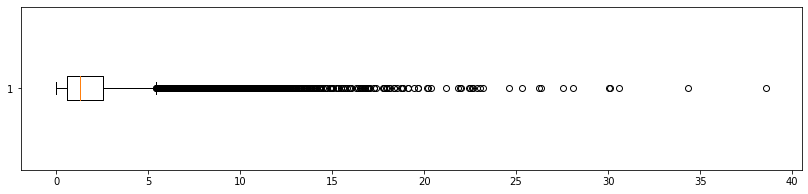

In [303]:
# show boxplot
plt.figure(figsize = (14,3))
plt.boxplot(difference, vert= False);
plt.show()

### LSTM per previsione multistep di serie multivariata

In [317]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [341]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
    
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


out_seq = np.array([series1[i]+series2[i]+series3[i] for i in range(len(series1))])

# convert to [rows, columns] structure
series1 = series1.reshape((len(series1), 1))
series2 = series2.reshape((len(series2), 1))
series3 = series3.reshape((len(series3), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = hstack((series1, series2, series3, out_seq))

# choose a number of time steps
n_steps_in, n_steps_out = 3, 3

# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

for i in range(len(X)):
    print(X[i], y[i])  

[[ 36.  43.  42. 121.]
 [ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]] [[ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]]
[[ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]] [[ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]]
[[ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]] [[ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]]
[[ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]] [[ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]
 [ 30.  34.  33.  97.]]
[[ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]] [[30. 34. 34. 98.]
 [30. 34. 33. 97.]
 [29. 33. 32. 94.]]
[[ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]] [[30. 34. 33. 97.]
 [29. 33. 32. 94.]
 [29. 32. 31. 92.]]
[[ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]
 [ 30.  34.  33.  97.]] [[29. 33. 32. 94.]
 [29. 32. 31. 92.]
 [27. 30. 29. 86.]]
[[30. 34. 34. 98.]
 [30. 34. 33. 97.]
 [29. 33. 32. 94.]

 [ 48.  56.  52. 156.]]
[[ 50.  58.  53. 161.]
 [ 49.  57.  52. 158.]
 [ 48.  56.  51. 155.]] [[ 48.  56.  51. 155.]
 [ 48.  56.  52. 156.]
 [ 47.  55.  52. 154.]]
[[ 49.  57.  52. 158.]
 [ 48.  56.  51. 155.]
 [ 48.  56.  51. 155.]] [[ 48.  56.  52. 156.]
 [ 47.  55.  52. 154.]
 [ 49.  57.  53. 159.]]
[[ 48.  56.  51. 155.]
 [ 48.  56.  51. 155.]
 [ 48.  56.  52. 156.]] [[ 47.  55.  52. 154.]
 [ 49.  57.  53. 159.]
 [ 47.  55.  51. 153.]]
[[ 48.  56.  51. 155.]
 [ 48.  56.  52. 156.]
 [ 47.  55.  52. 154.]] [[ 49.  57.  53. 159.]
 [ 47.  55.  51. 153.]
 [ 45.  52.  48. 145.]]
[[ 48.  56.  52. 156.]
 [ 47.  55.  52. 154.]
 [ 49.  57.  53. 159.]] [[ 47.  55.  51. 153.]
 [ 45.  52.  48. 145.]
 [ 44.  51.  47. 142.]]
[[ 47.  55.  52. 154.]
 [ 49.  57.  53. 159.]
 [ 47.  55.  51. 153.]] [[ 45.  52.  48. 145.]
 [ 44.  51.  47. 142.]
 [ 43.  49.  45. 137.]]
[[ 49.  57.  53. 159.]
 [ 47.  55.  51. 153.]
 [ 45.  52.  48. 145.]] [[ 44.  51.  47. 142.]
 [ 43.  49.  45. 137.]
 [ 42.  48.  44. 134

 [ 55.  63.  60. 178.]]
[[ 52.  59.  59. 170.]
 [ 52.  59.  59. 170.]
 [ 52.  59.  59. 170.]] [[ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]]
[[ 52.  59.  59. 170.]
 [ 52.  59.  59. 170.]
 [ 55.  63.  60. 178.]] [[ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]]
[[ 52.  59.  59. 170.]
 [ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]] [[ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]]
[[ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]] [[ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]]
[[ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]] [[ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]
 [ 64.  72.  67. 203.]]
[[ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]] [[ 55.  63.  60. 178.]
 [ 64.  72.  67. 203.]
 [ 64.  72.  67. 203.]]
[[ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]] [[ 64.  72.  67. 203.]
 [ 64.  72.  67. 203.]
 [ 61.  68.  66. 195

 [ 49.  55.  53. 157.]]
[[ 43.  48.  47. 138.]
 [ 43.  48.  46. 137.]
 [ 44.  49.  47. 140.]] [[ 47.  53.  51. 151.]
 [ 49.  55.  53. 157.]
 [ 49.  55.  53. 157.]]
[[ 43.  48.  46. 137.]
 [ 44.  49.  47. 140.]
 [ 47.  53.  51. 151.]] [[ 49.  55.  53. 157.]
 [ 49.  55.  53. 157.]
 [ 48.  54.  52. 154.]]
[[ 44.  49.  47. 140.]
 [ 47.  53.  51. 151.]
 [ 49.  55.  53. 157.]] [[ 49.  55.  53. 157.]
 [ 48.  54.  52. 154.]
 [ 49.  55.  53. 157.]]
[[ 47.  53.  51. 151.]
 [ 49.  55.  53. 157.]
 [ 49.  55.  53. 157.]] [[ 48.  54.  52. 154.]
 [ 49.  55.  53. 157.]
 [ 52.  58.  56. 166.]]
[[ 49.  55.  53. 157.]
 [ 49.  55.  53. 157.]
 [ 48.  54.  52. 154.]] [[ 49.  55.  53. 157.]
 [ 52.  58.  56. 166.]
 [ 51.  57.  56. 164.]]
[[ 49.  55.  53. 157.]
 [ 48.  54.  52. 154.]
 [ 49.  55.  53. 157.]] [[ 52.  58.  56. 166.]
 [ 51.  57.  56. 164.]
 [ 50.  56.  57. 163.]]
[[ 48.  54.  52. 154.]
 [ 49.  55.  53. 157.]
 [ 52.  58.  56. 166.]] [[ 51.  57.  56. 164.]
 [ 50.  56.  57. 163.]
 [ 49.  55.  55. 159

 [22. 25. 26. 73.]] [[22. 25. 27. 74.]
 [22. 26. 27. 75.]
 [22. 26. 27. 75.]]
[[22. 25. 26. 73.]
 [22. 25. 26. 73.]
 [22. 25. 27. 74.]] [[22. 26. 27. 75.]
 [22. 26. 27. 75.]
 [24. 28. 29. 81.]]
[[22. 25. 26. 73.]
 [22. 25. 27. 74.]
 [22. 26. 27. 75.]] [[22. 26. 27. 75.]
 [24. 28. 29. 81.]
 [25. 28. 30. 83.]]
[[22. 25. 27. 74.]
 [22. 26. 27. 75.]
 [22. 26. 27. 75.]] [[24. 28. 29. 81.]
 [25. 28. 30. 83.]
 [25. 28. 30. 83.]]
[[22. 26. 27. 75.]
 [22. 26. 27. 75.]
 [24. 28. 29. 81.]] [[25. 28. 30. 83.]
 [25. 28. 30. 83.]
 [27. 31. 31. 89.]]
[[22. 26. 27. 75.]
 [24. 28. 29. 81.]
 [25. 28. 30. 83.]] [[25. 28. 30. 83.]
 [27. 31. 31. 89.]
 [29. 33. 33. 95.]]
[[24. 28. 29. 81.]
 [25. 28. 30. 83.]
 [25. 28. 30. 83.]] [[27. 31. 31. 89.]
 [29. 33. 33. 95.]
 [29. 33. 34. 96.]]
[[25. 28. 30. 83.]
 [25. 28. 30. 83.]
 [27. 31. 31. 89.]] [[29. 33. 33. 95.]
 [29. 33. 34. 96.]
 [28. 33. 33. 94.]]
[[25. 28. 30. 83.]
 [27. 31. 31. 89.]
 [29. 33. 33. 95.]] [[29. 33. 34. 96.]
 [28. 33. 33. 94.]
 [28. 32. 32. 

 [26. 29. 27. 82.]] [[25. 27. 26. 78.]
 [24. 27. 26. 77.]
 [23. 26. 25. 74.]]
[[28. 31. 28. 87.]
 [26. 29. 27. 82.]
 [25. 27. 26. 78.]] [[24. 27. 26. 77.]
 [23. 26. 25. 74.]
 [23. 25. 24. 72.]]
[[26. 29. 27. 82.]
 [25. 27. 26. 78.]
 [24. 27. 26. 77.]] [[23. 26. 25. 74.]
 [23. 25. 24. 72.]
 [22. 25. 24. 71.]]
[[25. 27. 26. 78.]
 [24. 27. 26. 77.]
 [23. 26. 25. 74.]] [[23. 25. 24. 72.]
 [22. 25. 24. 71.]
 [22. 24. 23. 69.]]
[[24. 27. 26. 77.]
 [23. 26. 25. 74.]
 [23. 25. 24. 72.]] [[22. 25. 24. 71.]
 [22. 24. 23. 69.]
 [21. 23. 23. 67.]]
[[23. 26. 25. 74.]
 [23. 25. 24. 72.]
 [22. 25. 24. 71.]] [[22. 24. 23. 69.]
 [21. 23. 23. 67.]
 [20. 22. 24. 66.]]
[[23. 25. 24. 72.]
 [22. 25. 24. 71.]
 [22. 24. 23. 69.]] [[21. 23. 23. 67.]
 [20. 22. 24. 66.]
 [20. 22. 24. 66.]]
[[22. 25. 24. 71.]
 [22. 24. 23. 69.]
 [21. 23. 23. 67.]] [[20. 22. 24. 66.]
 [20. 22. 24. 66.]
 [19. 22. 25. 66.]]
[[22. 24. 23. 69.]
 [21. 23. 23. 67.]
 [20. 22. 24. 66.]] [[20. 22. 24. 66.]
 [19. 22. 25. 66.]
 [19. 22. 25. 

 [ 62.  70.  68. 200.]] [[ 63.  71.  69. 203.]
 [ 63.  70.  69. 202.]
 [ 63.  70.  67. 200.]]
[[ 63.  71.  70. 204.]
 [ 62.  70.  68. 200.]
 [ 63.  71.  69. 203.]] [[ 63.  70.  69. 202.]
 [ 63.  70.  67. 200.]
 [ 61.  68.  65. 194.]]
[[ 62.  70.  68. 200.]
 [ 63.  71.  69. 203.]
 [ 63.  70.  69. 202.]] [[ 63.  70.  67. 200.]
 [ 61.  68.  65. 194.]
 [ 60.  66.  63. 189.]]
[[ 63.  71.  69. 203.]
 [ 63.  70.  69. 202.]
 [ 63.  70.  67. 200.]] [[ 61.  68.  65. 194.]
 [ 60.  66.  63. 189.]
 [ 58.  65.  62. 185.]]
[[ 63.  70.  69. 202.]
 [ 63.  70.  67. 200.]
 [ 61.  68.  65. 194.]] [[ 60.  66.  63. 189.]
 [ 58.  65.  62. 185.]
 [ 57.  64.  61. 182.]]
[[ 63.  70.  67. 200.]
 [ 61.  68.  65. 194.]
 [ 60.  66.  63. 189.]] [[ 58.  65.  62. 185.]
 [ 57.  64.  61. 182.]
 [ 55.  62.  60. 177.]]
[[ 61.  68.  65. 194.]
 [ 60.  66.  63. 189.]
 [ 58.  65.  62. 185.]] [[ 57.  64.  61. 182.]
 [ 55.  62.  60. 177.]
 [ 54.  60.  58. 172.]]
[[ 60.  66.  63. 189.]
 [ 58.  65.  62. 185.]
 [ 57.  64.  61. 182

 [ 55.  63.  59. 177.]] [[ 56.  64.  59. 179.]
 [ 56.  64.  60. 180.]
 [ 58.  66.  62. 186.]]
[[ 55.  63.  59. 177.]
 [ 55.  63.  59. 177.]
 [ 56.  64.  59. 179.]] [[ 56.  64.  60. 180.]
 [ 58.  66.  62. 186.]
 [ 61.  69.  65. 195.]]
[[ 55.  63.  59. 177.]
 [ 56.  64.  59. 179.]
 [ 56.  64.  60. 180.]] [[ 58.  66.  62. 186.]
 [ 61.  69.  65. 195.]
 [ 63.  71.  66. 200.]]
[[ 56.  64.  59. 179.]
 [ 56.  64.  60. 180.]
 [ 58.  66.  62. 186.]] [[ 61.  69.  65. 195.]
 [ 63.  71.  66. 200.]
 [ 63.  71.  66. 200.]]
[[ 56.  64.  60. 180.]
 [ 58.  66.  62. 186.]
 [ 61.  69.  65. 195.]] [[ 63.  71.  66. 200.]
 [ 63.  71.  66. 200.]
 [ 63.  71.  66. 200.]]
[[ 58.  66.  62. 186.]
 [ 61.  69.  65. 195.]
 [ 63.  71.  66. 200.]] [[ 63.  71.  66. 200.]
 [ 63.  71.  66. 200.]
 [ 63.  71.  66. 200.]]
[[ 61.  69.  65. 195.]
 [ 63.  71.  66. 200.]
 [ 63.  71.  66. 200.]] [[ 63.  71.  66. 200.]
 [ 63.  71.  66. 200.]
 [ 63.  70.  66. 199.]]
[[ 63.  71.  66. 200.]
 [ 63.  71.  66. 200.]
 [ 63.  71.  66. 200

 [ 47.  54.  54. 155.]]
[[ 46.  52.  54. 152.]
 [ 46.  53.  53. 152.]
 [ 47.  54.  55. 156.]] [[ 47.  54.  55. 156.]
 [ 47.  54.  54. 155.]
 [ 50.  56.  55. 161.]]
[[ 46.  53.  53. 152.]
 [ 47.  54.  55. 156.]
 [ 47.  54.  55. 156.]] [[ 47.  54.  54. 155.]
 [ 50.  56.  55. 161.]
 [ 50.  56.  55. 161.]]
[[ 47.  54.  55. 156.]
 [ 47.  54.  55. 156.]
 [ 47.  54.  54. 155.]] [[ 50.  56.  55. 161.]
 [ 50.  56.  55. 161.]
 [ 58.  65.  60. 183.]]
[[ 47.  54.  55. 156.]
 [ 47.  54.  54. 155.]
 [ 50.  56.  55. 161.]] [[ 50.  56.  55. 161.]
 [ 58.  65.  60. 183.]
 [ 59.  66.  63. 188.]]
[[ 47.  54.  54. 155.]
 [ 50.  56.  55. 161.]
 [ 50.  56.  55. 161.]] [[ 58.  65.  60. 183.]
 [ 59.  66.  63. 188.]
 [ 58.  65.  62. 185.]]
[[ 50.  56.  55. 161.]
 [ 50.  56.  55. 161.]
 [ 58.  65.  60. 183.]] [[ 59.  66.  63. 188.]
 [ 58.  65.  62. 185.]
 [ 58.  65.  62. 185.]]
[[ 50.  56.  55. 161.]
 [ 58.  65.  60. 183.]
 [ 59.  66.  63. 188.]] [[ 58.  65.  62. 185.]
 [ 58.  65.  62. 185.]
 [ 58.  65.  62. 185

 [28. 31. 30. 89.]] [[28. 31. 30. 89.]
 [26. 29. 28. 83.]
 [28. 31. 29. 88.]]
[[29. 31. 29. 89.]
 [28. 31. 30. 89.]
 [28. 31. 30. 89.]] [[26. 29. 28. 83.]
 [28. 31. 29. 88.]
 [29. 32. 30. 91.]]
[[28. 31. 30. 89.]
 [28. 31. 30. 89.]
 [26. 29. 28. 83.]] [[28. 31. 29. 88.]
 [29. 32. 30. 91.]
 [30. 34. 32. 96.]]
[[28. 31. 30. 89.]
 [26. 29. 28. 83.]
 [28. 31. 29. 88.]] [[29. 32. 30. 91.]
 [30. 34. 32. 96.]
 [31. 34. 33. 98.]]
[[26. 29. 28. 83.]
 [28. 31. 29. 88.]
 [29. 32. 30. 91.]] [[ 30.  34.  32.  96.]
 [ 31.  34.  33.  98.]
 [ 34.  37.  35. 106.]]
[[28. 31. 29. 88.]
 [29. 32. 30. 91.]
 [30. 34. 32. 96.]] [[ 31.  34.  33.  98.]
 [ 34.  37.  35. 106.]
 [ 34.  38.  36. 108.]]
[[29. 32. 30. 91.]
 [30. 34. 32. 96.]
 [31. 34. 33. 98.]] [[ 34.  37.  35. 106.]
 [ 34.  38.  36. 108.]
 [ 36.  40.  38. 114.]]
[[ 30.  34.  32.  96.]
 [ 31.  34.  33.  98.]
 [ 34.  37.  35. 106.]] [[ 34.  38.  36. 108.]
 [ 36.  40.  38. 114.]
 [ 39.  43.  39. 121.]]
[[ 31.  34.  33.  98.]
 [ 34.  37.  35. 106.]
 [ 3

 [28. 31. 29. 88.]]
[[ 33.  36.  34. 103.]
 [ 33.  36.  34. 103.]
 [ 30.  34.  31.  95.]] [[29. 32. 30. 91.]
 [28. 31. 29. 88.]
 [28. 30. 28. 86.]]
[[ 33.  36.  34. 103.]
 [ 30.  34.  31.  95.]
 [ 29.  32.  30.  91.]] [[28. 31. 29. 88.]
 [28. 30. 28. 86.]
 [27. 30. 27. 84.]]
[[30. 34. 31. 95.]
 [29. 32. 30. 91.]
 [28. 31. 29. 88.]] [[28. 30. 28. 86.]
 [27. 30. 27. 84.]
 [26. 29. 26. 81.]]
[[29. 32. 30. 91.]
 [28. 31. 29. 88.]
 [28. 30. 28. 86.]] [[27. 30. 27. 84.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]]
[[28. 31. 29. 88.]
 [28. 30. 28. 86.]
 [27. 30. 27. 84.]] [[26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]]
[[28. 30. 28. 86.]
 [27. 30. 27. 84.]
 [26. 29. 26. 81.]] [[26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [24. 26. 25. 75.]]
[[27. 30. 27. 84.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]] [[26. 29. 26. 81.]
 [24. 26. 25. 75.]
 [24. 27. 25. 76.]]
[[26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]] [[24. 26. 25. 75.]
 [24. 27. 25. 76.]
 [24. 26. 26. 76.]]
[[26. 29. 26. 81.]
 [26. 29.

 [ 47.  52.  48. 147.]] [[ 46.  52.  48. 146.]
 [ 46.  51.  47. 144.]
 [ 46.  51.  48. 145.]]
[[ 48.  53.  49. 150.]
 [ 47.  52.  48. 147.]
 [ 46.  52.  48. 146.]] [[ 46.  51.  47. 144.]
 [ 46.  51.  48. 145.]
 [ 46.  51.  49. 146.]]
[[ 47.  52.  48. 147.]
 [ 46.  52.  48. 146.]
 [ 46.  51.  47. 144.]] [[ 46.  51.  48. 145.]
 [ 46.  51.  49. 146.]
 [ 45.  50.  49. 144.]]
[[ 46.  52.  48. 146.]
 [ 46.  51.  47. 144.]
 [ 46.  51.  48. 145.]] [[ 46.  51.  49. 146.]
 [ 45.  50.  49. 144.]
 [ 45.  51.  48. 144.]]
[[ 46.  51.  47. 144.]
 [ 46.  51.  48. 145.]
 [ 46.  51.  49. 146.]] [[ 45.  50.  49. 144.]
 [ 45.  51.  48. 144.]
 [ 44.  49.  47. 140.]]
[[ 46.  51.  48. 145.]
 [ 46.  51.  49. 146.]
 [ 45.  50.  49. 144.]] [[ 45.  51.  48. 144.]
 [ 44.  49.  47. 140.]
 [ 42.  47.  46. 135.]]
[[ 46.  51.  49. 146.]
 [ 45.  50.  49. 144.]
 [ 45.  51.  48. 144.]] [[ 44.  49.  47. 140.]
 [ 42.  47.  46. 135.]
 [ 41.  46.  44. 131.]]
[[ 45.  50.  49. 144.]
 [ 45.  51.  48. 144.]
 [ 44.  49.  47. 140

 [ 68.  76.  69. 213.]]
[[ 69.  77.  68. 214.]
 [ 69.  77.  68. 214.]
 [ 67.  76.  68. 211.]] [[ 68.  76.  69. 213.]
 [ 68.  76.  69. 213.]
 [ 68.  77.  70. 215.]]
[[ 69.  77.  68. 214.]
 [ 67.  76.  68. 211.]
 [ 68.  76.  69. 213.]] [[ 68.  76.  69. 213.]
 [ 68.  77.  70. 215.]
 [ 70.  79.  69. 218.]]
[[ 67.  76.  68. 211.]
 [ 68.  76.  69. 213.]
 [ 68.  76.  69. 213.]] [[ 68.  77.  70. 215.]
 [ 70.  79.  69. 218.]
 [ 69.  78.  70. 217.]]
[[ 68.  76.  69. 213.]
 [ 68.  76.  69. 213.]
 [ 68.  77.  70. 215.]] [[ 70.  79.  69. 218.]
 [ 69.  78.  70. 217.]
 [ 69.  78.  70. 217.]]
[[ 68.  76.  69. 213.]
 [ 68.  77.  70. 215.]
 [ 70.  79.  69. 218.]] [[ 69.  78.  70. 217.]
 [ 69.  78.  70. 217.]
 [ 71.  79.  70. 220.]]
[[ 68.  77.  70. 215.]
 [ 70.  79.  69. 218.]
 [ 69.  78.  70. 217.]] [[ 69.  78.  70. 217.]
 [ 71.  79.  70. 220.]
 [ 70.  78.  69. 217.]]
[[ 70.  79.  69. 218.]
 [ 69.  78.  70. 217.]
 [ 69.  78.  70. 217.]] [[ 71.  79.  70. 220.]
 [ 70.  78.  69. 217.]
 [ 70.  78.  67. 215

 [ 53.  61.  53. 167.]]
[[ 48.  55.  53. 156.]
 [ 48.  55.  53. 156.]
 [ 50.  57.  52. 159.]] [[ 50.  57.  52. 159.]
 [ 53.  61.  53. 167.]
 [ 57.  65.  56. 178.]]
[[ 48.  55.  53. 156.]
 [ 50.  57.  52. 159.]
 [ 50.  57.  52. 159.]] [[ 53.  61.  53. 167.]
 [ 57.  65.  56. 178.]
 [ 59.  67.  57. 183.]]
[[ 50.  57.  52. 159.]
 [ 50.  57.  52. 159.]
 [ 53.  61.  53. 167.]] [[ 57.  65.  56. 178.]
 [ 59.  67.  57. 183.]
 [ 59.  67.  58. 184.]]
[[ 50.  57.  52. 159.]
 [ 53.  61.  53. 167.]
 [ 57.  65.  56. 178.]] [[ 59.  67.  57. 183.]
 [ 59.  67.  58. 184.]
 [ 60.  68.  58. 186.]]
[[ 53.  61.  53. 167.]
 [ 57.  65.  56. 178.]
 [ 59.  67.  57. 183.]] [[ 59.  67.  58. 184.]
 [ 60.  68.  58. 186.]
 [ 61.  69.  59. 189.]]
[[ 57.  65.  56. 178.]
 [ 59.  67.  57. 183.]
 [ 59.  67.  58. 184.]] [[ 60.  68.  58. 186.]
 [ 61.  69.  59. 189.]
 [ 61.  69.  59. 189.]]
[[ 59.  67.  57. 183.]
 [ 59.  67.  58. 184.]
 [ 60.  68.  58. 186.]] [[ 61.  69.  59. 189.]
 [ 61.  69.  59. 189.]
 [ 60.  68.  61. 189

 [27. 31. 29. 87.]] [[27. 30. 29. 86.]
 [26. 29. 29. 84.]
 [25. 28. 29. 82.]]
[[27. 30. 28. 85.]
 [27. 31. 29. 87.]
 [27. 30. 29. 86.]] [[26. 29. 29. 84.]
 [25. 28. 29. 82.]
 [25. 28. 29. 82.]]
[[27. 31. 29. 87.]
 [27. 30. 29. 86.]
 [26. 29. 29. 84.]] [[25. 28. 29. 82.]
 [25. 28. 29. 82.]
 [28. 31. 31. 90.]]
[[27. 30. 29. 86.]
 [26. 29. 29. 84.]
 [25. 28. 29. 82.]] [[25. 28. 29. 82.]
 [28. 31. 31. 90.]
 [29. 33. 33. 95.]]
[[26. 29. 29. 84.]
 [25. 28. 29. 82.]
 [25. 28. 29. 82.]] [[28. 31. 31. 90.]
 [29. 33. 33. 95.]
 [30. 34. 34. 98.]]
[[25. 28. 29. 82.]
 [25. 28. 29. 82.]
 [28. 31. 31. 90.]] [[ 29.  33.  33.  95.]
 [ 30.  34.  34.  98.]
 [ 33.  37.  35. 105.]]
[[25. 28. 29. 82.]
 [28. 31. 31. 90.]
 [29. 33. 33. 95.]] [[ 30.  34.  34.  98.]
 [ 33.  37.  35. 105.]
 [ 35.  39.  34. 108.]]
[[28. 31. 31. 90.]
 [29. 33. 33. 95.]
 [30. 34. 34. 98.]] [[ 33.  37.  35. 105.]
 [ 35.  39.  34. 108.]
 [ 35.  39.  34. 108.]]
[[ 29.  33.  33.  95.]
 [ 30.  34.  34.  98.]
 [ 33.  37.  35. 105.]] [[ 3

 [ 34.  39.  37. 110.]] [[ 34.  39.  37. 110.]
 [ 34.  39.  37. 110.]
 [ 30.  34.  33.  97.]]
[[ 36.  41.  38. 115.]
 [ 34.  39.  37. 110.]
 [ 34.  39.  37. 110.]] [[ 34.  39.  37. 110.]
 [ 30.  34.  33.  97.]
 [ 30.  34.  33.  97.]]
[[ 34.  39.  37. 110.]
 [ 34.  39.  37. 110.]
 [ 34.  39.  37. 110.]] [[30. 34. 33. 97.]
 [30. 34. 33. 97.]
 [28. 32. 31. 91.]]
[[ 34.  39.  37. 110.]
 [ 34.  39.  37. 110.]
 [ 30.  34.  33.  97.]] [[30. 34. 33. 97.]
 [28. 32. 31. 91.]
 [27. 31. 30. 88.]]
[[ 34.  39.  37. 110.]
 [ 30.  34.  33.  97.]
 [ 30.  34.  33.  97.]] [[28. 32. 31. 91.]
 [27. 31. 30. 88.]
 [27. 31. 30. 88.]]
[[30. 34. 33. 97.]
 [30. 34. 33. 97.]
 [28. 32. 31. 91.]] [[27. 31. 30. 88.]
 [27. 31. 30. 88.]
 [25. 29. 27. 81.]]
[[30. 34. 33. 97.]
 [28. 32. 31. 91.]
 [27. 31. 30. 88.]] [[27. 31. 30. 88.]
 [25. 29. 27. 81.]
 [24. 28. 26. 78.]]
[[28. 32. 31. 91.]
 [27. 31. 30. 88.]
 [27. 31. 30. 88.]] [[25. 29. 27. 81.]
 [24. 28. 26. 78.]
 [23. 27. 25. 75.]]
[[27. 31. 30. 88.]
 [27. 31. 30. 8

 [ 65.  74.  63. 202.]] [[ 65.  73.  62. 200.]
 [ 65.  73.  62. 200.]
 [ 65.  72.  62. 199.]]
[[ 71.  79.  66. 216.]
 [ 65.  74.  63. 202.]
 [ 65.  73.  62. 200.]] [[ 65.  73.  62. 200.]
 [ 65.  72.  62. 199.]
 [ 67.  75.  63. 205.]]
[[ 65.  74.  63. 202.]
 [ 65.  73.  62. 200.]
 [ 65.  73.  62. 200.]] [[ 65.  72.  62. 199.]
 [ 67.  75.  63. 205.]
 [ 66.  73.  62. 201.]]
[[ 65.  73.  62. 200.]
 [ 65.  73.  62. 200.]
 [ 65.  72.  62. 199.]] [[ 67.  75.  63. 205.]
 [ 66.  73.  62. 201.]
 [ 66.  73.  62. 201.]]
[[ 65.  73.  62. 200.]
 [ 65.  72.  62. 199.]
 [ 67.  75.  63. 205.]] [[ 66.  73.  62. 201.]
 [ 66.  73.  62. 201.]
 [ 62.  70.  57. 189.]]
[[ 65.  72.  62. 199.]
 [ 67.  75.  63. 205.]
 [ 66.  73.  62. 201.]] [[ 66.  73.  62. 201.]
 [ 62.  70.  57. 189.]
 [ 61.  67.  55. 183.]]
[[ 67.  75.  63. 205.]
 [ 66.  73.  62. 201.]
 [ 66.  73.  62. 201.]] [[ 62.  70.  57. 189.]
 [ 61.  67.  55. 183.]
 [ 59.  66.  55. 180.]]
[[ 66.  73.  62. 201.]
 [ 66.  73.  62. 201.]
 [ 62.  70.  57. 189

 [ 55.  61.  52. 168.]] [[ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]]
[[ 56.  62.  51. 169.]
 [ 55.  61.  52. 168.]
 [ 55.  61.  51. 167.]] [[ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]
 [ 56.  62.  53. 171.]]
[[ 55.  61.  52. 168.]
 [ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]] [[ 55.  61.  51. 167.]
 [ 56.  62.  53. 171.]
 [ 56.  62.  53. 171.]]
[[ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]] [[ 56.  62.  53. 171.]
 [ 56.  62.  53. 171.]
 [ 58.  65.  53. 176.]]
[[ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]
 [ 56.  62.  53. 171.]] [[ 56.  62.  53. 171.]
 [ 58.  65.  53. 176.]
 [ 59.  66.  53. 178.]]
[[ 55.  61.  51. 167.]
 [ 56.  62.  53. 171.]
 [ 56.  62.  53. 171.]] [[ 58.  65.  53. 176.]
 [ 59.  66.  53. 178.]
 [ 60.  66.  54. 180.]]
[[ 56.  62.  53. 171.]
 [ 56.  62.  53. 171.]
 [ 58.  65.  53. 176.]] [[ 59.  66.  53. 178.]
 [ 60.  66.  54. 180.]
 [ 60.  66.  54. 180.]]
[[ 56.  62.  53. 171.]
 [ 58.  65.  53. 176.]
 [ 59.  66.  53. 178

 [30. 33. 28. 91.]]
[[31. 34. 27. 92.]
 [31. 34. 28. 93.]
 [31. 34. 28. 93.]] [[31. 34. 29. 94.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]]
[[31. 34. 28. 93.]
 [31. 34. 28. 93.]
 [31. 34. 29. 94.]] [[30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [32. 36. 30. 98.]]
[[31. 34. 28. 93.]
 [31. 34. 29. 94.]
 [30. 33. 28. 91.]] [[ 30.  33.  28.  91.]
 [ 32.  36.  30.  98.]
 [ 33.  37.  30. 100.]]
[[31. 34. 29. 94.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]] [[ 32.  36.  30.  98.]
 [ 33.  37.  30. 100.]
 [ 33.  37.  31. 101.]]
[[30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [32. 36. 30. 98.]] [[ 33.  37.  30. 100.]
 [ 33.  37.  31. 101.]
 [ 36.  40.  33. 109.]]
[[ 30.  33.  28.  91.]
 [ 32.  36.  30.  98.]
 [ 33.  37.  30. 100.]] [[ 33.  37.  31. 101.]
 [ 36.  40.  33. 109.]
 [ 39.  44.  36. 119.]]
[[ 32.  36.  30.  98.]
 [ 33.  37.  30. 100.]
 [ 33.  37.  31. 101.]] [[ 36.  40.  33. 109.]
 [ 39.  44.  36. 119.]
 [ 40.  45.  37. 122.]]
[[ 33.  37.  30. 100.]
 [ 33.  37.  31. 101.]
 [ 36.  40.  33. 109.]] [[ 39.  44.  3

 [ 37.  41.  34. 112.]]
[[ 40.  44.  36. 120.]
 [ 39.  43.  35. 117.]
 [ 39.  43.  35. 117.]] [[ 37.  41.  34. 112.]
 [ 37.  41.  34. 112.]
 [ 36.  39.  32. 107.]]
[[ 39.  43.  35. 117.]
 [ 39.  43.  35. 117.]
 [ 37.  41.  34. 112.]] [[ 37.  41.  34. 112.]
 [ 36.  39.  32. 107.]
 [ 36.  39.  32. 107.]]
[[ 39.  43.  35. 117.]
 [ 37.  41.  34. 112.]
 [ 37.  41.  34. 112.]] [[ 36.  39.  32. 107.]
 [ 36.  39.  32. 107.]
 [ 33.  36.  30.  99.]]
[[ 37.  41.  34. 112.]
 [ 37.  41.  34. 112.]
 [ 36.  39.  32. 107.]] [[ 36.  39.  32. 107.]
 [ 33.  36.  30.  99.]
 [ 33.  36.  30.  99.]]
[[ 37.  41.  34. 112.]
 [ 36.  39.  32. 107.]
 [ 36.  39.  32. 107.]] [[33. 36. 30. 99.]
 [33. 36. 30. 99.]
 [33. 36. 30. 99.]]
[[ 36.  39.  32. 107.]
 [ 36.  39.  32. 107.]
 [ 33.  36.  30.  99.]] [[33. 36. 30. 99.]
 [33. 36. 30. 99.]
 [31. 34. 28. 93.]]
[[ 36.  39.  32. 107.]
 [ 33.  36.  30.  99.]
 [ 33.  36.  30.  99.]] [[33. 36. 30. 99.]
 [31. 34. 28. 93.]
 [31. 34. 28. 93.]]
[[33. 36. 30. 99.]
 [33. 36. 30.

 [ 54.  60.  50. 164.]] [[ 54.  60.  50. 164.]
 [ 50.  56.  48. 154.]
 [ 49.  55.  47. 151.]]
[[ 57.  63.  52. 172.]
 [ 54.  60.  50. 164.]
 [ 54.  60.  50. 164.]] [[ 50.  56.  48. 154.]
 [ 49.  55.  47. 151.]
 [ 48.  54.  47. 149.]]
[[ 54.  60.  50. 164.]
 [ 54.  60.  50. 164.]
 [ 50.  56.  48. 154.]] [[ 49.  55.  47. 151.]
 [ 48.  54.  47. 149.]
 [ 47.  52.  46. 145.]]
[[ 54.  60.  50. 164.]
 [ 50.  56.  48. 154.]
 [ 49.  55.  47. 151.]] [[ 48.  54.  47. 149.]
 [ 47.  52.  46. 145.]
 [ 46.  52.  45. 143.]]
[[ 50.  56.  48. 154.]
 [ 49.  55.  47. 151.]
 [ 48.  54.  47. 149.]] [[ 47.  52.  46. 145.]
 [ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]]
[[ 49.  55.  47. 151.]
 [ 48.  54.  47. 149.]
 [ 47.  52.  46. 145.]] [[ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]
 [ 48.  53.  45. 146.]]
[[ 48.  54.  47. 149.]
 [ 47.  52.  46. 145.]
 [ 46.  52.  45. 143.]] [[ 46.  52.  45. 143.]
 [ 48.  53.  45. 146.]
 [ 46.  51.  44. 141.]]
[[ 47.  52.  46. 145.]
 [ 46.  52.  45. 143.]
 [ 46.  52.  45. 143

 [ 61.  68.  62. 191.]] [[ 62.  69.  62. 193.]
 [ 63.  70.  63. 196.]
 [ 63.  71.  62. 196.]]
[[ 61.  68.  62. 191.]
 [ 61.  68.  62. 191.]
 [ 62.  69.  62. 193.]] [[ 63.  70.  63. 196.]
 [ 63.  71.  62. 196.]
 [ 66.  73.  64. 203.]]
[[ 61.  68.  62. 191.]
 [ 62.  69.  62. 193.]
 [ 63.  70.  63. 196.]] [[ 63.  71.  62. 196.]
 [ 66.  73.  64. 203.]
 [ 68.  76.  66. 210.]]
[[ 62.  69.  62. 193.]
 [ 63.  70.  63. 196.]
 [ 63.  71.  62. 196.]] [[ 66.  73.  64. 203.]
 [ 68.  76.  66. 210.]
 [ 68.  76.  66. 210.]]
[[ 63.  70.  63. 196.]
 [ 63.  71.  62. 196.]
 [ 66.  73.  64. 203.]] [[ 68.  76.  66. 210.]
 [ 68.  76.  66. 210.]
 [ 68.  76.  69. 213.]]
[[ 63.  71.  62. 196.]
 [ 66.  73.  64. 203.]
 [ 68.  76.  66. 210.]] [[ 68.  76.  66. 210.]
 [ 68.  76.  69. 213.]
 [ 68.  76.  69. 213.]]
[[ 66.  73.  64. 203.]
 [ 68.  76.  66. 210.]
 [ 68.  76.  66. 210.]] [[ 68.  76.  69. 213.]
 [ 68.  76.  69. 213.]
 [ 70.  77.  69. 216.]]
[[ 68.  76.  66. 210.]
 [ 68.  76.  66. 210.]
 [ 68.  76.  69. 213

 [ 47.  53.  44. 144.]]
[[ 40.  44.  36. 120.]
 [ 40.  44.  36. 120.]
 [ 46.  51.  42. 139.]] [[ 49.  55.  44. 148.]
 [ 47.  53.  44. 144.]
 [ 47.  52.  44. 143.]]
[[ 40.  44.  36. 120.]
 [ 46.  51.  42. 139.]
 [ 49.  55.  44. 148.]] [[ 47.  53.  44. 144.]
 [ 47.  52.  44. 143.]
 [ 48.  54.  44. 146.]]
[[ 46.  51.  42. 139.]
 [ 49.  55.  44. 148.]
 [ 47.  53.  44. 144.]] [[ 47.  52.  44. 143.]
 [ 48.  54.  44. 146.]
 [ 49.  56.  45. 150.]]
[[ 49.  55.  44. 148.]
 [ 47.  53.  44. 144.]
 [ 47.  52.  44. 143.]] [[ 48.  54.  44. 146.]
 [ 49.  56.  45. 150.]
 [ 50.  56.  44. 150.]]
[[ 47.  53.  44. 144.]
 [ 47.  52.  44. 143.]
 [ 48.  54.  44. 146.]] [[ 49.  56.  45. 150.]
 [ 50.  56.  44. 150.]
 [ 51.  57.  44. 152.]]
[[ 47.  52.  44. 143.]
 [ 48.  54.  44. 146.]
 [ 49.  56.  45. 150.]] [[ 50.  56.  44. 150.]
 [ 51.  57.  44. 152.]
 [ 54.  60.  46. 160.]]
[[ 48.  54.  44. 146.]
 [ 49.  56.  45. 150.]
 [ 50.  56.  44. 150.]] [[ 51.  57.  44. 152.]
 [ 54.  60.  46. 160.]
 [ 54.  60.  46. 160

 [30. 33. 28. 91.]]
[[28. 32. 27. 87.]
 [28. 32. 27. 87.]
 [28. 32. 27. 87.]] [[30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]]
[[28. 32. 27. 87.]
 [28. 32. 27. 87.]
 [30. 33. 28. 91.]] [[30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [29. 32. 26. 87.]]
[[28. 32. 27. 87.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]] [[30. 33. 28. 91.]
 [29. 32. 26. 87.]
 [28. 32. 26. 86.]]
[[30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]] [[29. 32. 26. 87.]
 [28. 32. 26. 86.]
 [28. 31. 27. 86.]]
[[30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [29. 32. 26. 87.]] [[28. 32. 26. 86.]
 [28. 31. 27. 86.]
 [27. 31. 27. 85.]]
[[30. 33. 28. 91.]
 [29. 32. 26. 87.]
 [28. 32. 26. 86.]] [[28. 31. 27. 86.]
 [27. 31. 27. 85.]
 [27. 30. 26. 83.]]
[[29. 32. 26. 87.]
 [28. 32. 26. 86.]
 [28. 31. 27. 86.]] [[27. 31. 27. 85.]
 [27. 30. 26. 83.]
 [27. 31. 26. 84.]]
[[28. 32. 26. 86.]
 [28. 31. 27. 86.]
 [27. 31. 27. 85.]] [[27. 30. 26. 83.]
 [27. 31. 26. 84.]
 [29. 32. 27. 88.]]
[[28. 31. 27. 86.]
 [27. 31. 27. 85.]
 [27. 30. 26. 

 [ 41.  45.  24. 110.]] [[ 41.  44.  23. 108.]
 [ 40.  43.  23. 106.]
 [ 39.  42.  23. 104.]]
[[ 42.  46.  24. 112.]
 [ 41.  45.  24. 110.]
 [ 41.  44.  23. 108.]] [[ 40.  43.  23. 106.]
 [ 39.  42.  23. 104.]
 [ 39.  42.  22. 103.]]
[[ 41.  45.  24. 110.]
 [ 41.  44.  23. 108.]
 [ 40.  43.  23. 106.]] [[ 39.  42.  23. 104.]
 [ 39.  42.  22. 103.]
 [ 37.  40.  22.  99.]]
[[ 41.  44.  23. 108.]
 [ 40.  43.  23. 106.]
 [ 39.  42.  23. 104.]] [[ 39.  42.  22. 103.]
 [ 37.  40.  22.  99.]
 [ 36.  40.  22.  98.]]
[[ 40.  43.  23. 106.]
 [ 39.  42.  23. 104.]
 [ 39.  42.  22. 103.]] [[37. 40. 22. 99.]
 [36. 40. 22. 98.]
 [35. 39. 22. 96.]]
[[ 39.  42.  23. 104.]
 [ 39.  42.  22. 103.]
 [ 37.  40.  22.  99.]] [[36. 40. 22. 98.]
 [35. 39. 22. 96.]
 [35. 38. 22. 95.]]
[[ 39.  42.  22. 103.]
 [ 37.  40.  22.  99.]
 [ 36.  40.  22.  98.]] [[35. 39. 22. 96.]
 [35. 38. 22. 95.]
 [34. 39. 21. 94.]]
[[37. 40. 22. 99.]
 [36. 40. 22. 98.]
 [35. 39. 22. 96.]] [[35. 38. 22. 95.]
 [34. 39. 21. 94.]
 [33. 

 [ 53.  71.  47. 171.]] [[ 53.  71.  46. 170.]
 [ 51.  68.  45. 164.]
 [ 51.  68.  45. 164.]]
[[ 52.  71.  47. 170.]
 [ 53.  71.  47. 171.]
 [ 53.  71.  46. 170.]] [[ 51.  68.  45. 164.]
 [ 51.  68.  45. 164.]
 [ 47.  65.  42. 154.]]
[[ 53.  71.  47. 171.]
 [ 53.  71.  46. 170.]
 [ 51.  68.  45. 164.]] [[ 51.  68.  45. 164.]
 [ 47.  65.  42. 154.]
 [ 47.  64.  41. 152.]]
[[ 53.  71.  46. 170.]
 [ 51.  68.  45. 164.]
 [ 51.  68.  45. 164.]] [[ 47.  65.  42. 154.]
 [ 47.  64.  41. 152.]
 [ 46.  62.  41. 149.]]
[[ 51.  68.  45. 164.]
 [ 51.  68.  45. 164.]
 [ 47.  65.  42. 154.]] [[ 47.  64.  41. 152.]
 [ 46.  62.  41. 149.]
 [ 46.  61.  40. 147.]]
[[ 51.  68.  45. 164.]
 [ 47.  65.  42. 154.]
 [ 47.  64.  41. 152.]] [[ 46.  62.  41. 149.]
 [ 46.  61.  40. 147.]
 [ 44.  58.  40. 142.]]
[[ 47.  65.  42. 154.]
 [ 47.  64.  41. 152.]
 [ 46.  62.  41. 149.]] [[ 46.  61.  40. 147.]
 [ 44.  58.  40. 142.]
 [ 43.  57.  39. 139.]]
[[ 47.  64.  41. 152.]
 [ 46.  62.  41. 149.]
 [ 46.  61.  40. 147

 [ 53.  65.  43. 161.]] [[ 55.  68.  47. 170.]
 [ 54.  65.  48. 167.]
 [ 53.  65.  50. 168.]]
[[ 53.  65.  43. 161.]
 [ 53.  65.  43. 161.]
 [ 55.  68.  47. 170.]] [[ 54.  65.  48. 167.]
 [ 53.  65.  50. 168.]
 [ 55.  67.  51. 173.]]
[[ 53.  65.  43. 161.]
 [ 55.  68.  47. 170.]
 [ 54.  65.  48. 167.]] [[ 53.  65.  50. 168.]
 [ 55.  67.  51. 173.]
 [ 58.  70.  53. 181.]]
[[ 55.  68.  47. 170.]
 [ 54.  65.  48. 167.]
 [ 53.  65.  50. 168.]] [[ 55.  67.  51. 173.]
 [ 58.  70.  53. 181.]
 [ 56.  68.  52. 176.]]
[[ 54.  65.  48. 167.]
 [ 53.  65.  50. 168.]
 [ 55.  67.  51. 173.]] [[ 58.  70.  53. 181.]
 [ 56.  68.  52. 176.]
 [ 57.  69.  51. 177.]]
[[ 53.  65.  50. 168.]
 [ 55.  67.  51. 173.]
 [ 58.  70.  53. 181.]] [[ 56.  68.  52. 176.]
 [ 57.  69.  51. 177.]
 [ 55.  67.  51. 173.]]
[[ 55.  67.  51. 173.]
 [ 58.  70.  53. 181.]
 [ 56.  68.  52. 176.]] [[ 57.  69.  51. 177.]
 [ 55.  67.  51. 173.]
 [ 57.  69.  51. 177.]]
[[ 58.  70.  53. 181.]
 [ 56.  68.  52. 176.]
 [ 57.  69.  51. 177

 [ 28.  40.  38. 106.]] [[ 28.  41.  40. 109.]
 [ 31.  44.  41. 116.]
 [ 32.  46.  43. 121.]]
[[ 26.  37.  36.  99.]
 [ 28.  40.  38. 106.]
 [ 28.  41.  40. 109.]] [[ 31.  44.  41. 116.]
 [ 32.  46.  43. 121.]
 [ 32.  46.  43. 121.]]
[[ 28.  40.  38. 106.]
 [ 28.  41.  40. 109.]
 [ 31.  44.  41. 116.]] [[ 32.  46.  43. 121.]
 [ 32.  46.  43. 121.]
 [ 32.  46.  43. 121.]]
[[ 28.  41.  40. 109.]
 [ 31.  44.  41. 116.]
 [ 32.  46.  43. 121.]] [[ 32.  46.  43. 121.]
 [ 32.  46.  43. 121.]
 [ 34.  49.  44. 127.]]
[[ 31.  44.  41. 116.]
 [ 32.  46.  43. 121.]
 [ 32.  46.  43. 121.]] [[ 32.  46.  43. 121.]
 [ 34.  49.  44. 127.]
 [ 34.  49.  45. 128.]]
[[ 32.  46.  43. 121.]
 [ 32.  46.  43. 121.]
 [ 32.  46.  43. 121.]] [[ 34.  49.  44. 127.]
 [ 34.  49.  45. 128.]
 [ 34.  49.  45. 128.]]
[[ 32.  46.  43. 121.]
 [ 32.  46.  43. 121.]
 [ 34.  49.  44. 127.]] [[ 34.  49.  45. 128.]
 [ 34.  49.  45. 128.]
 [ 34.  49.  45. 128.]]
[[ 32.  46.  43. 121.]
 [ 34.  49.  44. 127.]
 [ 34.  49.  45. 128

 [ 41.  49.  33. 123.]] [[ 40.  46.  32. 118.]
 [ 39.  44.  31. 114.]
 [ 38.  42.  30. 110.]]
[[ 44.  51.  33. 128.]
 [ 41.  49.  33. 123.]
 [ 40.  46.  32. 118.]] [[ 39.  44.  31. 114.]
 [ 38.  42.  30. 110.]
 [ 38.  41.  30. 109.]]
[[ 41.  49.  33. 123.]
 [ 40.  46.  32. 118.]
 [ 39.  44.  31. 114.]] [[ 38.  42.  30. 110.]
 [ 38.  41.  30. 109.]
 [ 38.  41.  30. 109.]]
[[ 40.  46.  32. 118.]
 [ 39.  44.  31. 114.]
 [ 38.  42.  30. 110.]] [[ 38.  41.  30. 109.]
 [ 38.  41.  30. 109.]
 [ 37.  41.  27. 105.]]
[[ 39.  44.  31. 114.]
 [ 38.  42.  30. 110.]
 [ 38.  41.  30. 109.]] [[ 38.  41.  30. 109.]
 [ 37.  41.  27. 105.]
 [ 36.  40.  26. 102.]]
[[ 38.  42.  30. 110.]
 [ 38.  41.  30. 109.]
 [ 38.  41.  30. 109.]] [[ 37.  41.  27. 105.]
 [ 36.  40.  26. 102.]
 [ 35.  39.  25.  99.]]
[[ 38.  41.  30. 109.]
 [ 38.  41.  30. 109.]
 [ 37.  41.  27. 105.]] [[ 36.  40.  26. 102.]
 [ 35.  39.  25.  99.]
 [ 35.  39.  25.  99.]]
[[ 38.  41.  30. 109.]
 [ 37.  41.  27. 105.]
 [ 36.  40.  26. 102

 [ 48.  58.  44. 150.]] [[ 48.  58.  44. 150.]
 [ 46.  55.  42. 143.]
 [ 45.  53.  41. 139.]]
[[ 50.  61.  45. 156.]
 [ 48.  58.  44. 150.]
 [ 48.  58.  44. 150.]] [[ 46.  55.  42. 143.]
 [ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]]
[[ 48.  58.  44. 150.]
 [ 48.  58.  44. 150.]
 [ 46.  55.  42. 143.]] [[ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]]
[[ 48.  58.  44. 150.]
 [ 46.  55.  42. 143.]
 [ 45.  53.  41. 139.]] [[ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]
 [ 43.  50.  40. 133.]]
[[ 46.  55.  42. 143.]
 [ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]] [[ 45.  53.  41. 139.]
 [ 43.  50.  40. 133.]
 [ 42.  49.  40. 131.]]
[[ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]] [[ 43.  50.  40. 133.]
 [ 42.  49.  40. 131.]
 [ 41.  48.  40. 129.]]
[[ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]
 [ 43.  50.  40. 133.]] [[ 42.  49.  40. 131.]
 [ 41.  48.  40. 129.]
 [ 42.  48.  40. 130.]]
[[ 45.  53.  41. 139.]
 [ 43.  50.  40. 133.]
 [ 42.  49.  40. 131

 [ 61.  76.  51. 188.]]
[[ 57.  72.  48. 177.]
 [ 57.  73.  50. 180.]
 [ 57.  73.  50. 180.]] [[ 61.  76.  51. 188.]
 [ 61.  76.  51. 188.]
 [ 60.  76.  50. 186.]]
[[ 57.  73.  50. 180.]
 [ 57.  73.  50. 180.]
 [ 61.  76.  51. 188.]] [[ 61.  76.  51. 188.]
 [ 60.  76.  50. 186.]
 [ 60.  76.  49. 185.]]
[[ 57.  73.  50. 180.]
 [ 61.  76.  51. 188.]
 [ 61.  76.  51. 188.]] [[ 60.  76.  50. 186.]
 [ 60.  76.  49. 185.]
 [ 60.  75.  48. 183.]]
[[ 61.  76.  51. 188.]
 [ 61.  76.  51. 188.]
 [ 60.  76.  50. 186.]] [[ 60.  76.  49. 185.]
 [ 60.  75.  48. 183.]
 [ 61.  76.  47. 184.]]
[[ 61.  76.  51. 188.]
 [ 60.  76.  50. 186.]
 [ 60.  76.  49. 185.]] [[ 60.  75.  48. 183.]
 [ 61.  76.  47. 184.]
 [ 61.  76.  47. 184.]]
[[ 60.  76.  50. 186.]
 [ 60.  76.  49. 185.]
 [ 60.  75.  48. 183.]] [[ 61.  76.  47. 184.]
 [ 61.  76.  47. 184.]
 [ 63.  76.  48. 187.]]
[[ 60.  76.  49. 185.]
 [ 60.  75.  48. 183.]
 [ 61.  76.  47. 184.]] [[ 61.  76.  47. 184.]
 [ 63.  76.  48. 187.]
 [ 61.  73.  48. 182

 [27. 34. 27. 88.]]
[[27. 32. 25. 84.]
 [27. 33. 24. 84.]
 [26. 33. 25. 84.]] [[26. 33. 25. 84.]
 [27. 34. 27. 88.]
 [27. 34. 29. 90.]]
[[27. 33. 24. 84.]
 [26. 33. 25. 84.]
 [26. 33. 25. 84.]] [[27. 34. 27. 88.]
 [27. 34. 29. 90.]
 [28. 33. 31. 92.]]
[[26. 33. 25. 84.]
 [26. 33. 25. 84.]
 [27. 34. 27. 88.]] [[27. 34. 29. 90.]
 [28. 33. 31. 92.]
 [28. 33. 31. 92.]]
[[26. 33. 25. 84.]
 [27. 34. 27. 88.]
 [27. 34. 29. 90.]] [[ 28.  33.  31.  92.]
 [ 28.  33.  31.  92.]
 [ 31.  39.  32. 102.]]
[[27. 34. 27. 88.]
 [27. 34. 29. 90.]
 [28. 33. 31. 92.]] [[ 28.  33.  31.  92.]
 [ 31.  39.  32. 102.]
 [ 32.  40.  33. 105.]]
[[27. 34. 29. 90.]
 [28. 33. 31. 92.]
 [28. 33. 31. 92.]] [[ 31.  39.  32. 102.]
 [ 32.  40.  33. 105.]
 [ 34.  43.  34. 111.]]
[[ 28.  33.  31.  92.]
 [ 28.  33.  31.  92.]
 [ 31.  39.  32. 102.]] [[ 32.  40.  33. 105.]
 [ 34.  43.  34. 111.]
 [ 37.  46.  34. 117.]]
[[ 28.  33.  31.  92.]
 [ 31.  39.  32. 102.]
 [ 32.  40.  33. 105.]] [[ 34.  43.  34. 111.]
 [ 37.  46.  34

 [ 45.  50.  35. 130.]] [[ 45.  50.  35. 130.]
 [ 42.  47.  34. 123.]
 [ 40.  44.  33. 117.]]
[[ 44.  49.  35. 128.]
 [ 45.  50.  35. 130.]
 [ 45.  50.  35. 130.]] [[ 42.  47.  34. 123.]
 [ 40.  44.  33. 117.]
 [ 38.  42.  31. 111.]]
[[ 45.  50.  35. 130.]
 [ 45.  50.  35. 130.]
 [ 42.  47.  34. 123.]] [[ 40.  44.  33. 117.]
 [ 38.  42.  31. 111.]
 [ 37.  40.  30. 107.]]
[[ 45.  50.  35. 130.]
 [ 42.  47.  34. 123.]
 [ 40.  44.  33. 117.]] [[ 38.  42.  31. 111.]
 [ 37.  40.  30. 107.]
 [ 35.  39.  29. 103.]]
[[ 42.  47.  34. 123.]
 [ 40.  44.  33. 117.]
 [ 38.  42.  31. 111.]] [[ 37.  40.  30. 107.]
 [ 35.  39.  29. 103.]
 [ 34.  38.  28. 100.]]
[[ 40.  44.  33. 117.]
 [ 38.  42.  31. 111.]
 [ 37.  40.  30. 107.]] [[ 35.  39.  29. 103.]
 [ 34.  38.  28. 100.]
 [ 34.  37.  27.  98.]]
[[ 38.  42.  31. 111.]
 [ 37.  40.  30. 107.]
 [ 35.  39.  29. 103.]] [[ 34.  38.  28. 100.]
 [ 34.  37.  27.  98.]
 [ 33.  36.  26.  95.]]
[[ 37.  40.  30. 107.]
 [ 35.  39.  29. 103.]
 [ 34.  38.  28. 100

 [ 66.  79.  50. 195.]] [[ 65.  78.  49. 192.]
 [ 64.  77.  48. 189.]
 [ 61.  75.  47. 183.]]
[[ 67.  81.  52. 200.]
 [ 66.  79.  50. 195.]
 [ 65.  78.  49. 192.]] [[ 64.  77.  48. 189.]
 [ 61.  75.  47. 183.]
 [ 61.  74.  46. 181.]]
[[ 66.  79.  50. 195.]
 [ 65.  78.  49. 192.]
 [ 64.  77.  48. 189.]] [[ 61.  75.  47. 183.]
 [ 61.  74.  46. 181.]
 [ 60.  72.  46. 178.]]
[[ 65.  78.  49. 192.]
 [ 64.  77.  48. 189.]
 [ 61.  75.  47. 183.]] [[ 61.  74.  46. 181.]
 [ 60.  72.  46. 178.]
 [ 59.  71.  44. 174.]]
[[ 64.  77.  48. 189.]
 [ 61.  75.  47. 183.]
 [ 61.  74.  46. 181.]] [[ 60.  72.  46. 178.]
 [ 59.  71.  44. 174.]
 [ 57.  68.  43. 168.]]
[[ 61.  75.  47. 183.]
 [ 61.  74.  46. 181.]
 [ 60.  72.  46. 178.]] [[ 59.  71.  44. 174.]
 [ 57.  68.  43. 168.]
 [ 59.  70.  43. 172.]]
[[ 61.  74.  46. 181.]
 [ 60.  72.  46. 178.]
 [ 59.  71.  44. 174.]] [[ 57.  68.  43. 168.]
 [ 59.  70.  43. 172.]
 [ 59.  70.  43. 172.]]
[[ 60.  72.  46. 178.]
 [ 59.  71.  44. 174.]
 [ 57.  68.  43. 168

 [ 39.  49.  37. 125.]]
[[ 40.  50.  36. 126.]
 [ 39.  49.  37. 125.]
 [ 38.  48.  38. 124.]] [[ 39.  49.  38. 126.]
 [ 39.  49.  37. 125.]
 [ 39.  50.  37. 126.]]
[[ 39.  49.  37. 125.]
 [ 38.  48.  38. 124.]
 [ 39.  49.  38. 126.]] [[ 39.  49.  37. 125.]
 [ 39.  50.  37. 126.]
 [ 40.  51.  37. 128.]]
[[ 38.  48.  38. 124.]
 [ 39.  49.  38. 126.]
 [ 39.  49.  37. 125.]] [[ 39.  50.  37. 126.]
 [ 40.  51.  37. 128.]
 [ 40.  51.  37. 128.]]
[[ 39.  49.  38. 126.]
 [ 39.  49.  37. 125.]
 [ 39.  50.  37. 126.]] [[ 40.  51.  37. 128.]
 [ 40.  51.  37. 128.]
 [ 40.  51.  37. 128.]]
[[ 39.  49.  37. 125.]
 [ 39.  50.  37. 126.]
 [ 40.  51.  37. 128.]] [[ 40.  51.  37. 128.]
 [ 40.  51.  37. 128.]
 [ 43.  54.  38. 135.]]
[[ 39.  50.  37. 126.]
 [ 40.  51.  37. 128.]
 [ 40.  51.  37. 128.]] [[ 40.  51.  37. 128.]
 [ 43.  54.  38. 135.]
 [ 43.  53.  39. 135.]]
[[ 40.  51.  37. 128.]
 [ 40.  51.  37. 128.]
 [ 40.  51.  37. 128.]] [[ 43.  54.  38. 135.]
 [ 43.  53.  39. 135.]
 [ 43.  53.  38. 134

 [29. 32. 25. 86.]]
[[30. 33. 27. 90.]
 [30. 33. 26. 89.]
 [30. 32. 26. 88.]] [[29. 32. 25. 86.]
 [29. 32. 25. 86.]
 [28. 32. 25. 85.]]
[[30. 33. 26. 89.]
 [30. 32. 26. 88.]
 [29. 32. 25. 86.]] [[29. 32. 25. 86.]
 [28. 32. 25. 85.]
 [27. 32. 24. 83.]]
[[30. 32. 26. 88.]
 [29. 32. 25. 86.]
 [29. 32. 25. 86.]] [[28. 32. 25. 85.]
 [27. 32. 24. 83.]
 [27. 32. 26. 85.]]
[[29. 32. 25. 86.]
 [29. 32. 25. 86.]
 [28. 32. 25. 85.]] [[27. 32. 24. 83.]
 [27. 32. 26. 85.]
 [26. 34. 26. 86.]]
[[29. 32. 25. 86.]
 [28. 32. 25. 85.]
 [27. 32. 24. 83.]] [[27. 32. 26. 85.]
 [26. 34. 26. 86.]
 [26. 34. 26. 86.]]
[[28. 32. 25. 85.]
 [27. 32. 24. 83.]
 [27. 32. 26. 85.]] [[26. 34. 26. 86.]
 [26. 34. 26. 86.]
 [26. 34. 28. 88.]]
[[27. 32. 24. 83.]
 [27. 32. 26. 85.]
 [26. 34. 26. 86.]] [[26. 34. 26. 86.]
 [26. 34. 28. 88.]
 [26. 34. 28. 88.]]
[[27. 32. 26. 85.]
 [26. 34. 26. 86.]
 [26. 34. 26. 86.]] [[26. 34. 28. 88.]
 [26. 34. 28. 88.]
 [27. 34. 29. 90.]]
[[26. 34. 26. 86.]
 [26. 34. 26. 86.]
 [26. 34. 28. 

 [ 69.  86.  49. 204.]] [[ 69.  85.  48. 202.]
 [ 68.  84.  48. 200.]
 [ 65.  81.  47. 193.]]
[[ 70.  86.  50. 206.]
 [ 69.  86.  49. 204.]
 [ 69.  85.  48. 202.]] [[ 68.  84.  48. 200.]
 [ 65.  81.  47. 193.]
 [ 63.  78.  45. 186.]]
[[ 69.  86.  49. 204.]
 [ 69.  85.  48. 202.]
 [ 68.  84.  48. 200.]] [[ 65.  81.  47. 193.]
 [ 63.  78.  45. 186.]
 [ 62.  77.  45. 184.]]
[[ 69.  85.  48. 202.]
 [ 68.  84.  48. 200.]
 [ 65.  81.  47. 193.]] [[ 63.  78.  45. 186.]
 [ 62.  77.  45. 184.]
 [ 61.  76.  44. 181.]]
[[ 68.  84.  48. 200.]
 [ 65.  81.  47. 193.]
 [ 63.  78.  45. 186.]] [[ 62.  77.  45. 184.]
 [ 61.  76.  44. 181.]
 [ 58.  73.  43. 174.]]
[[ 65.  81.  47. 193.]
 [ 63.  78.  45. 186.]
 [ 62.  77.  45. 184.]] [[ 61.  76.  44. 181.]
 [ 58.  73.  43. 174.]
 [ 56.  70.  42. 168.]]
[[ 63.  78.  45. 186.]
 [ 62.  77.  45. 184.]
 [ 61.  76.  44. 181.]] [[ 58.  73.  43. 174.]
 [ 56.  70.  42. 168.]
 [ 56.  70.  42. 168.]]
[[ 62.  77.  45. 184.]
 [ 61.  76.  44. 181.]
 [ 58.  73.  43. 174

 [ 35.  44.  34. 113.]]
[[ 29.  38.  31.  98.]
 [ 30.  38.  32. 100.]
 [ 31.  40.  33. 104.]] [[ 34.  43.  34. 111.]
 [ 35.  44.  34. 113.]
 [ 37.  47.  35. 119.]]
[[ 30.  38.  32. 100.]
 [ 31.  40.  33. 104.]
 [ 34.  43.  34. 111.]] [[ 35.  44.  34. 113.]
 [ 37.  47.  35. 119.]
 [ 38.  48.  36. 122.]]
[[ 31.  40.  33. 104.]
 [ 34.  43.  34. 111.]
 [ 35.  44.  34. 113.]] [[ 37.  47.  35. 119.]
 [ 38.  48.  36. 122.]
 [ 38.  50.  37. 125.]]
[[ 34.  43.  34. 111.]
 [ 35.  44.  34. 113.]
 [ 37.  47.  35. 119.]] [[ 38.  48.  36. 122.]
 [ 38.  50.  37. 125.]
 [ 38.  50.  37. 125.]]
[[ 35.  44.  34. 113.]
 [ 37.  47.  35. 119.]
 [ 38.  48.  36. 122.]] [[ 38.  50.  37. 125.]
 [ 38.  50.  37. 125.]
 [ 39.  51.  39. 129.]]
[[ 37.  47.  35. 119.]
 [ 38.  48.  36. 122.]
 [ 38.  50.  37. 125.]] [[ 38.  50.  37. 125.]
 [ 39.  51.  39. 129.]
 [ 39.  50.  39. 128.]]
[[ 38.  48.  36. 122.]
 [ 38.  50.  37. 125.]
 [ 38.  50.  37. 125.]] [[ 39.  51.  39. 129.]
 [ 39.  50.  39. 128.]
 [ 39.  50.  38. 127

 [ 36.  42.  30. 108.]]
[[ 41.  47.  34. 122.]
 [ 38.  45.  33. 116.]
 [ 37.  43.  31. 111.]] [[ 36.  42.  30. 108.]
 [ 36.  42.  30. 108.]
 [ 35.  39.  29. 103.]]
[[ 38.  45.  33. 116.]
 [ 37.  43.  31. 111.]
 [ 36.  42.  30. 108.]] [[ 36.  42.  30. 108.]
 [ 35.  39.  29. 103.]
 [ 34.  38.  28. 100.]]
[[ 37.  43.  31. 111.]
 [ 36.  42.  30. 108.]
 [ 36.  42.  30. 108.]] [[ 35.  39.  29. 103.]
 [ 34.  38.  28. 100.]
 [ 32.  36.  27.  95.]]
[[ 36.  42.  30. 108.]
 [ 36.  42.  30. 108.]
 [ 35.  39.  29. 103.]] [[ 34.  38.  28. 100.]
 [ 32.  36.  27.  95.]
 [ 31.  35.  26.  92.]]
[[ 36.  42.  30. 108.]
 [ 35.  39.  29. 103.]
 [ 34.  38.  28. 100.]] [[32. 36. 27. 95.]
 [31. 35. 26. 92.]
 [30. 34. 25. 89.]]
[[ 35.  39.  29. 103.]
 [ 34.  38.  28. 100.]
 [ 32.  36.  27.  95.]] [[31. 35. 26. 92.]
 [30. 34. 25. 89.]
 [30. 34. 24. 88.]]
[[ 34.  38.  28. 100.]
 [ 32.  36.  27.  95.]
 [ 31.  35.  26.  92.]] [[30. 34. 25. 89.]
 [30. 34. 24. 88.]
 [30. 34. 24. 88.]]
[[32. 36. 27. 95.]
 [31. 35. 26.

 [ 35.  46.  40. 121.]]
[[ 34.  45.  38. 117.]
 [ 34.  45.  39. 118.]
 [ 35.  46.  40. 121.]] [[ 35.  46.  40. 121.]
 [ 35.  46.  40. 121.]
 [ 36.  48.  39. 123.]]
[[ 34.  45.  39. 118.]
 [ 35.  46.  40. 121.]
 [ 35.  46.  40. 121.]] [[ 35.  46.  40. 121.]
 [ 36.  48.  39. 123.]
 [ 36.  48.  39. 123.]]
[[ 35.  46.  40. 121.]
 [ 35.  46.  40. 121.]
 [ 35.  46.  40. 121.]] [[ 36.  48.  39. 123.]
 [ 36.  48.  39. 123.]
 [ 39.  52.  40. 131.]]
[[ 35.  46.  40. 121.]
 [ 35.  46.  40. 121.]
 [ 36.  48.  39. 123.]] [[ 36.  48.  39. 123.]
 [ 39.  52.  40. 131.]
 [ 39.  53.  42. 134.]]
[[ 35.  46.  40. 121.]
 [ 36.  48.  39. 123.]
 [ 36.  48.  39. 123.]] [[ 39.  52.  40. 131.]
 [ 39.  53.  42. 134.]
 [ 43.  56.  41. 140.]]
[[ 36.  48.  39. 123.]
 [ 36.  48.  39. 123.]
 [ 39.  52.  40. 131.]] [[ 39.  53.  42. 134.]
 [ 43.  56.  41. 140.]
 [ 44.  58.  45. 147.]]
[[ 36.  48.  39. 123.]
 [ 39.  52.  40. 131.]
 [ 39.  53.  42. 134.]] [[ 43.  56.  41. 140.]
 [ 44.  58.  45. 147.]
 [ 44.  58.  45. 147

 [31. 35. 22. 88.]] [[31. 35. 22. 88.]
 [29. 36. 21. 86.]
 [29. 37. 21. 87.]]
[[32. 36. 24. 92.]
 [31. 35. 22. 88.]
 [31. 35. 22. 88.]] [[29. 36. 21. 86.]
 [29. 37. 21. 87.]
 [29. 39. 22. 90.]]
[[31. 35. 22. 88.]
 [31. 35. 22. 88.]
 [29. 36. 21. 86.]] [[29. 37. 21. 87.]
 [29. 39. 22. 90.]
 [29. 39. 22. 90.]]
[[31. 35. 22. 88.]
 [29. 36. 21. 86.]
 [29. 37. 21. 87.]] [[29. 39. 22. 90.]
 [29. 39. 22. 90.]
 [29. 39. 25. 93.]]
[[29. 36. 21. 86.]
 [29. 37. 21. 87.]
 [29. 39. 22. 90.]] [[29. 39. 22. 90.]
 [29. 39. 25. 93.]
 [29. 40. 26. 95.]]
[[29. 37. 21. 87.]
 [29. 39. 22. 90.]
 [29. 39. 22. 90.]] [[29. 39. 25. 93.]
 [29. 40. 26. 95.]
 [30. 39. 26. 95.]]
[[29. 39. 22. 90.]
 [29. 39. 22. 90.]
 [29. 39. 25. 93.]] [[29. 40. 26. 95.]
 [30. 39. 26. 95.]
 [30. 38. 26. 94.]]
[[29. 39. 22. 90.]
 [29. 39. 25. 93.]
 [29. 40. 26. 95.]] [[30. 39. 26. 95.]
 [30. 38. 26. 94.]
 [30. 38. 26. 94.]]
[[29. 39. 25. 93.]
 [29. 40. 26. 95.]
 [30. 39. 26. 95.]] [[30. 38. 26. 94.]
 [30. 38. 26. 94.]
 [32. 41. 23. 

 [ 60.  72.  38. 170.]] [[ 60.  72.  38. 170.]
 [ 57.  70.  37. 164.]
 [ 56.  69.  37. 162.]]
[[ 61.  73.  38. 172.]
 [ 60.  72.  38. 170.]
 [ 60.  72.  38. 170.]] [[ 57.  70.  37. 164.]
 [ 56.  69.  37. 162.]
 [ 56.  69.  37. 162.]]
[[ 60.  72.  38. 170.]
 [ 60.  72.  38. 170.]
 [ 57.  70.  37. 164.]] [[ 56.  69.  37. 162.]
 [ 56.  69.  37. 162.]
 [ 52.  63.  35. 150.]]
[[ 60.  72.  38. 170.]
 [ 57.  70.  37. 164.]
 [ 56.  69.  37. 162.]] [[ 56.  69.  37. 162.]
 [ 52.  63.  35. 150.]
 [ 50.  60.  34. 144.]]
[[ 57.  70.  37. 164.]
 [ 56.  69.  37. 162.]
 [ 56.  69.  37. 162.]] [[ 52.  63.  35. 150.]
 [ 50.  60.  34. 144.]
 [ 48.  57.  33. 138.]]
[[ 56.  69.  37. 162.]
 [ 56.  69.  37. 162.]
 [ 52.  63.  35. 150.]] [[ 50.  60.  34. 144.]
 [ 48.  57.  33. 138.]
 [ 47.  55.  33. 135.]]
[[ 56.  69.  37. 162.]
 [ 52.  63.  35. 150.]
 [ 50.  60.  34. 144.]] [[ 48.  57.  33. 138.]
 [ 47.  55.  33. 135.]
 [ 44.  52.  32. 128.]]
[[ 52.  63.  35. 150.]
 [ 50.  60.  34. 144.]
 [ 48.  57.  33. 138

 [ 59.  76.  51. 186.]]
[[ 64.  83.  54. 201.]
 [ 64.  83.  54. 201.]
 [ 61.  78.  52. 191.]] [[ 59.  77.  53. 189.]
 [ 59.  76.  51. 186.]
 [ 57.  74.  51. 182.]]
[[ 64.  83.  54. 201.]
 [ 61.  78.  52. 191.]
 [ 59.  77.  53. 189.]] [[ 59.  76.  51. 186.]
 [ 57.  74.  51. 182.]
 [ 57.  75.  52. 184.]]
[[ 61.  78.  52. 191.]
 [ 59.  77.  53. 189.]
 [ 59.  76.  51. 186.]] [[ 57.  74.  51. 182.]
 [ 57.  75.  52. 184.]
 [ 57.  75.  52. 184.]]
[[ 59.  77.  53. 189.]
 [ 59.  76.  51. 186.]
 [ 57.  74.  51. 182.]] [[ 57.  75.  52. 184.]
 [ 57.  75.  52. 184.]
 [ 60.  76.  52. 188.]]
[[ 59.  76.  51. 186.]
 [ 57.  74.  51. 182.]
 [ 57.  75.  52. 184.]] [[ 57.  75.  52. 184.]
 [ 60.  76.  52. 188.]
 [ 60.  76.  52. 188.]]
[[ 57.  74.  51. 182.]
 [ 57.  75.  52. 184.]
 [ 57.  75.  52. 184.]] [[ 60.  76.  52. 188.]
 [ 60.  76.  52. 188.]
 [ 60.  76.  49. 185.]]
[[ 57.  75.  52. 184.]
 [ 57.  75.  52. 184.]
 [ 60.  76.  52. 188.]] [[ 60.  76.  52. 188.]
 [ 60.  76.  49. 185.]
 [ 58.  73.  48. 179

 [ 30.  43.  28. 101.]]
[[ 34.  45.  26. 105.]
 [ 33.  44.  26. 103.]
 [ 33.  44.  26. 103.]] [[ 33.  44.  26. 103.]
 [ 30.  43.  28. 101.]
 [ 30.  42.  27.  99.]]
[[ 33.  44.  26. 103.]
 [ 33.  44.  26. 103.]
 [ 33.  44.  26. 103.]] [[ 30.  43.  28. 101.]
 [ 30.  42.  27.  99.]
 [ 31.  41.  26.  98.]]
[[ 33.  44.  26. 103.]
 [ 33.  44.  26. 103.]
 [ 30.  43.  28. 101.]] [[30. 42. 27. 99.]
 [31. 41. 26. 98.]
 [31. 42. 25. 98.]]
[[ 33.  44.  26. 103.]
 [ 30.  43.  28. 101.]
 [ 30.  42.  27.  99.]] [[31. 41. 26. 98.]
 [31. 42. 25. 98.]
 [30. 40. 25. 95.]]
[[ 30.  43.  28. 101.]
 [ 30.  42.  27.  99.]
 [ 31.  41.  26.  98.]] [[31. 42. 25. 98.]
 [30. 40. 25. 95.]
 [28. 41. 25. 94.]]
[[30. 42. 27. 99.]
 [31. 41. 26. 98.]
 [31. 42. 25. 98.]] [[30. 40. 25. 95.]
 [28. 41. 25. 94.]
 [28. 40. 25. 93.]]
[[31. 41. 26. 98.]
 [31. 42. 25. 98.]
 [30. 40. 25. 95.]] [[28. 41. 25. 94.]
 [28. 40. 25. 93.]
 [28. 39. 25. 92.]]
[[31. 42. 25. 98.]
 [30. 40. 25. 95.]
 [28. 41. 25. 94.]] [[28. 40. 25. 93.]
 [2

 [ 50.  64.  40. 154.]] [[ 49.  63.  39. 151.]
 [ 47.  61.  38. 146.]
 [ 47.  60.  37. 144.]]
[[ 50.  64.  40. 154.]
 [ 50.  64.  40. 154.]
 [ 49.  63.  39. 151.]] [[ 47.  61.  38. 146.]
 [ 47.  60.  37. 144.]
 [ 46.  59.  36. 141.]]
[[ 50.  64.  40. 154.]
 [ 49.  63.  39. 151.]
 [ 47.  61.  38. 146.]] [[ 47.  60.  37. 144.]
 [ 46.  59.  36. 141.]
 [ 45.  57.  35. 137.]]
[[ 49.  63.  39. 151.]
 [ 47.  61.  38. 146.]
 [ 47.  60.  37. 144.]] [[ 46.  59.  36. 141.]
 [ 45.  57.  35. 137.]
 [ 43.  54.  34. 131.]]
[[ 47.  61.  38. 146.]
 [ 47.  60.  37. 144.]
 [ 46.  59.  36. 141.]] [[ 45.  57.  35. 137.]
 [ 43.  54.  34. 131.]
 [ 42.  53.  34. 129.]]
[[ 47.  60.  37. 144.]
 [ 46.  59.  36. 141.]
 [ 45.  57.  35. 137.]] [[ 43.  54.  34. 131.]
 [ 42.  53.  34. 129.]
 [ 42.  53.  34. 129.]]
[[ 46.  59.  36. 141.]
 [ 45.  57.  35. 137.]
 [ 43.  54.  34. 131.]] [[ 42.  53.  34. 129.]
 [ 42.  53.  34. 129.]
 [ 42.  53.  34. 129.]]
[[ 45.  57.  35. 137.]
 [ 43.  54.  34. 131.]
 [ 42.  53.  34. 129

In [351]:
# split data in train-test 
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]

train_y, test_y = y[0:train_size], y[train_size:len(y)]
print('X', len(train_X), len(test_X))
print('y ', len(train_y), len(test_y))

X 7908 3895
y  7908 3895


In [352]:
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features))) 
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True)) 
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(train_X, train_y, epochs=100, verbose=2)

Epoch 1/100
 - 5s - loss: 359.8996
Epoch 2/100
 - 4s - loss: 20.9615
Epoch 3/100
 - 4s - loss: 18.2916
Epoch 4/100
 - 4s - loss: 17.3310
Epoch 5/100
 - 4s - loss: 18.2712
Epoch 6/100
 - 4s - loss: 17.0315
Epoch 7/100
 - 4s - loss: 17.8894
Epoch 8/100
 - 4s - loss: 16.8683
Epoch 9/100
 - 4s - loss: 15.6591
Epoch 10/100
 - 5s - loss: 16.5572
Epoch 11/100
 - 5s - loss: 16.3986
Epoch 12/100
 - 5s - loss: 17.3754
Epoch 13/100
 - 5s - loss: 17.0124
Epoch 14/100
 - 4s - loss: 15.9873
Epoch 15/100
 - 4s - loss: 15.5098
Epoch 16/100
 - 5s - loss: 16.0577
Epoch 17/100
 - 4s - loss: 15.8860
Epoch 18/100
 - 4s - loss: 15.3550
Epoch 19/100
 - 4s - loss: 15.4062
Epoch 20/100
 - 5s - loss: 16.2220
Epoch 21/100
 - 5s - loss: 15.8253
Epoch 22/100
 - 4s - loss: 16.4433
Epoch 23/100
 - 4s - loss: 16.1832
Epoch 24/100
 - 4s - loss: 16.0608
Epoch 25/100
 - 4s - loss: 15.9640
Epoch 26/100
 - 4s - loss: 16.0889
Epoch 27/100
 - 5s - loss: 15.7129
Epoch 28/100
 - 4s - loss: 16.3620
Epoch 29/100
 - 4s - loss: 1

In [353]:
# demonstrate prediction
x_input = np.array([[ 66. , 82.,  52., 200.],
                    [ 66. , 81.,  53., 200.],
                    [ 66. , 81.,  52., 199.]] )
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat[0])

[[ 66.61148   80.75514   52.687916 199.66698 ]
 [ 66.49928   80.48194   52.564137 199.47977 ]
 [ 66.07374   79.69508   52.034676 197.66315 ]]


In [354]:
yhat[0][0]

array([ 66.61148 ,  80.75514 ,  52.687916, 199.66698 ], dtype=float32)

### Calcolo errore di previsione

In [355]:
# predict and compute error
predicted = np.array([])

for i in range(len(test_X)):
    x_input = test_X[i].reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat[0])
    predicted = np.append(predicted, yhat[0]) 


expected = test_y

expected = np.reshape(expected, expected.shape[0] * expected.shape[1]* expected.shape[2])


In [356]:
print(expected)

[ 36.  45.  35. ...  51.  33. 124.]


In [357]:
# abs difference
difference = abs((expected - predicted))
print('Mean Absolute Error = ', np.mean(difference))

Mean Absolute Error =  2.500774236800684


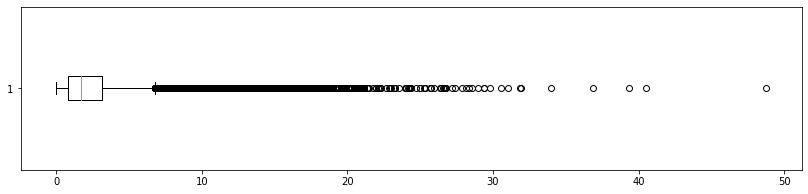

In [358]:
# show boxplot
plt.figure(figsize = (14,3))
plt.boxplot(difference, vert= False);
plt.show()

### LSTM per previsione multistep di serie multivariata 